# **LeMaterial/LeMat-Synth Dataset Analysis**


This notebook is a data analysis of LeMaterial/LeMat-Synth dataset


## **Available Dataset Splits**

- **arxiv**: ArXiv research papers
- **chemrxiv**: ChemRxiv chemistry papers
- **omg24**: OMG24 conference papers
- **sample_for_evaluation**: Evaluation samples


## **Load libraries**


In [32]:
# Import required libraries
import ast
import json
import re
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud

from llm_synthesis.utils.style_utils import set_style

set_style()

warnings.filterwarnings("ignore")

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## **Data set exploration**


### **Understand the data**


Create new column 'source'


Examine the columns, data types, and basic statistics.


In [33]:
from datasets import load_dataset

dataset = load_dataset("LeMaterial/LeMat-Synth", split="sample_for_evaluation")

data = dataset.to_pandas()
data.head()

synthesized_material material_category synthesis_method  \
0         Ta/NiFe/Ru/NiFe/Ta     nanomaterials              PVD   
1        Ta/CoFeB/Ru/NiFe/Ta     nanomaterials              PVD   
2    NiFe(5)/Ru(0.4)/NiFe(3)     nanomaterials              PVD   
3    NiFe(3)/Ru(0.4)/NiFe(5)     nanomaterials              PVD   
4  CoFeB(3)/Ru(0.45)/NiFe(3)     nanomaterials              PVD   

                                              images plot_data  \
0  [{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...      None   
1  [{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...      None   
2  [{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...      None   
3  [{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...      None   
4  [{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...      None   

                                structured_synthesis  \
0  {'target_compound': 'Ta/NiFe/Ru/NiFe/Ta', 'tar...   
1  {'target_compound': 'Ta/CoFeB/Ru/NiFe/Ta', 'ta...   
2  {'target_compound': 'NiFe(5)/Ru(0.4)/NiFe(3)',...   
3  {'target_compound': 'NiFe(3)/Ru(0.4)/NiFe(5)',...   
4  {'target_compound': 'CoFeB(3)/Ru(0.45)/NiFe(3)...   

                                          evaluation  \
0  {'reasoning': 'The extracted ontology captures...   
1  {'reasoning': 'The extracted ontology captures...   
2  {'reasoning': 'The extracted ontology captures...   
3  {'reasoning': 'The extracted ontology captures...   
4  {'reasoning': 'The extraction captures the cor...   

   synthesis_extraction_performance_llm  figure_extraction_performance_llm  \
0                                   NaN                                NaN   
1                                   NaN                                NaN   
2                                   NaN                                NaN   
3                                   NaN                                NaN   
4                                   NaN                                NaN   

   synthesis_extraction_performance_human  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   figure_extraction_performance_human  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

                                        paper_title paper_published_date  \
0  Magnon-magnon coupling in synthetic ferrimagnets                 2023   
1  Magnon-magnon coupling in synthetic ferrimagnets                 2023   
2  Magnon-magnon coupling in synthetic ferrimagnets                 2023   
3  Magnon-magnon coupling in synthetic ferrimagnets                 2023   
4  Magnon-magnon coupling in synthetic ferrimagnets                 2023   

                                      paper_abstract paper_doi  \
0    Magnetic multilayers with interlayer exchang...      None   
1    Magnetic multilayers with interlayer exchang...      None   
2    Magnetic multilayers with interlayer exchang...      None   
3    Magnetic multilayers with interlayer exchang...      None   
4    Magnetic multilayers with interlayer exchang...      None   

                           paper_url  
0  http://arxiv.org/pdf/2307.06888v2  
1  http://arxiv.org/pdf/2307.06888v2  
2  http://arxiv.org/pdf/2307.06888v2  
3  http://arxiv.org/pdf/2307.06888v2  
4  http://arxiv.org/pdf/2307.06888v2

In [34]:
# Extract the domain name from the URL
data["source"] = data["paper_url"].astype(str).str.extract(r"//([^/]+)")

# Cleaning: remove extensions
data["source"] = (
    data["source"]
    .str.replace(r"^www\.", "", regex=True)
    .str.replace(r"^onlinelibrary\.", "", regex=True)
    .str.replace(r"^link\.", "", regex=True)
    .str.replace(r"\.org$|\.com$|\.net$|\.edu$|\.info$", "", regex=True)
)

print(data[["paper_url", "source"]].head())

                           paper_url source
0  http://arxiv.org/pdf/2307.06888v2  arxiv
1  http://arxiv.org/pdf/2307.06888v2  arxiv
2  http://arxiv.org/pdf/2307.06888v2  arxiv
3  http://arxiv.org/pdf/2307.06888v2  arxiv
4  http://arxiv.org/pdf/2307.06888v2  arxiv


In [35]:
print(data.shape)

(589, 17)


In [36]:
# Check the datatypes of each column.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   synthesized_material                    589 non-null    object 
 1   material_category                       589 non-null    object 
 2   synthesis_method                        589 non-null    object 
 3   images                                  575 non-null    object 
 4   plot_data                               0 non-null      object 
 5   structured_synthesis                    589 non-null    object 
 6   evaluation                              522 non-null    object 
 7   synthesis_extraction_performance_llm    0 non-null      float64
 8   figure_extraction_performance_llm       0 non-null      float64
 9   synthesis_extraction_performance_human  0 non-null      float64
 10  figure_extraction_performance_human     0 non-null      float6

In [37]:
# Numerical statistics
data.describe()

synthesis_extraction_performance_llm  \
count                                   0.0   
mean                                    NaN   
std                                     NaN   
min                                     NaN   
25%                                     NaN   
50%                                     NaN   
75%                                     NaN   
max                                     NaN   

       figure_extraction_performance_llm  \
count                                0.0   
mean                                 NaN   
std                                  NaN   
min                                  NaN   
25%                                  NaN   
50%                                  NaN   
75%                                  NaN   
max                                  NaN   

       synthesis_extraction_performance_human  \
count                                     0.0   
mean                                      NaN   
std                                       NaN   
min                                       NaN   
25%                                       NaN   
50%                                       NaN   
75%                                       NaN   
max                                       NaN   

       figure_extraction_performance_human  
count                                  0.0  
mean                                   NaN  
std                                    NaN  
min                                    NaN  
25%                                    NaN  
50%                                    NaN  
75%                                    NaN  
max                                    NaN

### **Handle missing values**


Identify and address any missing values in the DataFrame.


In [38]:
missing_percentages = data.isnull().sum()
print("Percentage of missing values per column:")
print(missing_percentages)
if "images" in data.columns:
    data = data.drop("images", axis=1)
    print("\n'images' column dropped.")

# Fill remaining missing values with "N/A"
data = data.fillna("N/A")
print("\nRemaining missing values filled with 'N/A'.")

# Verify that there are no more missing values
print("\nMissing values after handling:")
print(data.isnull().sum().sum())

Percentage of missing values per column:
synthesized_material                        0
material_category                           0
synthesis_method                            0
images                                     14
plot_data                                 589
structured_synthesis                        0
evaluation                                 67
synthesis_extraction_performance_llm      589
figure_extraction_performance_llm         589
synthesis_extraction_performance_human    589
figure_extraction_performance_human       589
paper_title                                 0
paper_published_date                        0
paper_abstract                              0
paper_doi                                 119
paper_url                                   0
source                                      0
dtype: int64

'images' column dropped.

Remaining missing values filled with 'N/A'.

Missing values after handling:
0


In [39]:
# drop all rows where synthesized_material == "No materials synthesized"
data = data[data["synthesized_material"] != "No materials synthesized"]

## **Data Visualisation**


Create visualizations to understand the distribution and relationships within the data.


### **Summary statistics of all categorical variables**


In [40]:
# Explore basic summary statistics of categorical variables.
data.describe(include=["object"])

synthesized_material     material_category        synthesis_method  \
count                   569                   569                     569   
unique                  567                    25                      49   
top                  SrTiO3  functional materials  wet chemical synthesis   
freq                      2                    95                     199   

       plot_data                               structured_synthesis  \
count        569                                                569   
unique         1                                                569   
top          N/A  {'target_compound': 'Ta/NiFe/Ru/NiFe/Ta', 'tar...   
freq         569                                                  1   

       evaluation synthesis_extraction_performance_llm  \
count         569                                  569   
unique        517                                    1   
top           N/A                                  N/A   
freq           53                                  569   

       figure_extraction_performance_llm  \
count                                569   
unique                                 1   
top                                  N/A   
freq                                 569   

       synthesis_extraction_performance_human  \
count                                     569   
unique                                      1   
top                                       N/A   
freq                                      569   

       figure_extraction_performance_human  \
count                                  569   
unique                                   1   
top                                    N/A   
freq                                   569   

                                              paper_title  \
count                                                 569   
unique                                                206   
top     Insight into Stable, Concentrated Radicals: fr...   
freq                                                   21   

       paper_published_date paper_abstract paper_doi  \
count                   569            569       569   
unique                  117            194       165   
top                    2023            N/A       N/A   
freq                     29             36       104   

                                                paper_url    source  
count                                                 569       569  
unique                                                206         6  
top     https://chemrxiv.org/engage/api-gateway/chemrx...  chemrxiv  
freq                                                   21       334

### **Word cloud of actions**


Total actions extracted: 1849


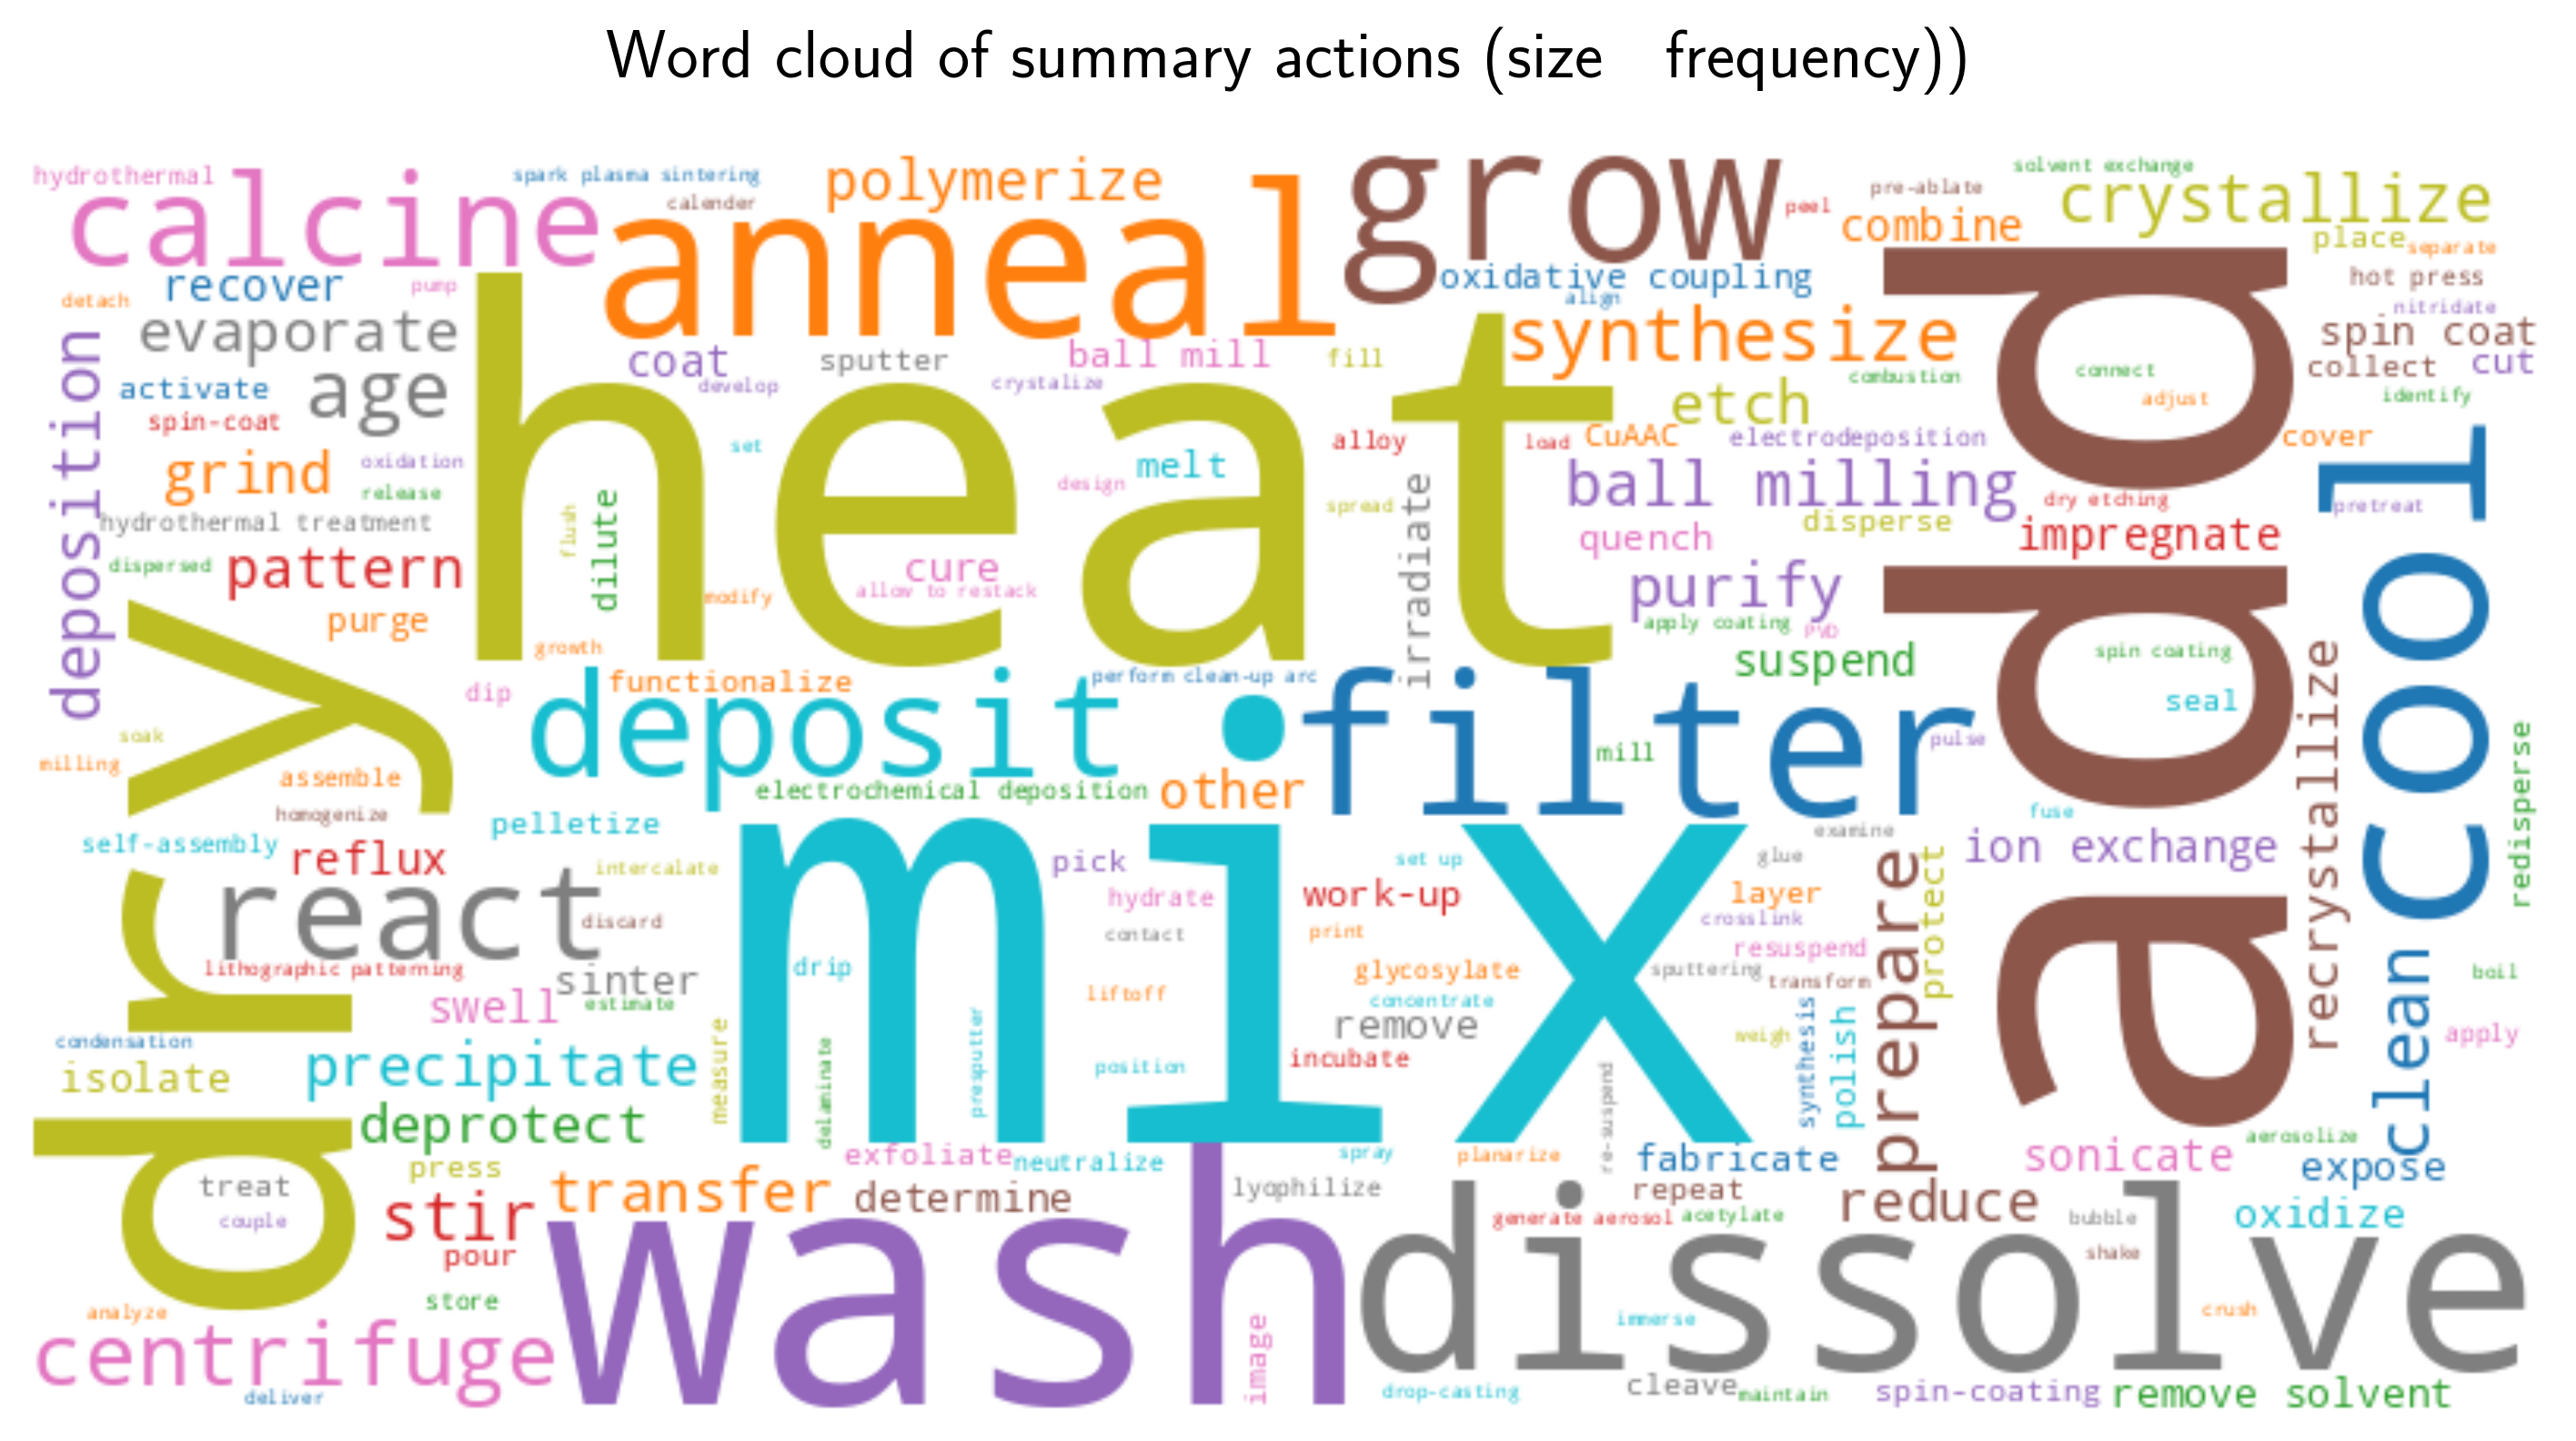

In [41]:
# Extracting the actions from each step (simplified loop)
actions = []
for idx, raw in enumerate(data["structured_synthesis"]):
    try:
        record = json.loads(raw) if isinstance(raw, str) else raw
        for step in record.get("steps", []):
            action = step.get("action")
            if isinstance(action, str) and action:
                actions.append(action)
    except (json.JSONDecodeError, TypeError):
        continue

print(f"Total actions extracted: {len(actions)}")

# Frequency calculation
freq = Counter(actions)

# Preparation and generation of the word cloud
if freq:
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="tab10",
        relative_scaling=0.5,
        normalize_plurals=False,
    )
    wc.generate_from_frequencies(freq)

    # Display
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(
        "Word cloud of summary actions (size ∝ frequency))", fontsize=18, pad=20
    )
    plt.show()
else:
    print("No actions found to generate a word cloud.")

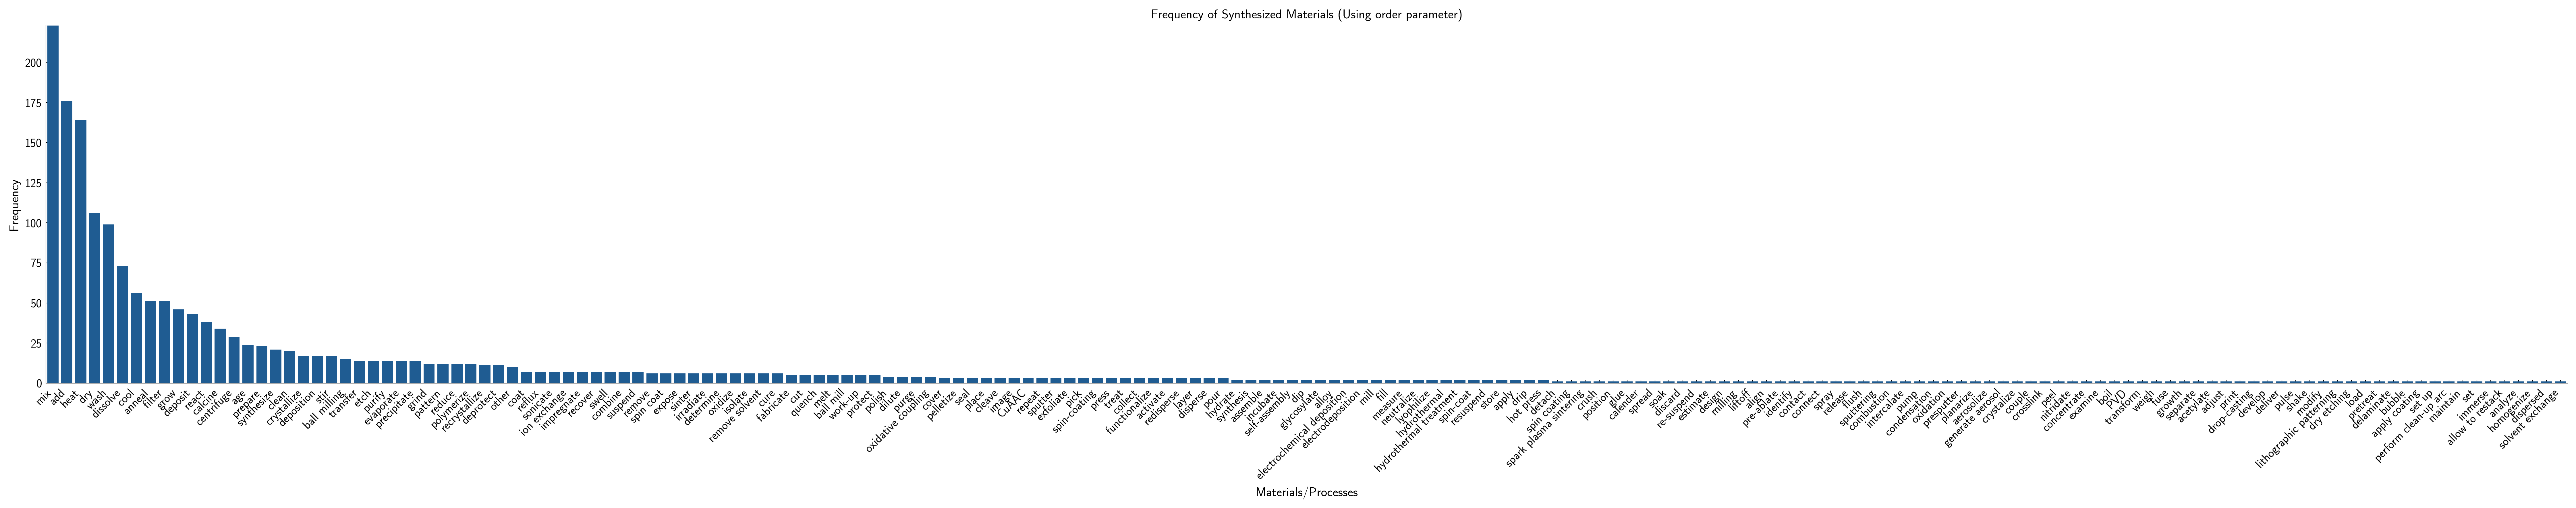

In [42]:
# Create bar plot sorted by frequency (descending order)
plt.figure(figsize=(30, 6))

sorted_categories = sorted(freq.keys(), key=freq.get, reverse=True)

sns.barplot(x=list(freq.keys()), y=list(freq.values()), order=sorted_categories)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Materials/Processes")
plt.ylabel("Frequency")
plt.title("Frequency of Synthesized Materials (Using order parameter)")
plt.tight_layout()
plt.show()

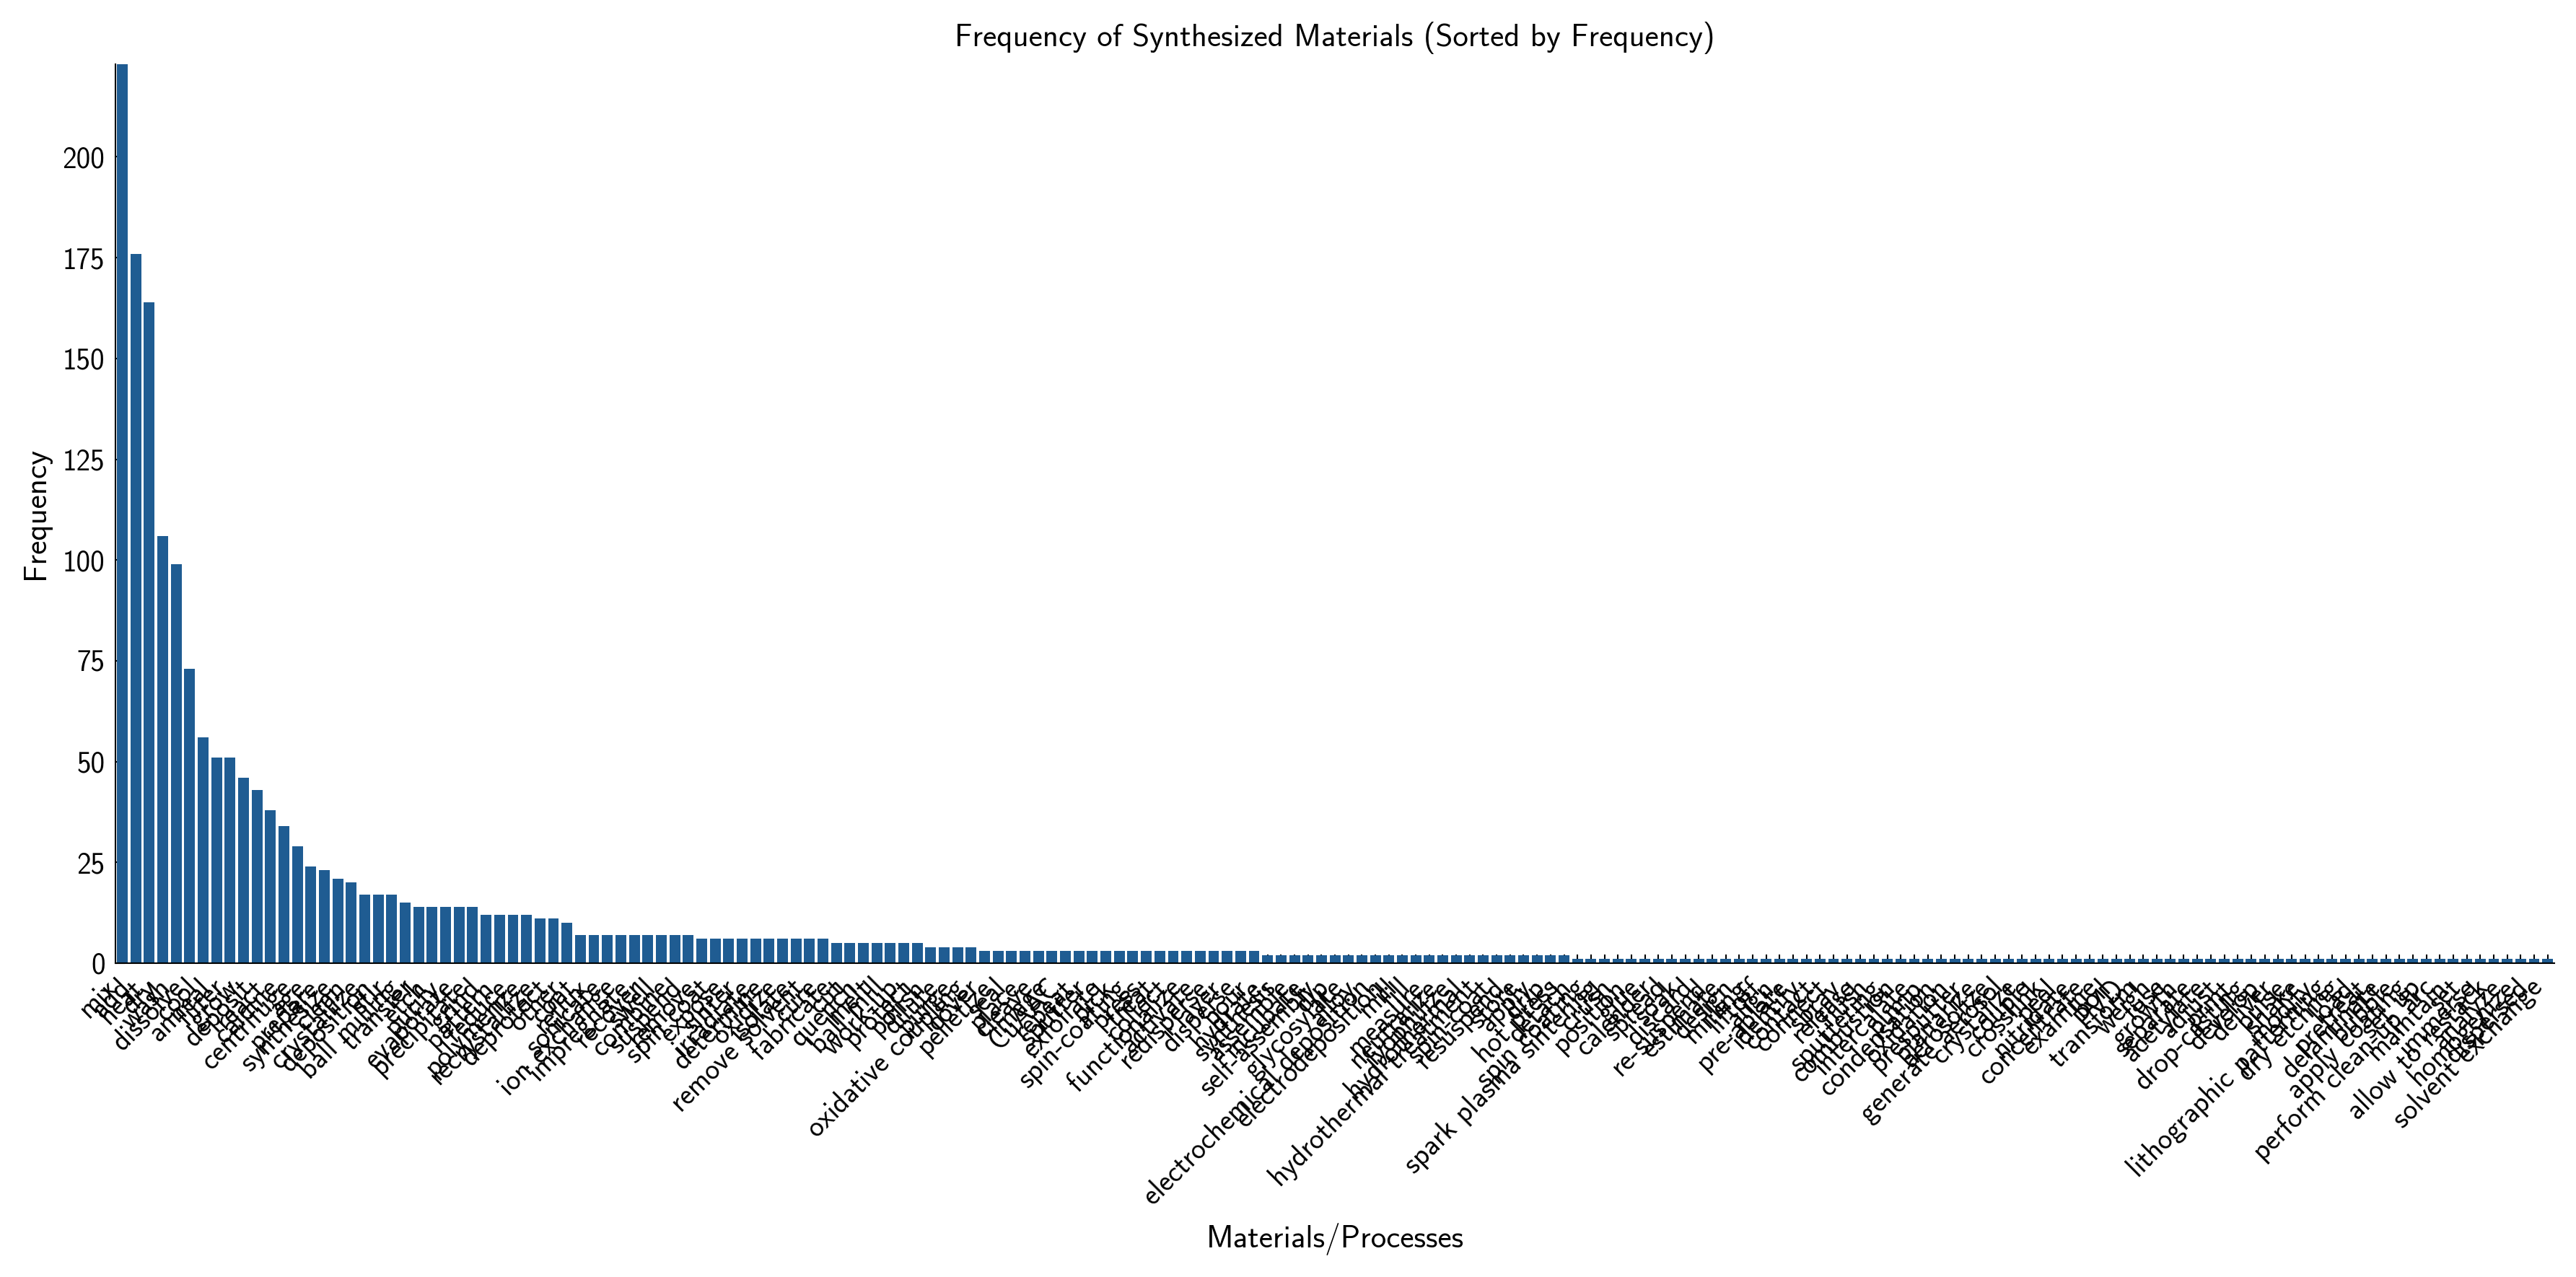

In [43]:
plt.figure(figsize=(12, 6))

# Sort by frequency (descending) - most frequent first
sorted_items = freq.most_common()
categories = [item[0] for item in sorted_items]
values = [item[1] for item in sorted_items]

sns.barplot(x=categories, y=values)
plt.xticks(rotation=45, ha="right")  # ha='right' for better alignment
plt.xlabel("Materials/Processes")
plt.ylabel("Frequency")
plt.title("Frequency of Synthesized Materials (Sorted by Frequency)")
plt.tight_layout()  # Prevents label cutoff
plt.show()

### **Distribution of source**


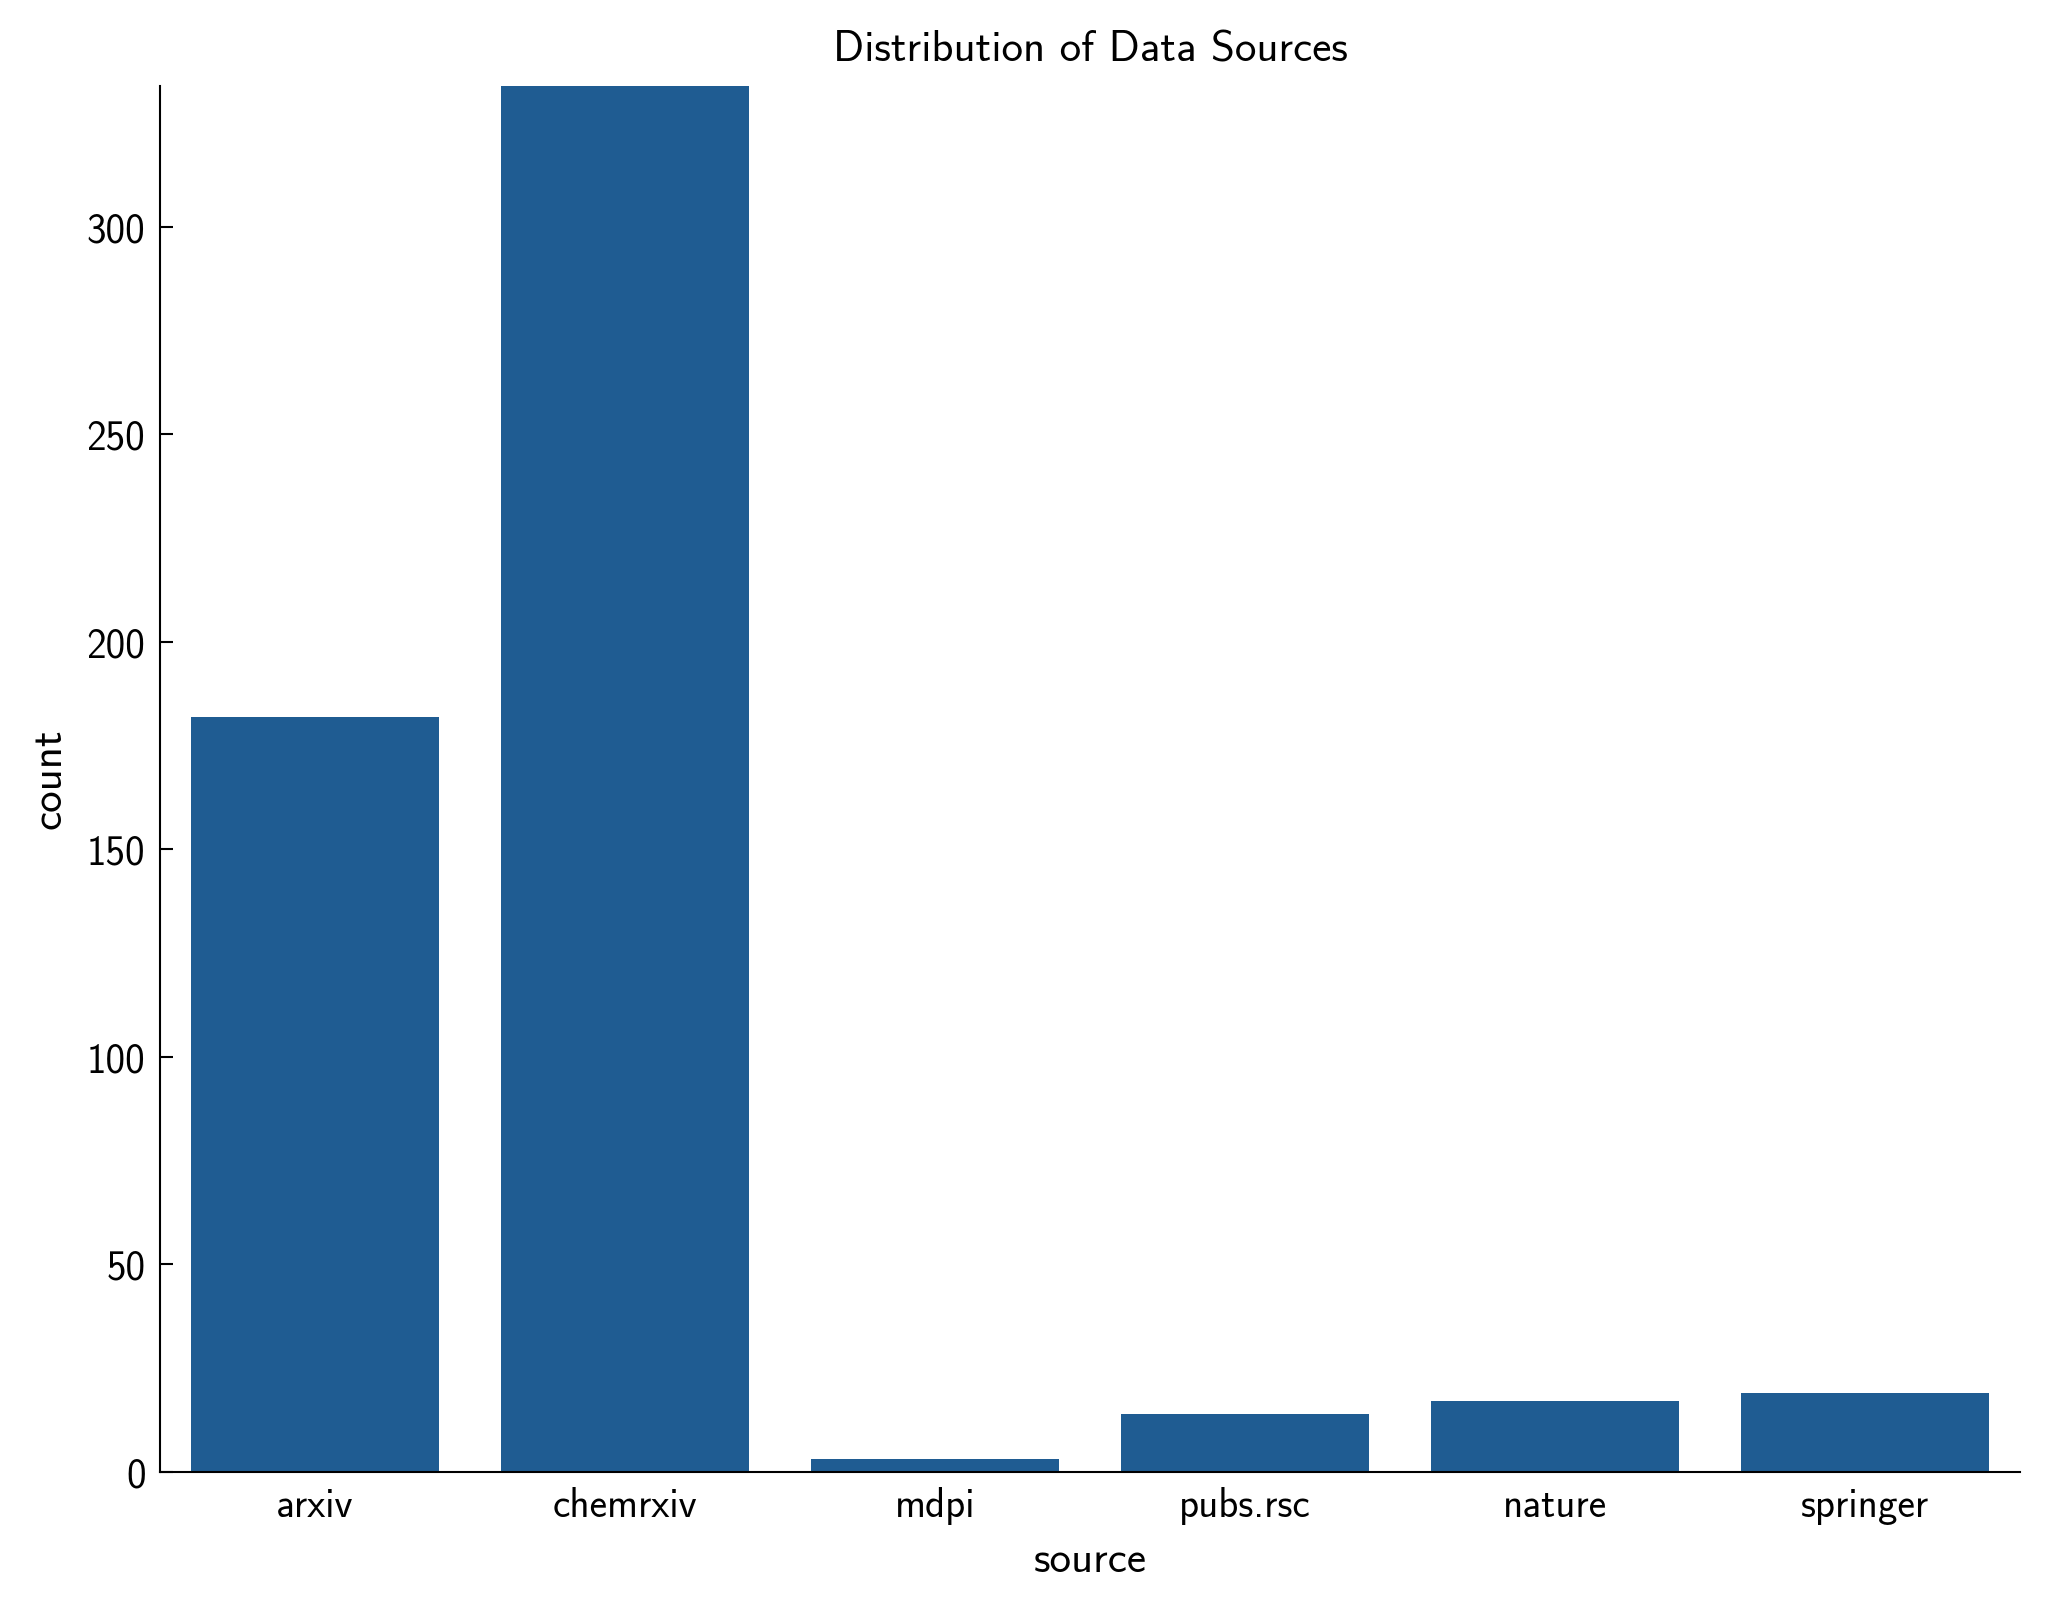

In [44]:
# Create a countplot of the 'source' column
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x="source")
plt.title("Distribution of Data Sources")
plt.show()

In [45]:
data["source"].value_counts()

source
chemrxiv    334
arxiv       182
springer     19
nature       17
pubs.rsc     14
mdpi          3
Name: count, dtype: int64

### **Top of synthetized materials**


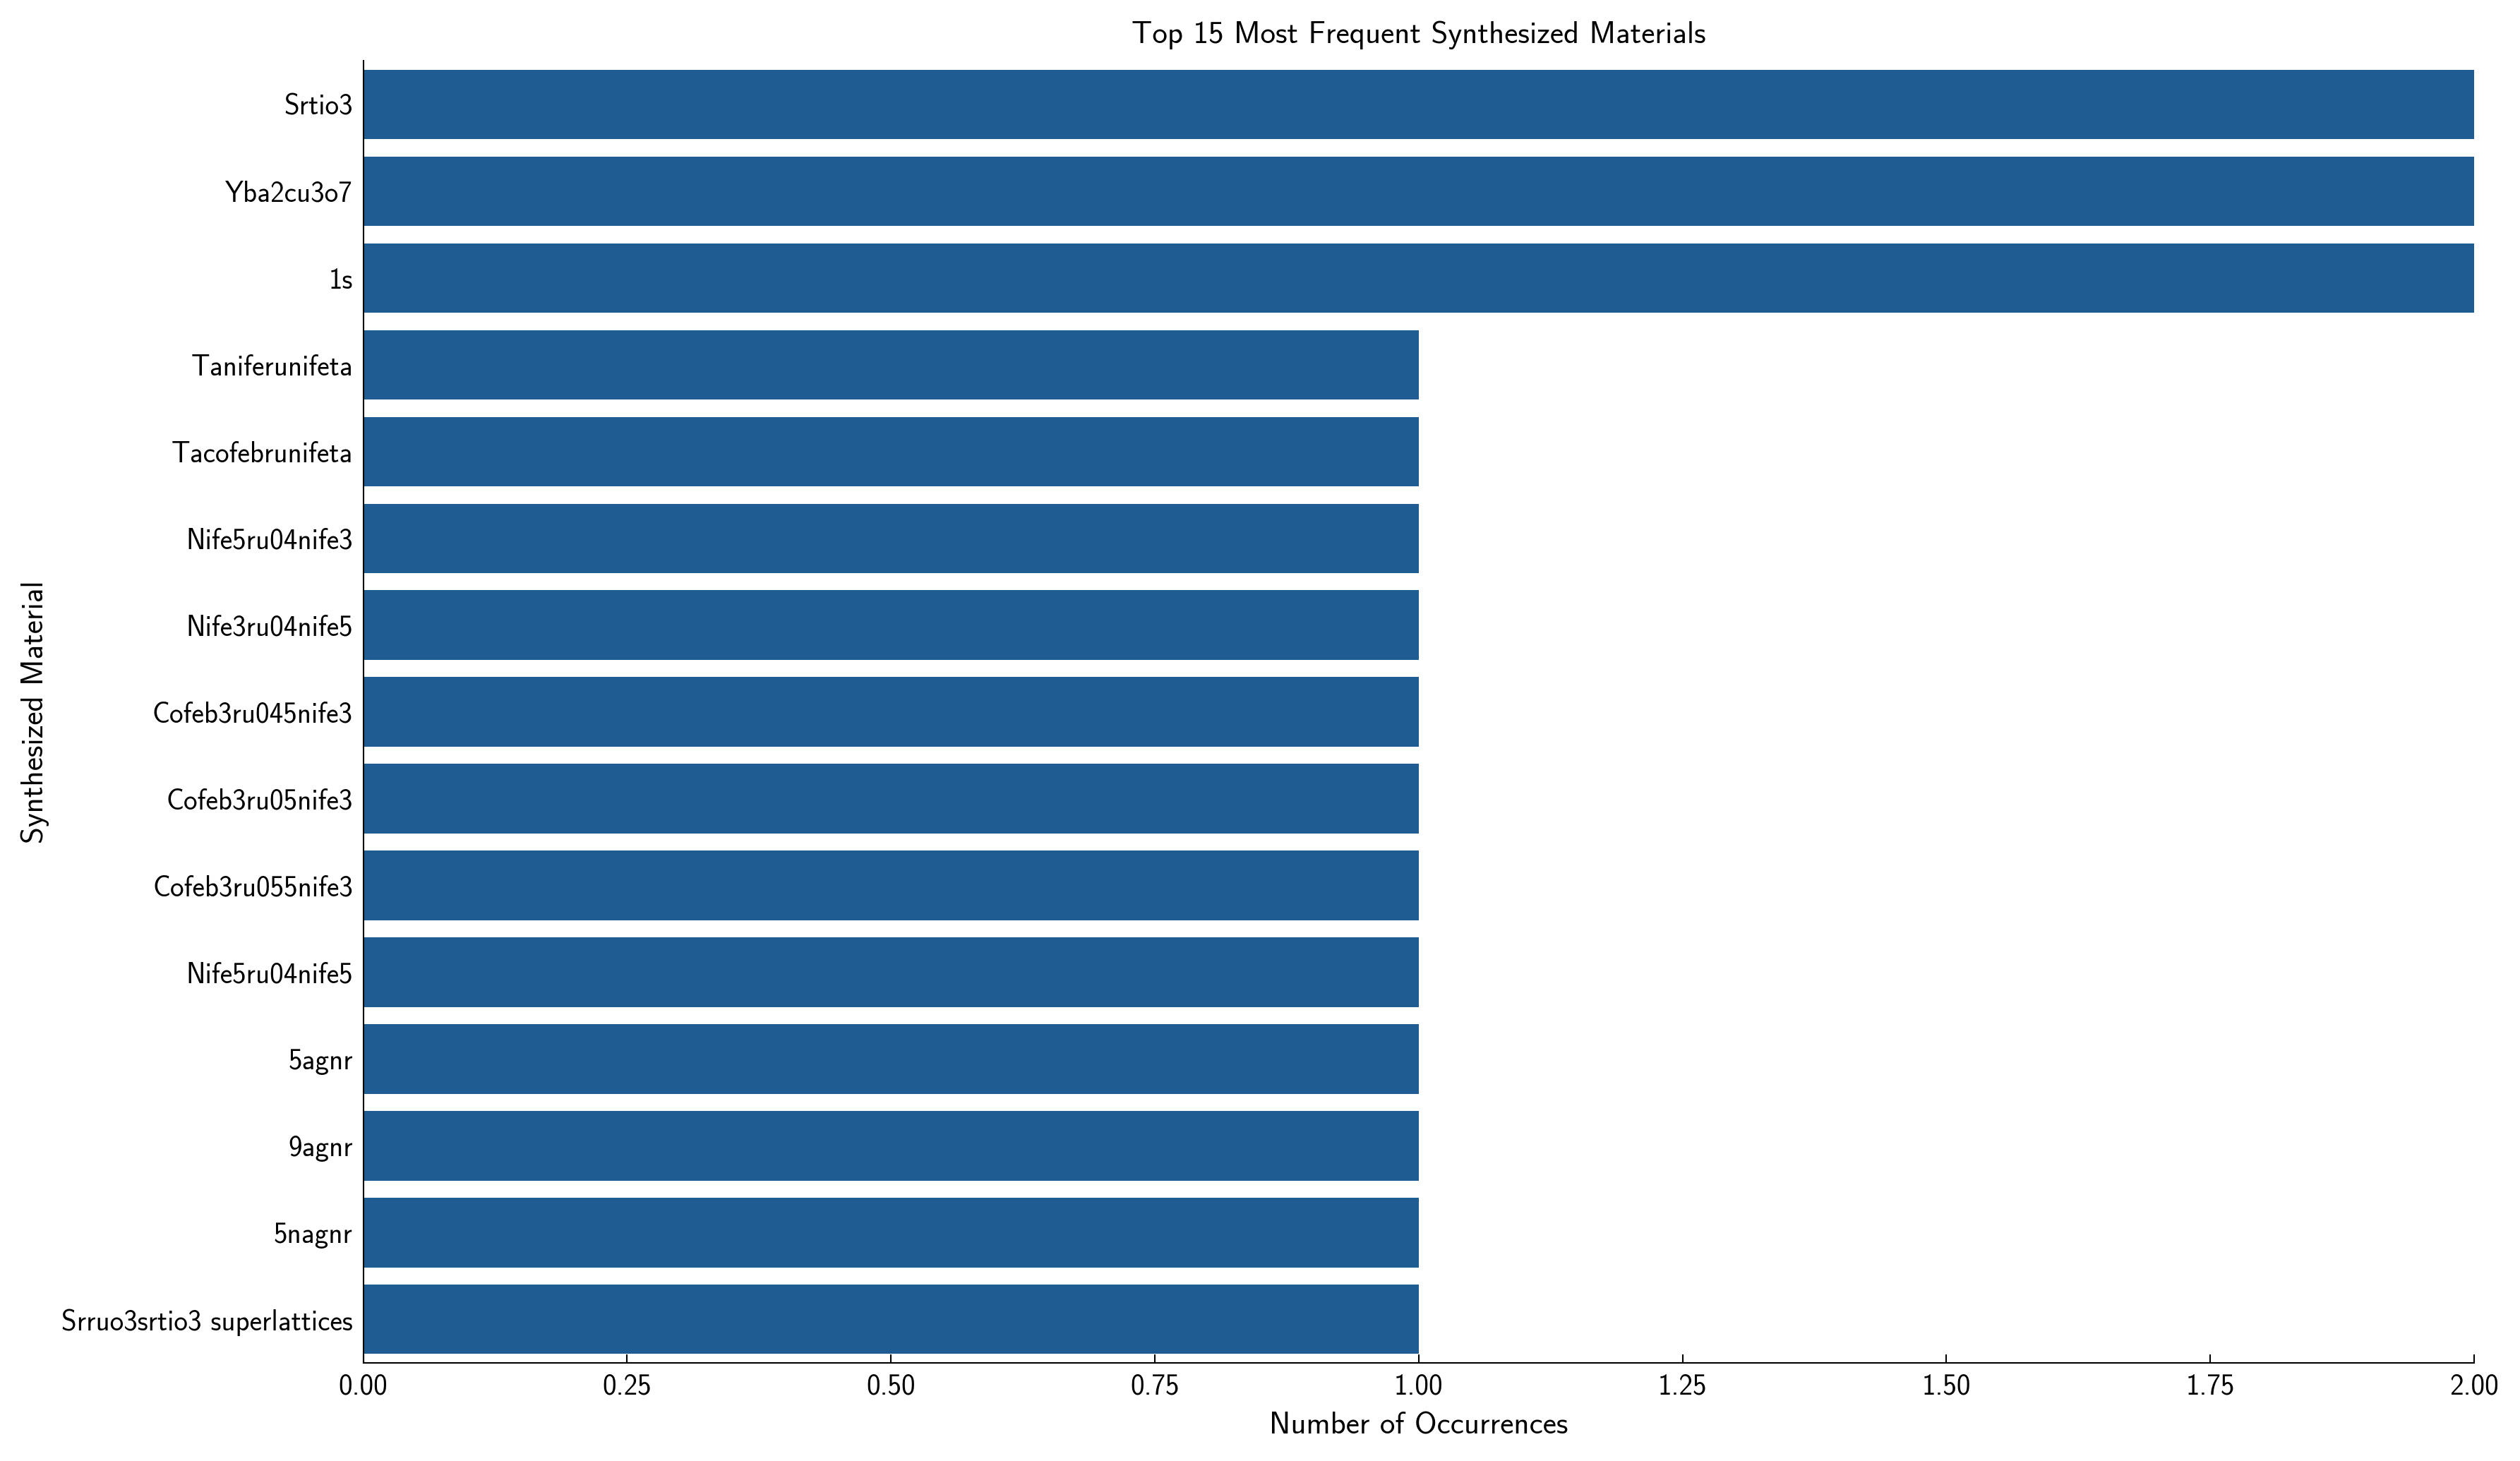

In [46]:
# Simple cleaning function
def clean_material(material):
    if isinstance(material, str):
        material = re.sub(r"[^a-zA-Z0-9\s]", "", material).strip().capitalize()
        # Exclude generic terms, missing values, and "No materials synthesized"
        if material.lower() not in [
            "na",
            "n/a",
            "other",
            "others",
            "no materials synthesized",
        ]:
            return material
    return None


# Apply cleaning to 'synthesized_material'
data["cleaned_synthesized_material"] = data["synthesized_material"].apply(
    clean_material
)

# Count the occurrences of valid synthesized materials
material_counts = Counter(data["cleaned_synthesized_material"].dropna())

# Convert to DataFrame for visualisation
df_materials = pd.DataFrame(
    material_counts.most_common(15), columns=["Synthesized Material", "Count"]
)

# Displaying with Seaborn
plt.figure(figsize=(12, 7))
sns.barplot(data=df_materials, x="Count", y="Synthesized Material")
plt.title("Top 15 Most Frequent Synthesized Materials")
plt.xlabel("Number of Occurrences")
plt.ylabel("Synthesized Material")
plt.tight_layout()
plt.show()

### **Frenquency of material categories**


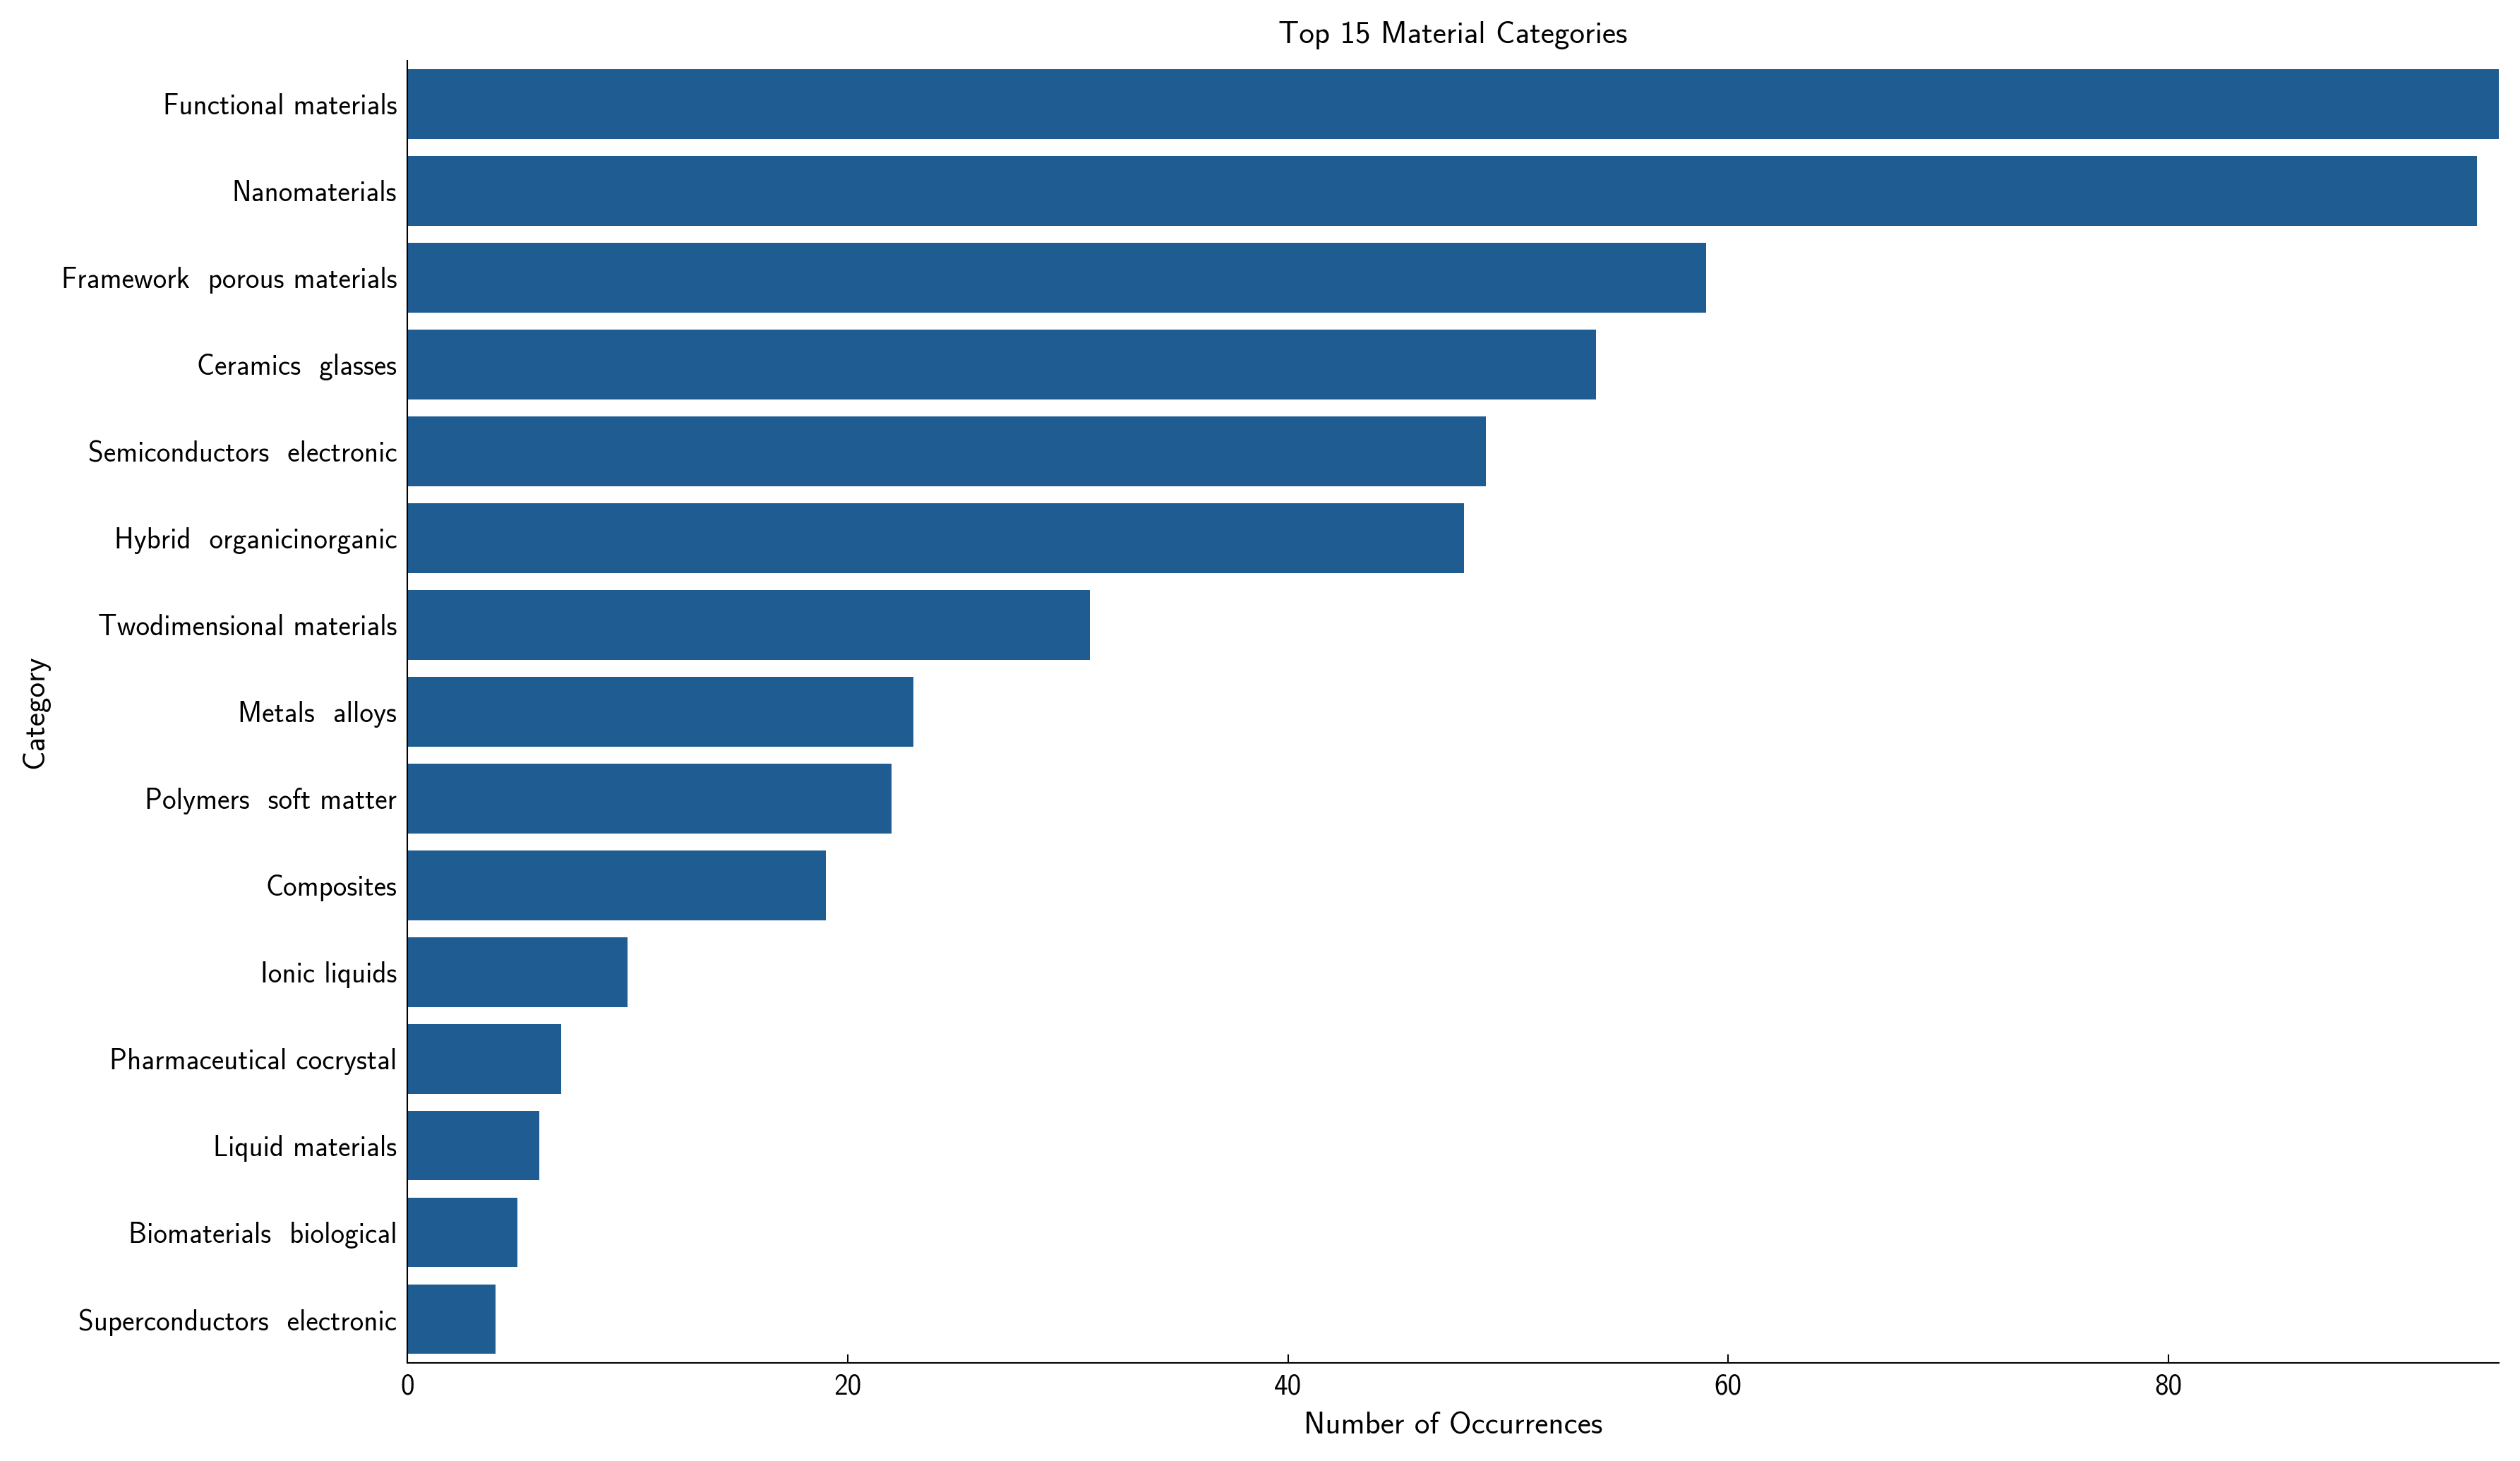

In [47]:
# Simplified function for cleaning a single category
def clean_category(cat):
    if isinstance(cat, str):
        cat = re.sub(r"[^a-zA-Z0-9\s]", "", cat).strip()
        cat = cat.capitalize()
        if cat.lower() not in [
            "material",
            "science",
            "others",
            "n/a",
            "other",
            "na",
        ]:  # Filters out irrelevant cases
            return cat
    return None


# Apply cleaning
data["cleaned_category"] = data["material_category"].apply(clean_category)

# Count the occurrences of valid categories
category_counts = Counter(data["cleaned_category"].dropna())

# Convert to DataFrame for visualisation
df_categories = pd.DataFrame(
    category_counts.most_common(15), columns=["Category", "Count"]
)

# Displaying with Seaborn
plt.figure(figsize=(12, 7))
sns.barplot(data=df_categories, x="Count", y="Category")
plt.title("Top 15 Material Categories")
plt.xlabel("Number of Occurrences")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

In [48]:
# Combine categories from all sources with category data
all_categories = []
# Using the main 'data' DataFrame and iterating through rows
if "data" in globals():
    for index, row in data.iterrows():
        # Use the cleaned categories if available, otherwise clean them here
        categories = row.get("cleaned_categories")
        if categories is None or not isinstance(categories, list):
            # If not available or not a list, clean from the original 'categories' column
            # Re-using the cleaning logic from elsewhere for consistency
            def clean_single_category_entry(categories_list):
                cleaned = []
                if isinstance(categories_list, str):
                    try:
                        categories_list = ast.literal_eval(categories_list)
                    except (ValueError, SyntaxError):
                        categories_list = [categories_list]

                if isinstance(categories_list, list):
                    for category in categories_list:
                        if isinstance(category, str):
                            for part in category.split(","):
                                for sub_part in part.split(";"):
                                    cleaned_category = sub_part.strip()
                                    if cleaned_category:
                                        cleaned.append(cleaned_category)
                return cleaned

            categories = clean_single_category_entry(row["material_category"])

        # Filter out 'N/A', 'Other', 'Others', 'NA' (case-insensitive)
        filtered_categories = [
            cat
            for cat in categories
            if isinstance(cat, str)
            and cat.lower() not in ["n/a", "other", "others", "na"]
        ]
        all_categories.extend(filtered_categories)

if all_categories:
    # Count the frequency of each category
    category_counts = Counter(all_categories)
    category_df = pd.DataFrame(
        category_counts.items(), columns=["Category", "Count"]
    )

    # Create a treemap
    fig = px.treemap(
        category_df,
        path=["Category"],
        values="Count",
        title="Interactive Treemap of Material Categories",
    )
    fig.show()
else:
    print("No category data available to create a treemap after filtering.")

### **Top of synthesis methods**


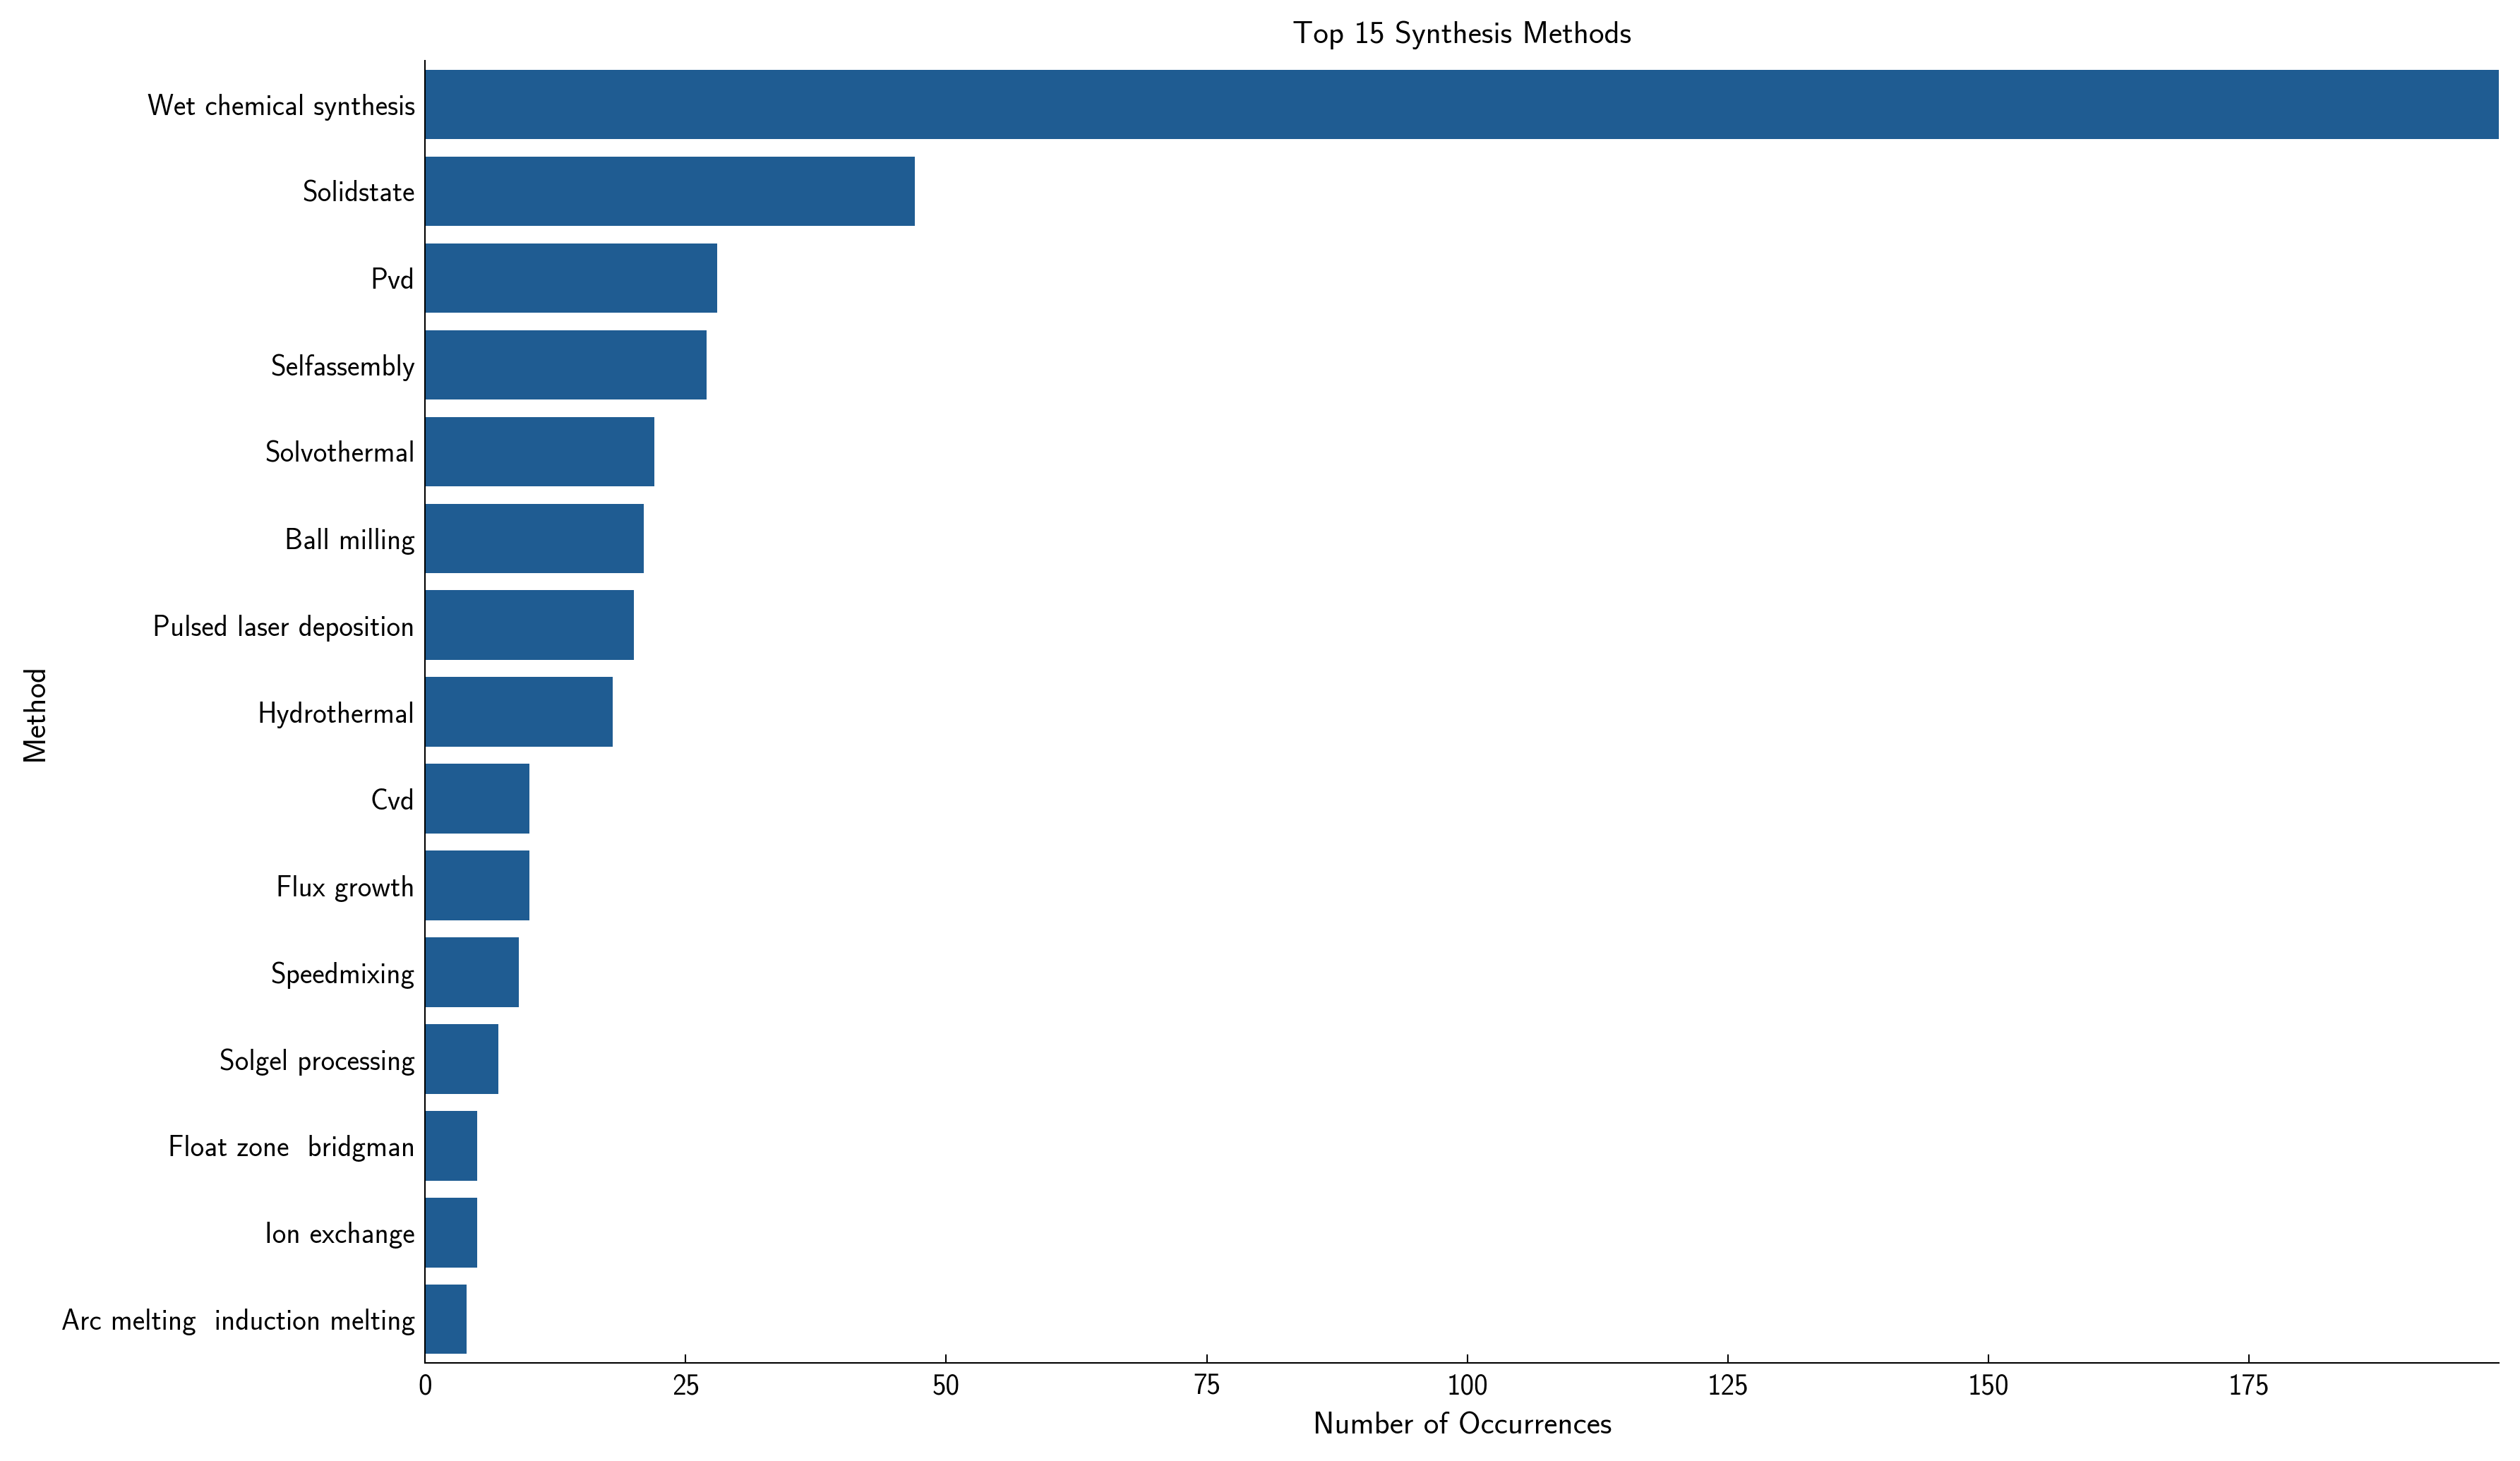

In [49]:
# Apply cleaning to 'synthesis_method'
data["cleaned_synthesis_method"] = data["synthesis_method"].apply(
    clean_category
)

# Count the occurrences of valid synthesis methods
method_counts = Counter(data["cleaned_synthesis_method"].dropna())

# Convert to DataFrame for visualisation
df_methods = pd.DataFrame(
    method_counts.most_common(15), columns=["Method", "Count"]
)

# Displaying with Seaborn
plt.figure(figsize=(12, 7))
sns.barplot(data=df_methods, x="Count", y="Method")
plt.title("Top 15 Synthesis Methods")
plt.xlabel("Number of Occurrences")
plt.ylabel("Method")
plt.tight_layout()
plt.show()

## **Advanced data exploration**


Perform a deeper dive into the dataset by exploring relationships between columns.


### **Correlation between synthesized materials and material categories**


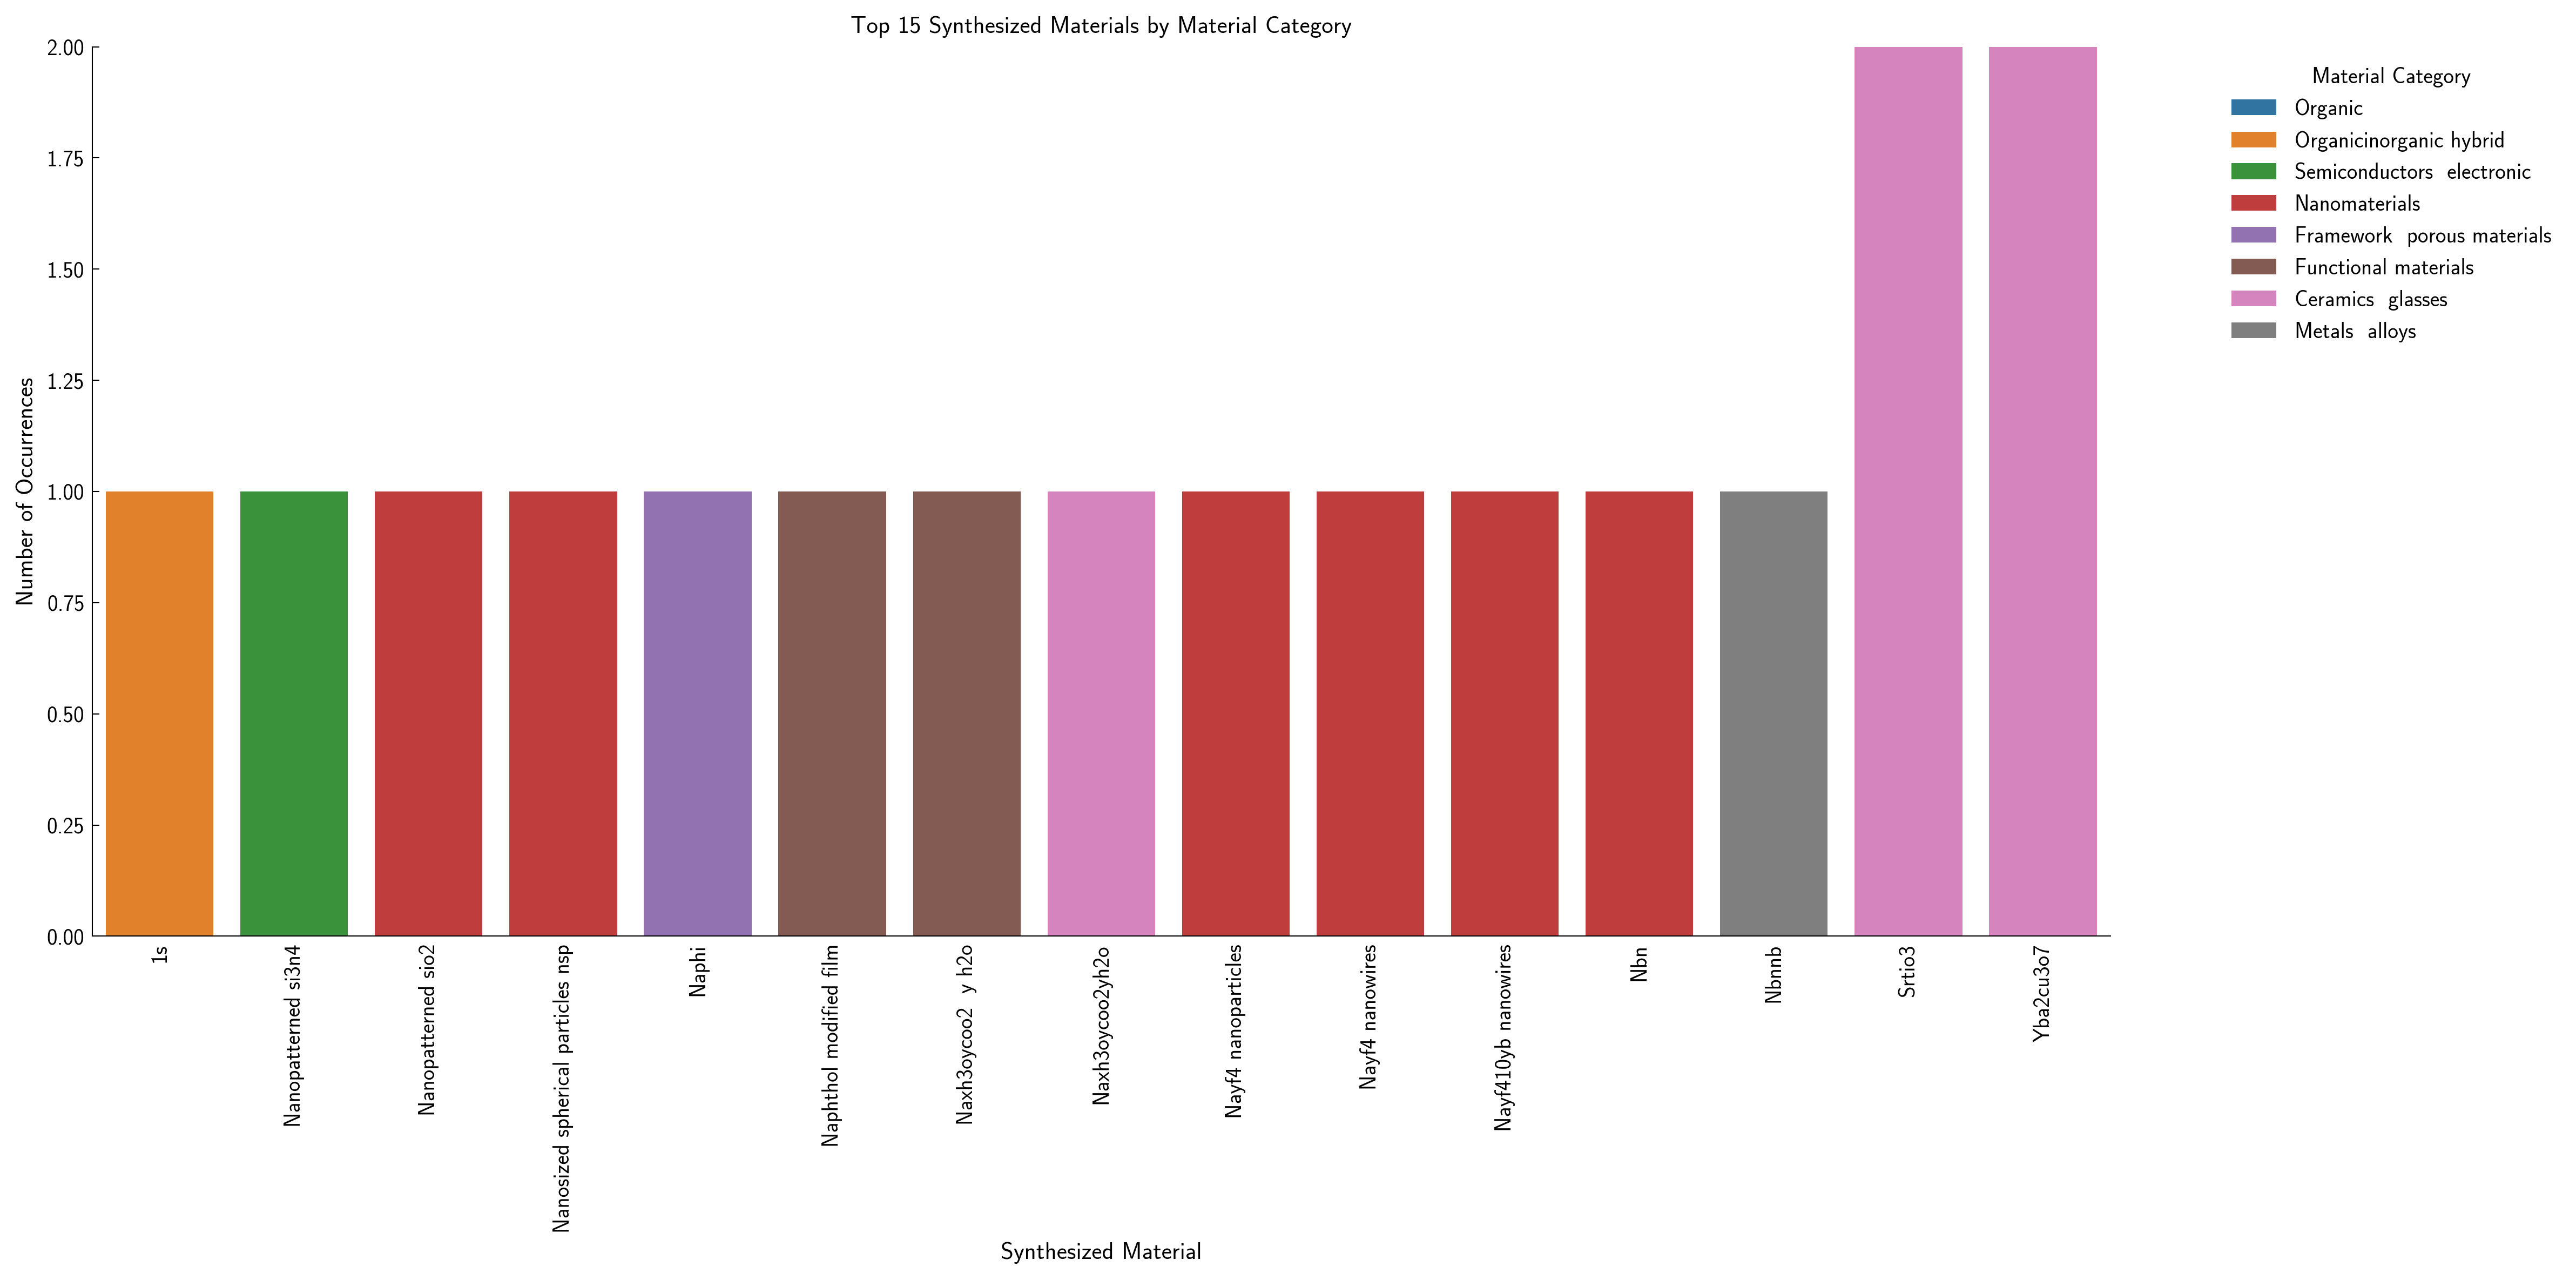

In [50]:
# Easy cleaning
def clean(text):
    if isinstance(text, str):
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text).strip().capitalize()
        if text.lower() not in [
            "material",
            "science",
            "others",
            "other",
            "n/a",
            "na",
        ]:
            return text
    return None


# Clean both columns
data["clean_material"] = data["material_category"].apply(clean)
data["clean_synth"] = data["synthesized_material"].apply(clean)

# Delete rows where either of the two is empty
df = data.dropna(subset=["clean_material", "clean_synth"])

# Group and count pairs
grouped = (
    df.groupby(["clean_synth", "clean_material"])
    .size()
    .reset_index(name="count")
)

# Choose the best synthesised materials to avoid overload
top_synths = (
    grouped.groupby("clean_synth")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .index
)
filtered = grouped[grouped["clean_synth"].isin(top_synths)]

# Grouped plot
plt.figure(figsize=(16, 8))
sns.barplot(
    data=filtered,
    x="clean_synth",
    y="count",
    hue="clean_material",
    palette="tab10",
    dodge=False,
)

plt.title("Top 15 Synthesized Materials by Material Category")
plt.xlabel("Synthesized Material")
plt.ylabel("Number of Occurrences")
plt.xticks(rotation=90, ha="center")

plt.legend(
    title="Material Category", bbox_to_anchor=(1.05, 1), loc="upper left"
)
plt.tight_layout()
plt.show()

### **Correlation between synthesized materials and synthesis methods**


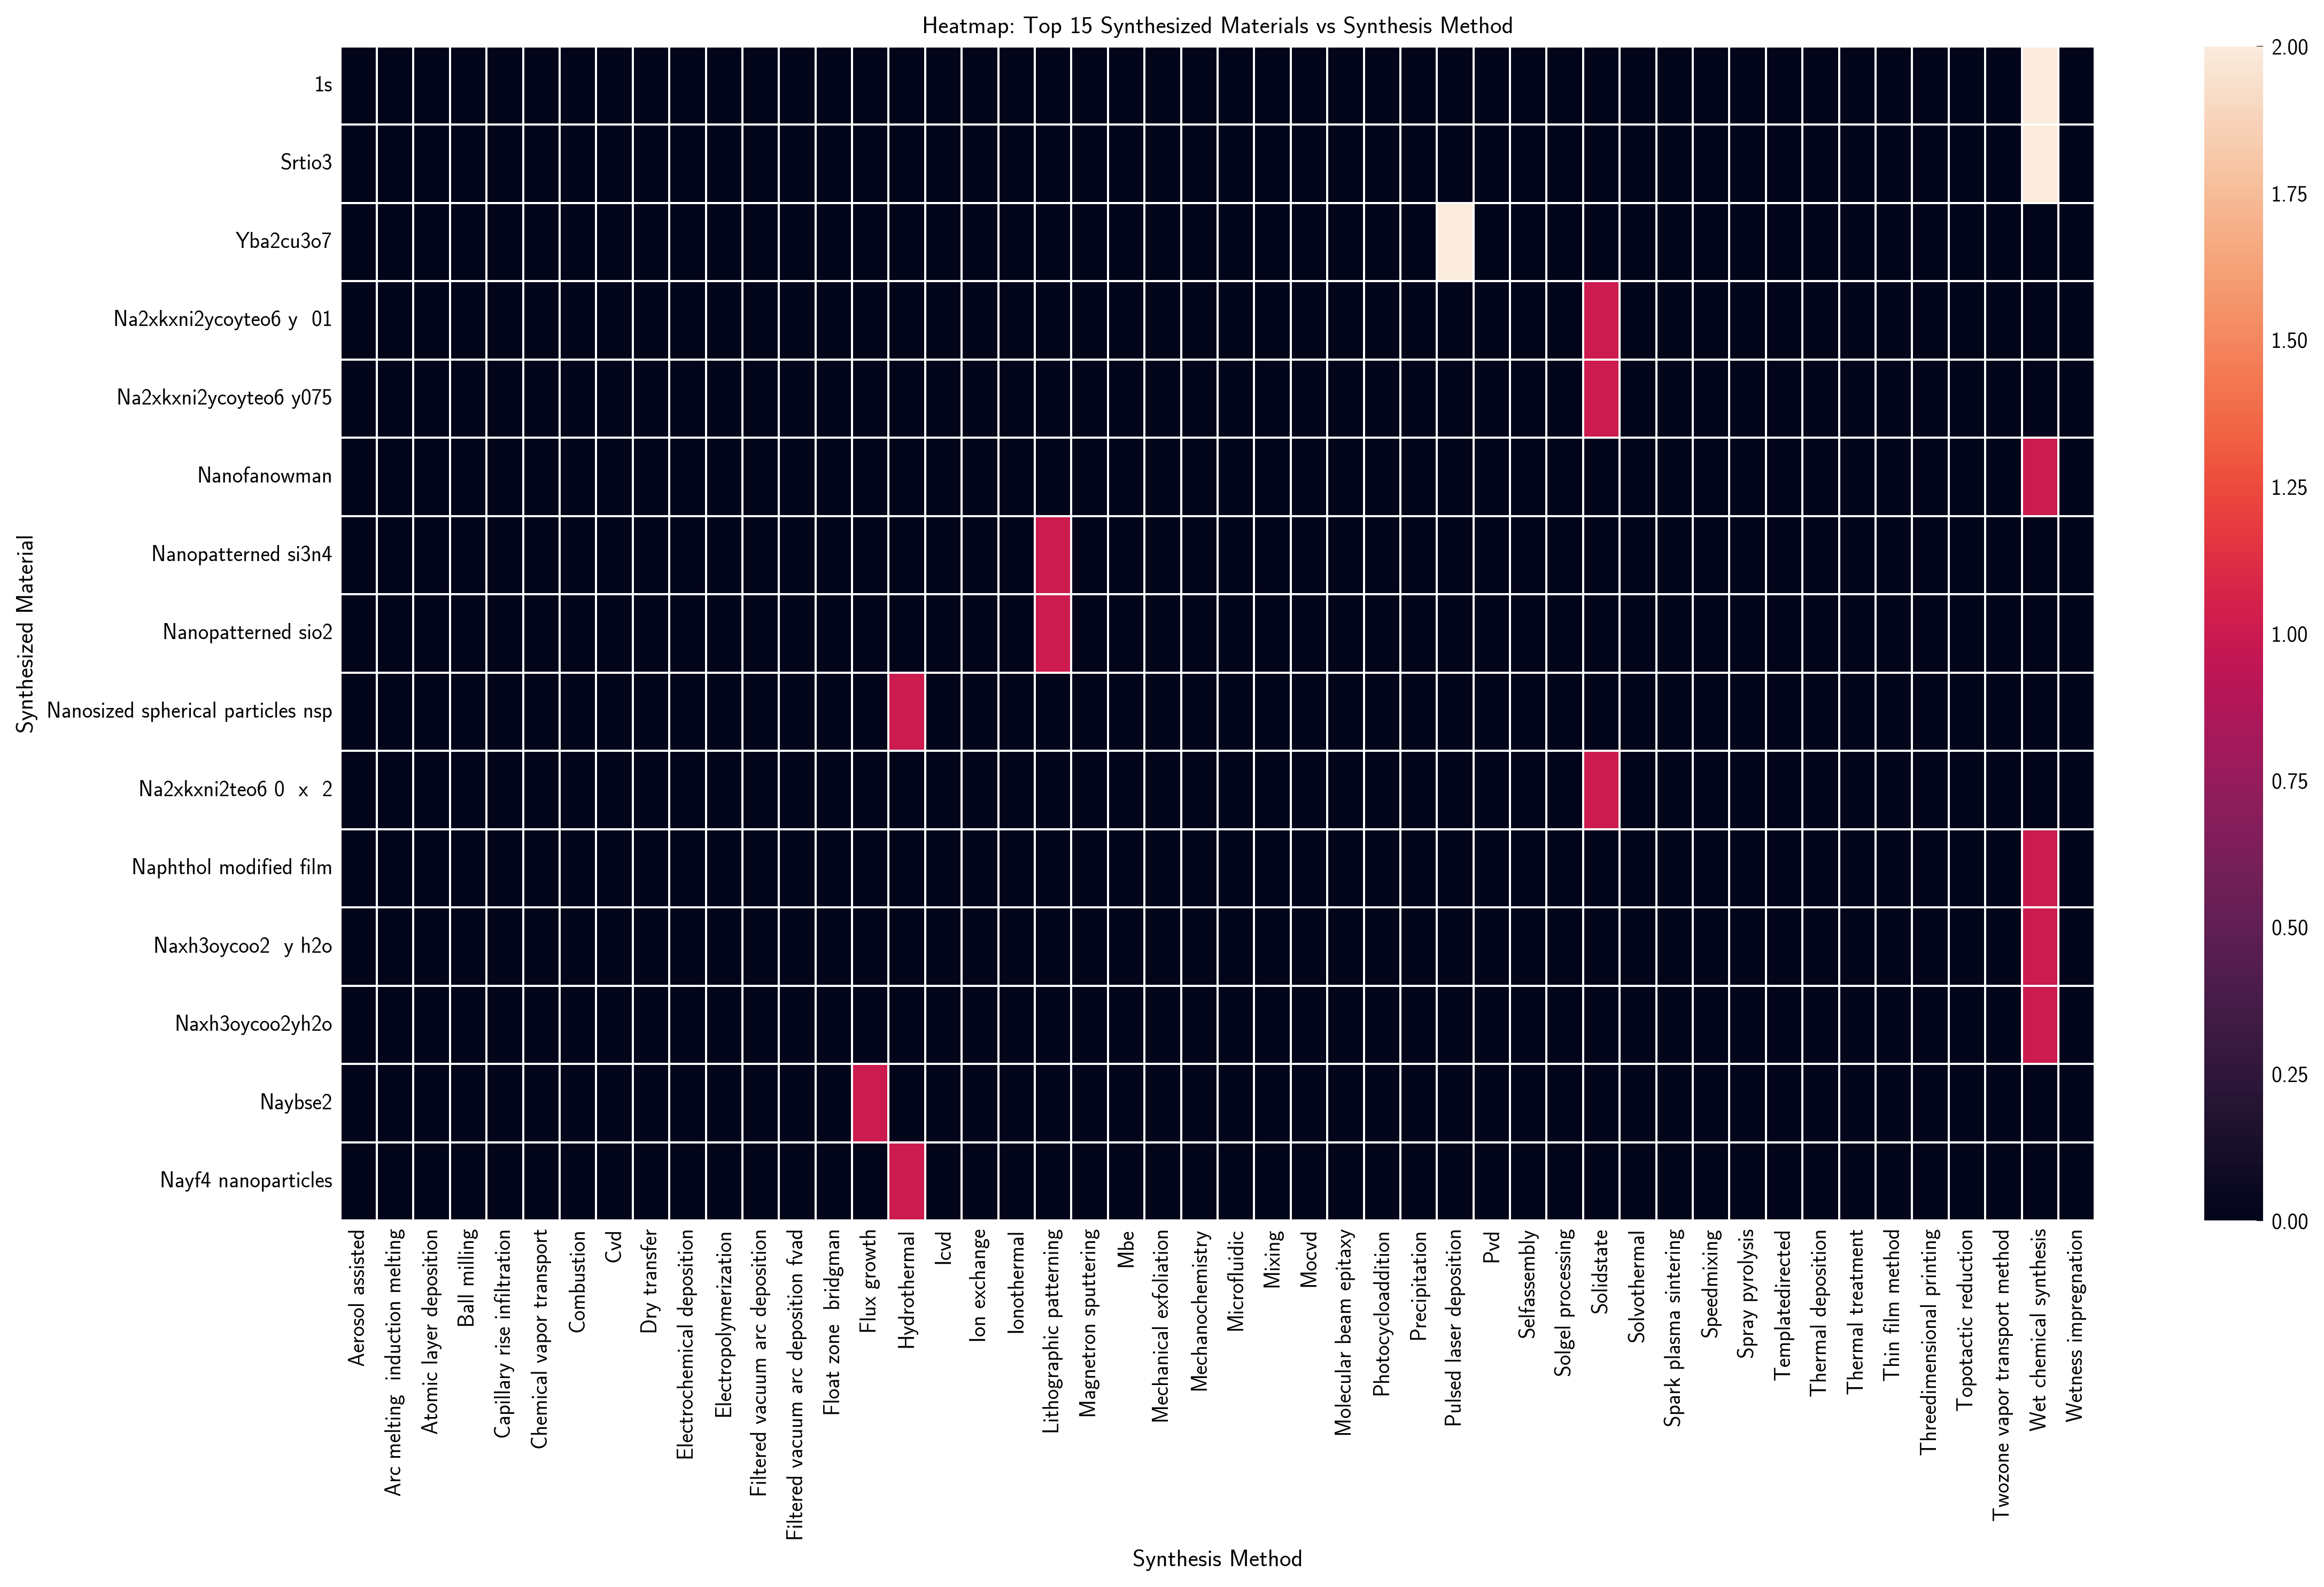

In [51]:
data["clean_method"] = data["synthesis_method"].apply(clean)

# Create a crosstab (pivot table)
pivot_table = pd.crosstab(data["clean_synth"], data["clean_method"])

# Get the top 15 most synthesized materials
top_synths = pivot_table.sum(axis=1).sort_values(ascending=False).head(15).index

# Filter the pivot table to include only the top 15 materials
filtered_pivot_table = pivot_table.loc[top_synths]

# Display as a heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(filtered_pivot_table, linewidths=0.5, annot=False)
plt.title("Heatmap: Top 15 Synthesized Materials vs Synthesis Method")
plt.xlabel("Synthesis Method")
plt.ylabel("Synthesized Material")
plt.tight_layout()
plt.show()

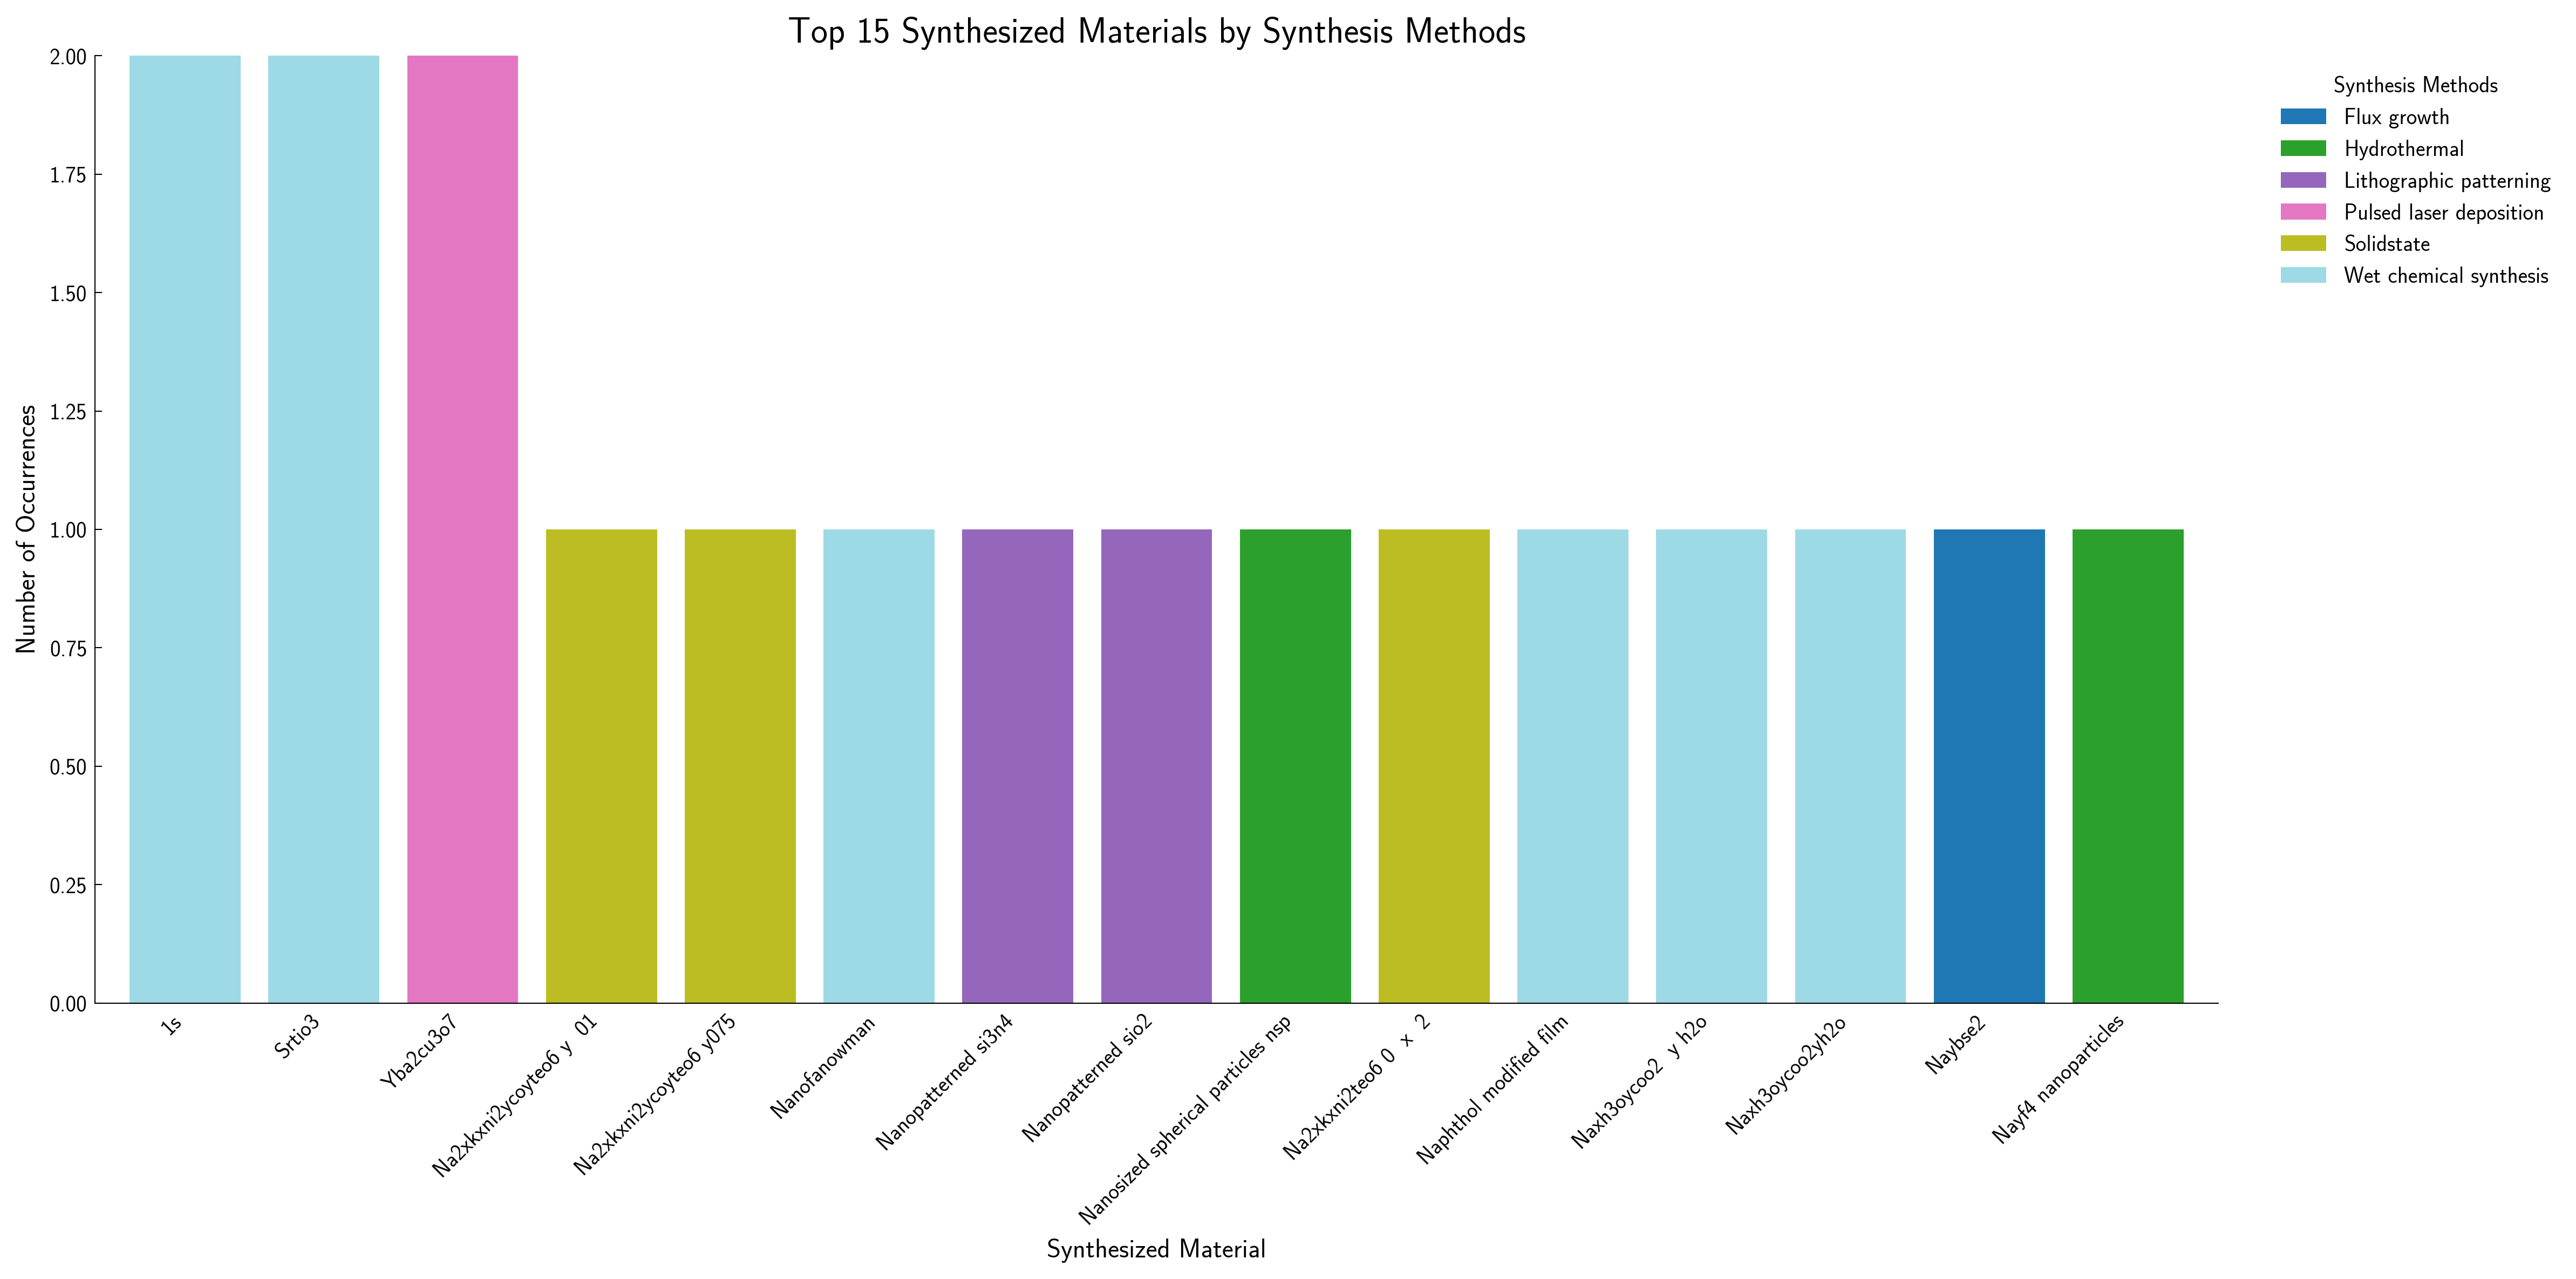

In [52]:
# Delete rows where either of the two is empty
df = data.dropna(subset=["clean_method", "clean_synth"])

# Group and count pairs
grouped = (
    df.groupby(["clean_synth", "clean_method"]).size().reset_index(name="count")
)

# Choose the best synthesised materials to avoid overload
top_synths = (
    grouped.groupby("clean_synth")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .index
)
filtered = grouped[grouped["clean_synth"].isin(top_synths)]

# 1. Pivot the data to a "wide" format suitable for stacking
pivot_df = filtered.pivot_table(
    index="clean_synth",
    columns="clean_method",
    values="count",
    fill_value=0,  # Fills in 0 for any material/method pair that doesn't exist
)

# 2. Reorder the data to match the top 15 sorted list
pivot_df = pivot_df.reindex(top_synths)

# 3. Create the stacked bar plot from the new pivoted DataFrame
ax = pivot_df.plot(
    kind="bar", stacked=True, figsize=(16, 8), width=0.8, colormap="tab20"
)

plt.title("Top 15 Synthesized Materials by Synthesis Methods", fontsize=16)
plt.xlabel("Synthesized Material", fontsize=12)
plt.ylabel("Number of Occurrences", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(
    title="Synthesis Methods", bbox_to_anchor=(1.02, 1), loc="upper left"
)
plt.tight_layout()
plt.show()

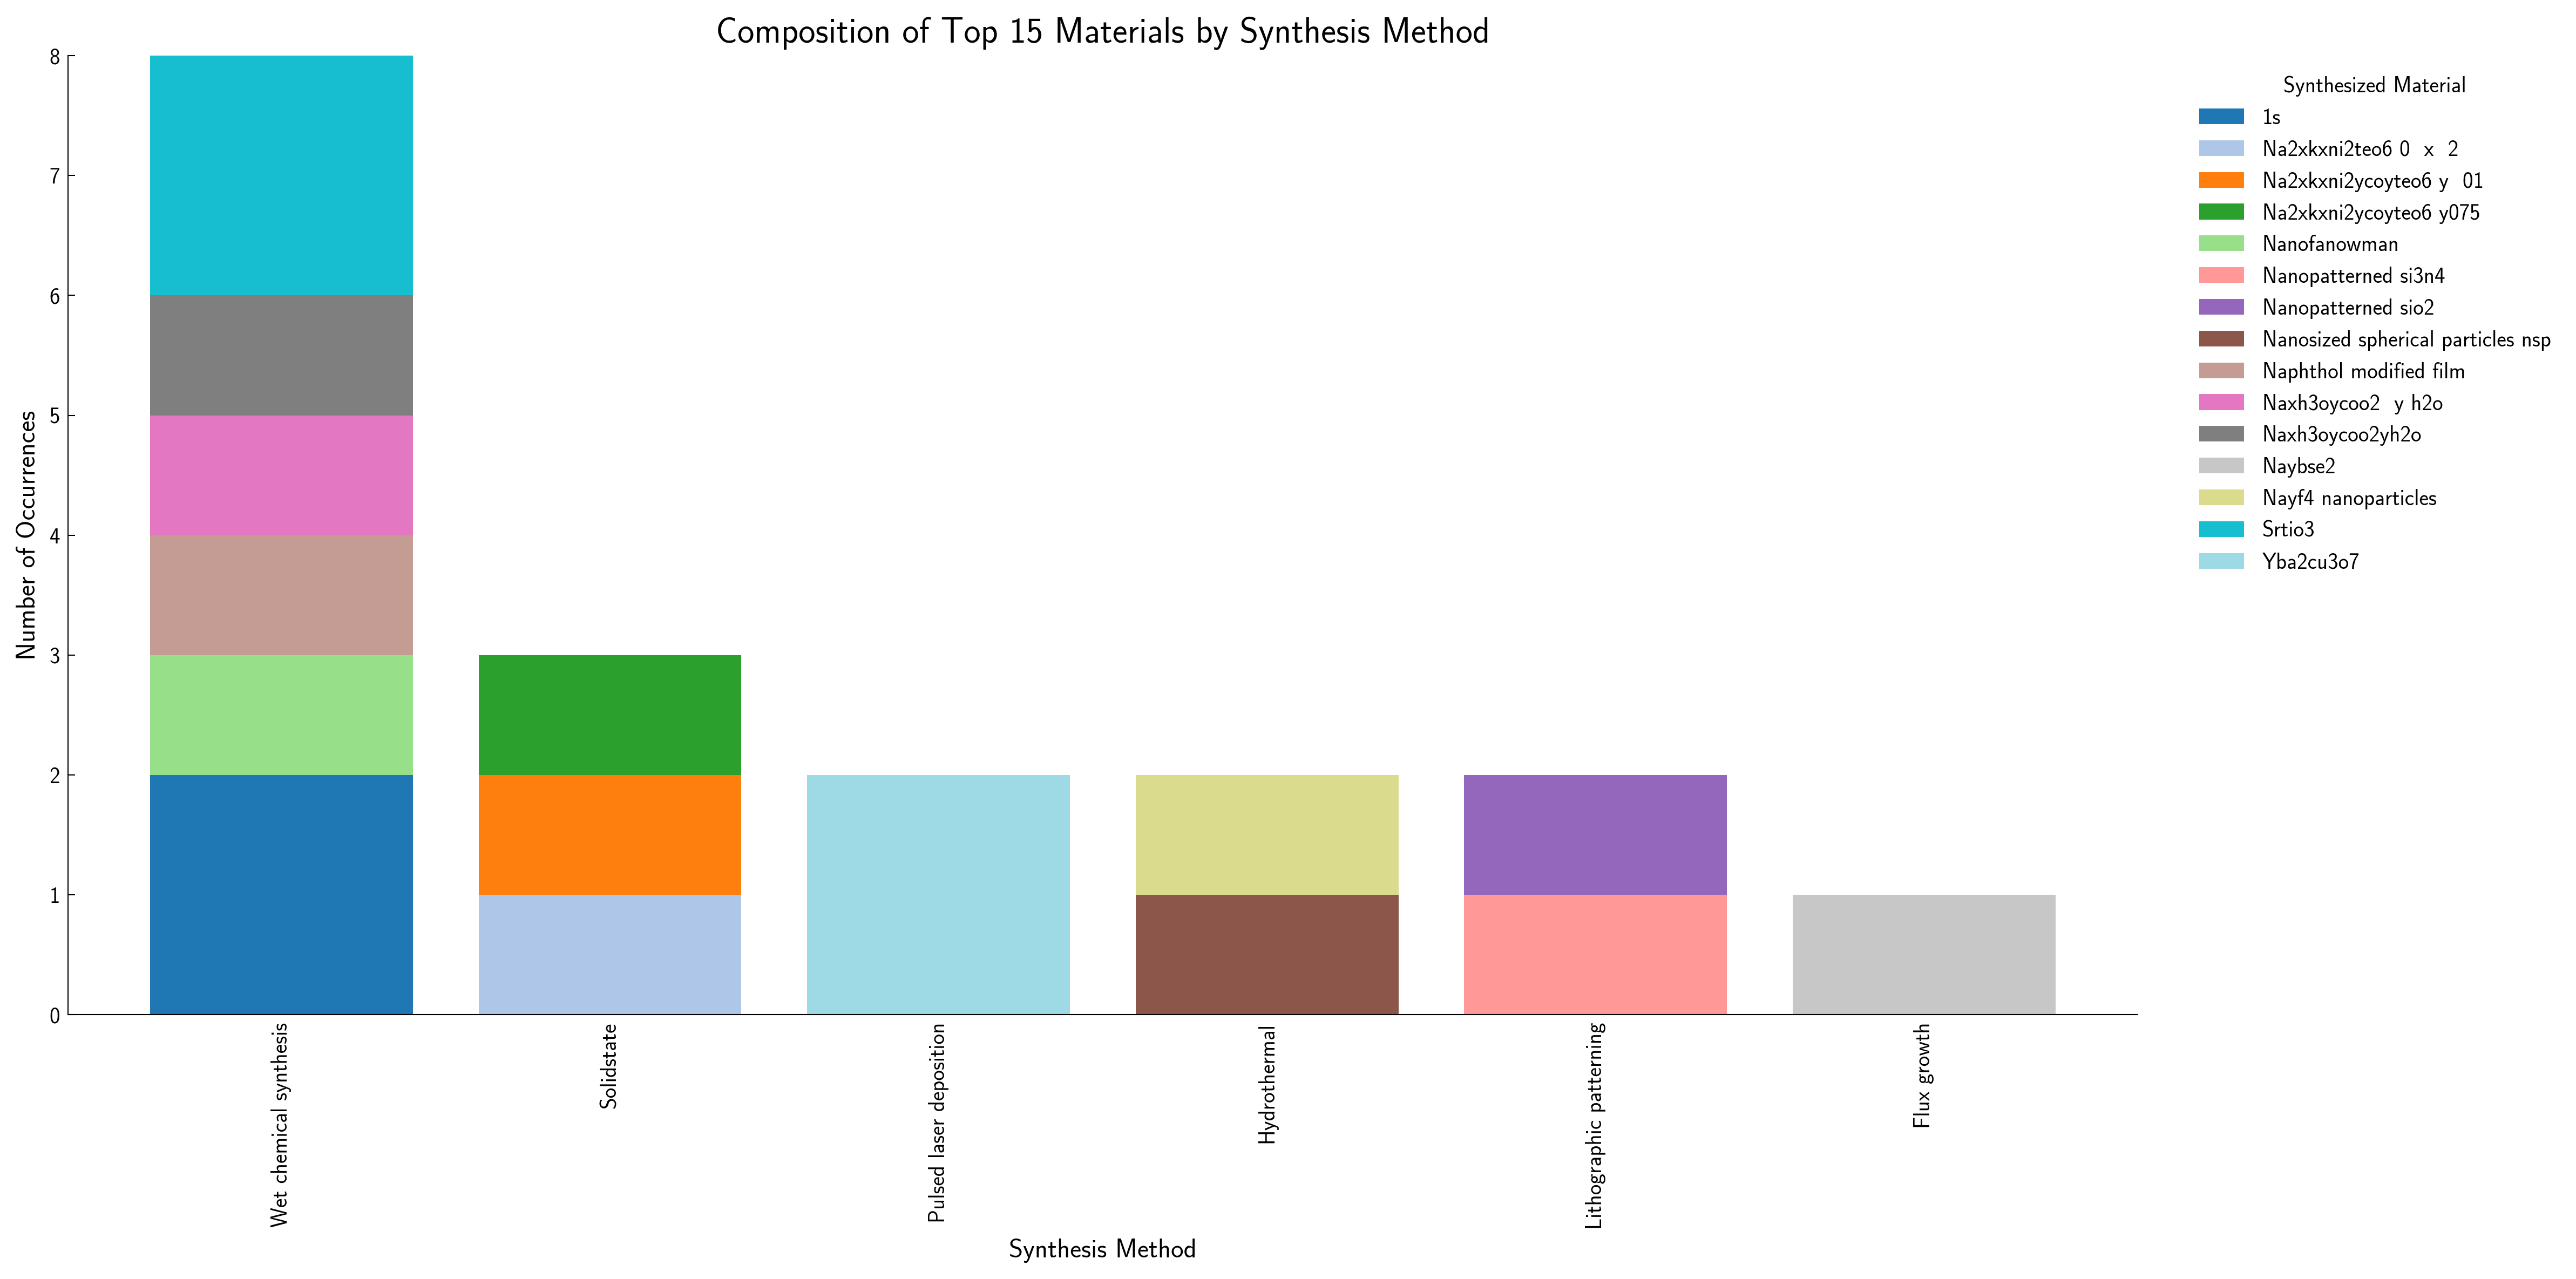

In [53]:
# --- TRANSFORMATION TO INVERTED STACKED CHART ---

# 1. Invert the pivot table 🔄
# The methods are now the rows (x-axis) and materials are the columns (legend).
pivot_df_swapped = filtered.pivot_table(
    index="clean_method", columns="clean_synth", values="count", fill_value=0
)

# 2. Optional but recommended: Sort the methods by total occurrences
method_order = pivot_df_swapped.sum(axis=1).sort_values(ascending=False).index
pivot_df_swapped = pivot_df_swapped.reindex(method_order)


# 3. Create the stacked bar plot from the new pivoted DataFrame
ax = pivot_df_swapped.plot(
    kind="bar", stacked=True, figsize=(16, 8), width=0.8, colormap="tab20"
)

plt.title("Composition of Top 15 Materials by Synthesis Method", fontsize=16)
plt.xlabel("Synthesis Method", fontsize=12)
plt.ylabel("Number of Occurrences", fontsize=12)
plt.xticks(rotation=90, ha="center")
plt.legend(
    title="Synthesized Material", bbox_to_anchor=(1.02, 1), loc="upper left"
)
plt.tight_layout()
plt.show()

### **Synthesis Methods by source**


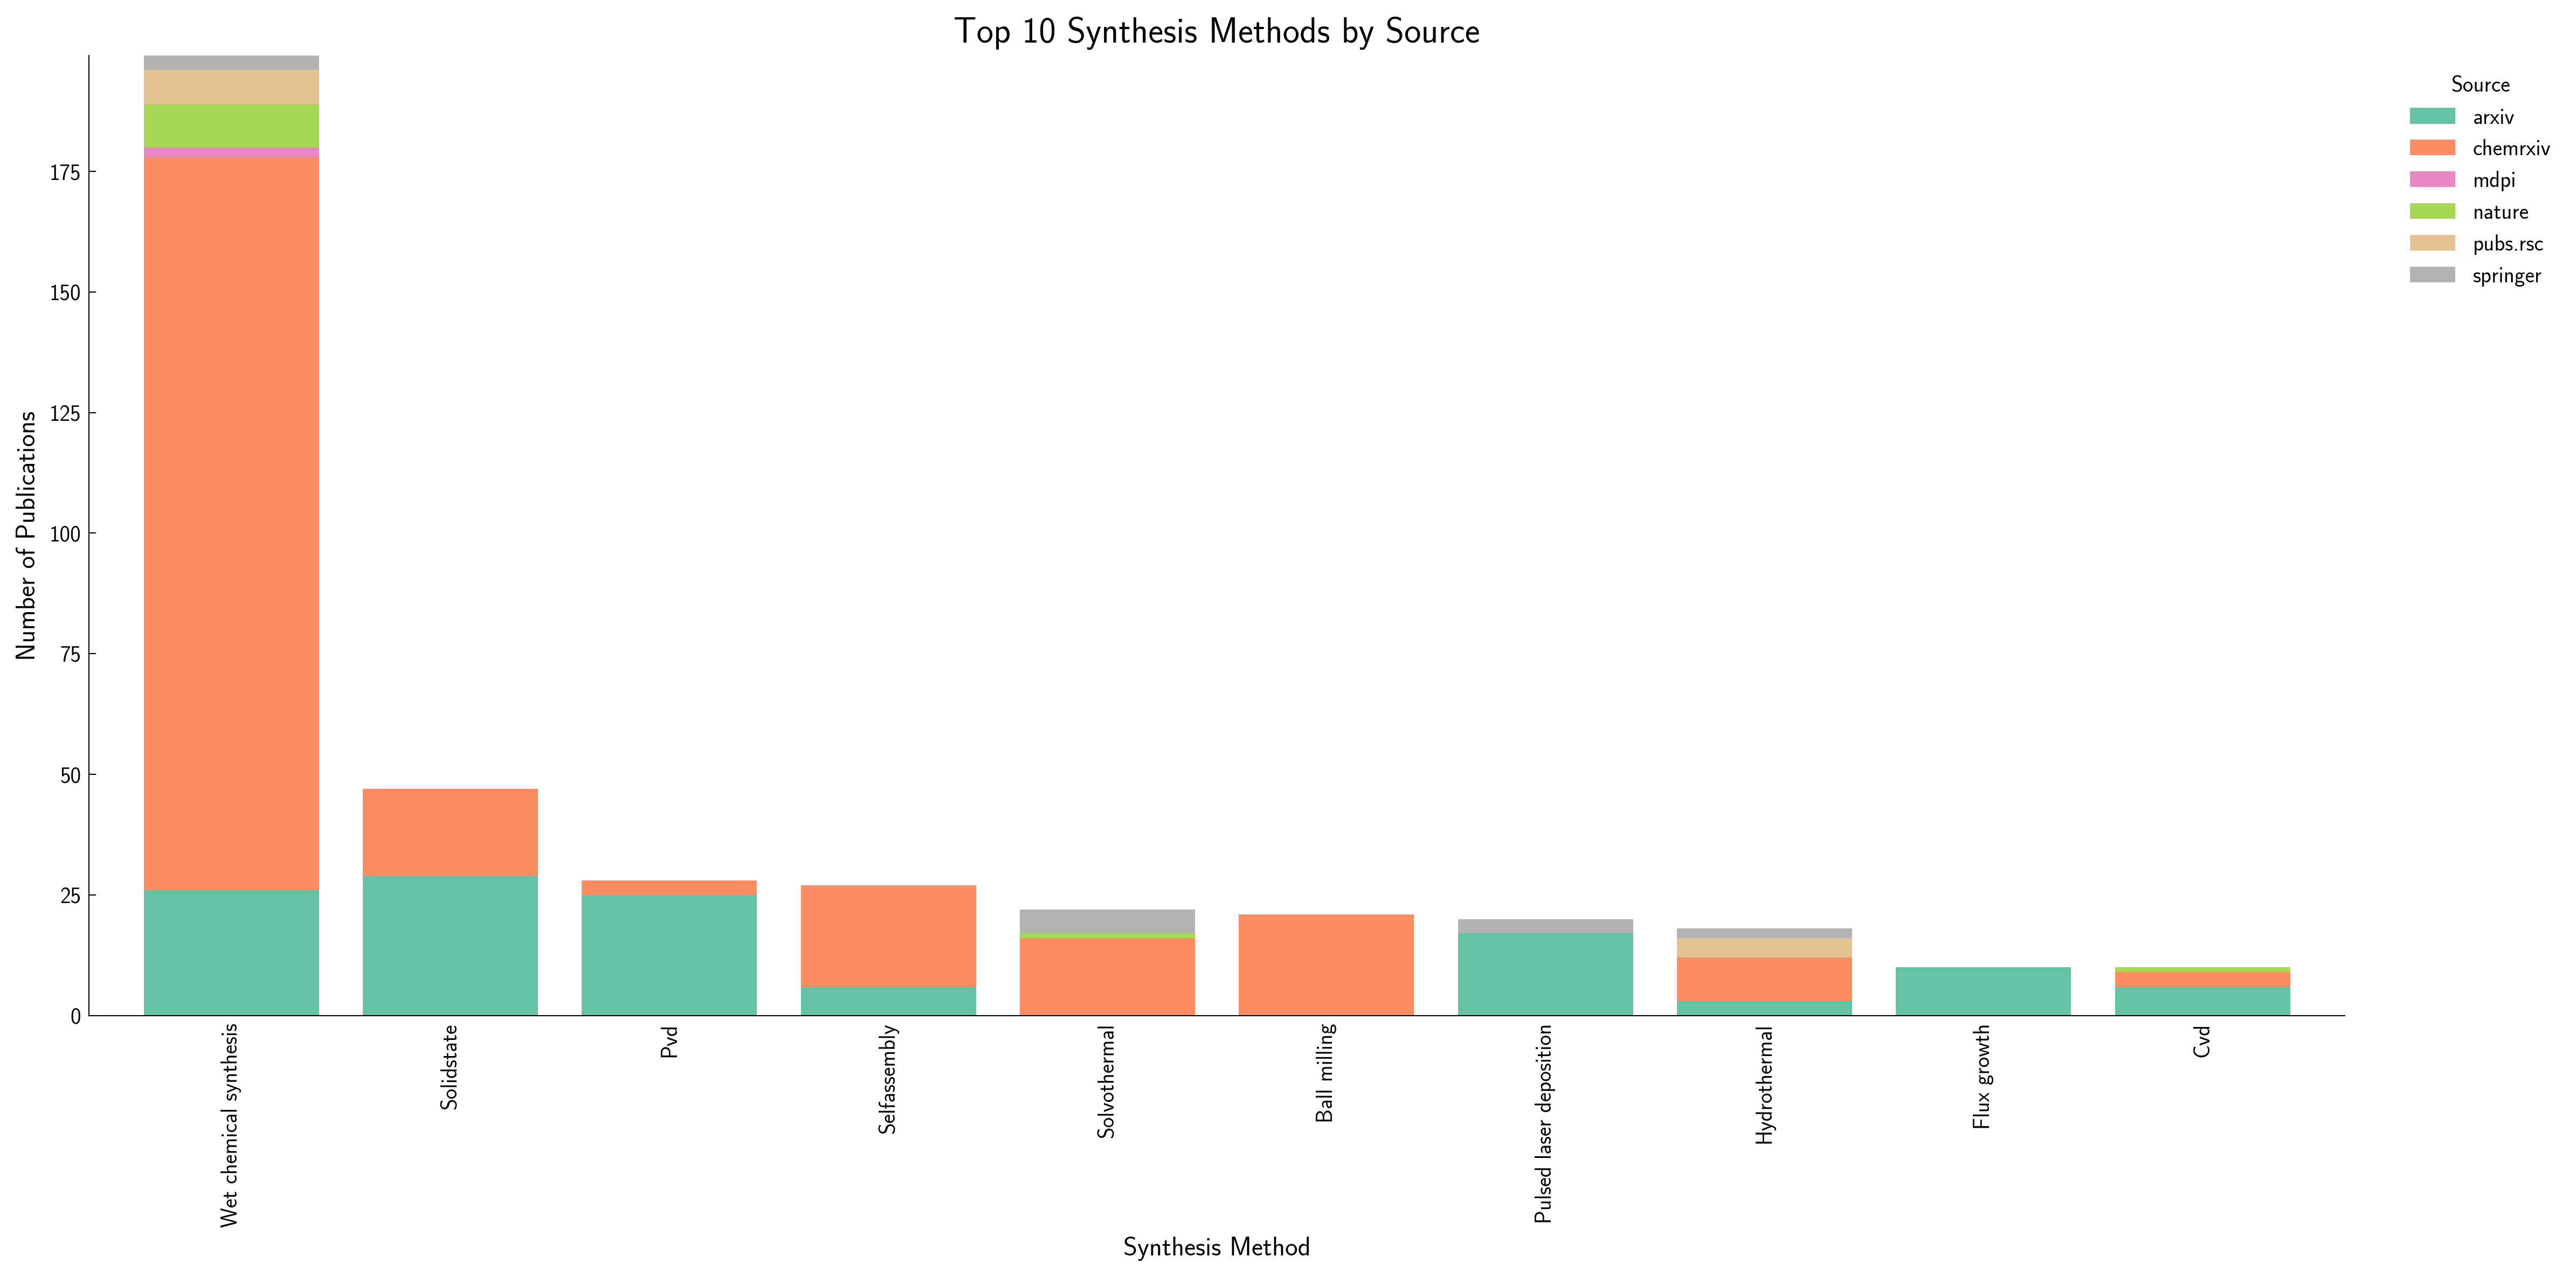

In [54]:
# Clean synthesis methods
def clean_method(method):
    if isinstance(method, str):
        method = re.sub(r"[^a-zA-Z0-9\s]", "", method).strip().capitalize()
        if method.lower() not in ["na", "n/a", "other", "others"]:
            return method
    return None


# Clean source names
data["clean_method"] = data["synthesis_method"].apply(clean_method)
data["clean_source"] = (
    data["source"]
    .astype(str)
    .str.replace(
        r"^www\.|^onlinelibrary\.|\.(org|com|net|edu|info)$", "", regex=True
    )
)

# Drop rows with missing values
df = data.dropna(subset=["clean_method", "clean_source"])

# Group and count occurrences
grouped = (
    df.groupby(["clean_method", "clean_source"])
    .size()
    .reset_index(name="count")
)

# --- FILTERING AND PIVOTING ---

# 1. Identify top 10 most common methods
top_methods_order = (
    grouped.groupby("clean_method")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# 2. Filter to top methods only
filtered = grouped[grouped["clean_method"].isin(top_methods_order)]

# 3. Pivot to wide format (methods as rows, sources as columns)
pivot_df = filtered.pivot_table(
    index="clean_method", columns="clean_source", values="count", fill_value=0
)

# 4. Reorder methods in the DataFrame
pivot_df = pivot_df.reindex(top_methods_order)

# --- PLOTTING STACKED BAR CHART ---

# Create the stacked bar plot
ax = pivot_df.plot(
    kind="bar", stacked=True, figsize=(16, 8), width=0.8, colormap="Set2"
)

# Add labels and styling
plt.title("Top 10 Synthesis Methods by Source", fontsize=16)
plt.xlabel("Synthesis Method", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.xticks(rotation=90, ha="center")
plt.legend(title="Source", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

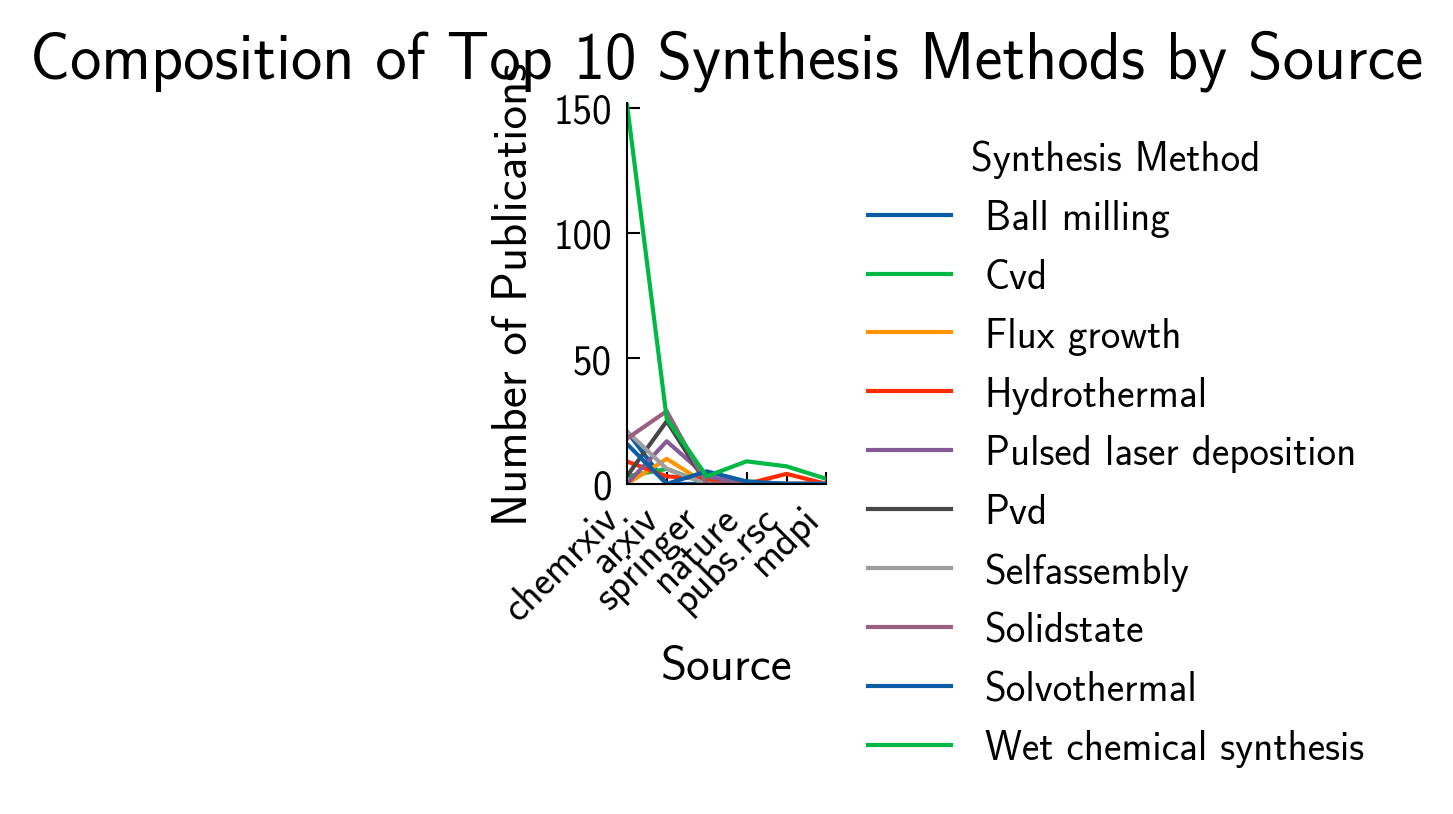

In [55]:
data["clean_method"] = data["synthesis_method"].apply(clean_method)
data["clean_source"] = (
    data["source"]
    .astype(str)
    .str.replace(
        r"^www\.|^onlinelibrary\.|\.(org|com|net|edu|info)$", "", regex=True
    )
)

df = data.dropna(subset=["clean_method", "clean_source"])
grouped = (
    df.groupby(["clean_method", "clean_source"])
    .size()
    .reset_index(name="count")
)

# 1. We still identify the top 10 overall methods to keep the chart focused
top_methods_order = (
    grouped.groupby("clean_method")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# 2. Filter data to include only publications using one of these top 10 methods
filtered = grouped[grouped["clean_method"].isin(top_methods_order)]

# 3. Invert the pivot table 🔄
# Now, the sources are the rows (index) and the methods are the columns.
pivot_df_swapped = filtered.pivot_table(
    index="clean_source", columns="clean_method", values="count", fill_value=0
)

# 4. Optional but recommended: Sort the sources by total number of publications
source_order = pivot_df_swapped.sum(axis=1).sort_values(ascending=False).index
pivot_df_swapped = pivot_df_swapped.reindex(source_order)


# 5. Plot the inverted data as a stacked bar chart
ax = pivot_df_swapped.plot()
kind = ("bar",)
stacked = (True,)
figsize = ((16, 8),)
width = (0.8,)
colormap = "tab20"

# Styling the plot with updated labels
plt.title("Composition of Top 10 Synthesis Methods by Source", fontsize=16)
plt.xlabel("Source", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Synthesis Method", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

### **Synthesized Materials by source**


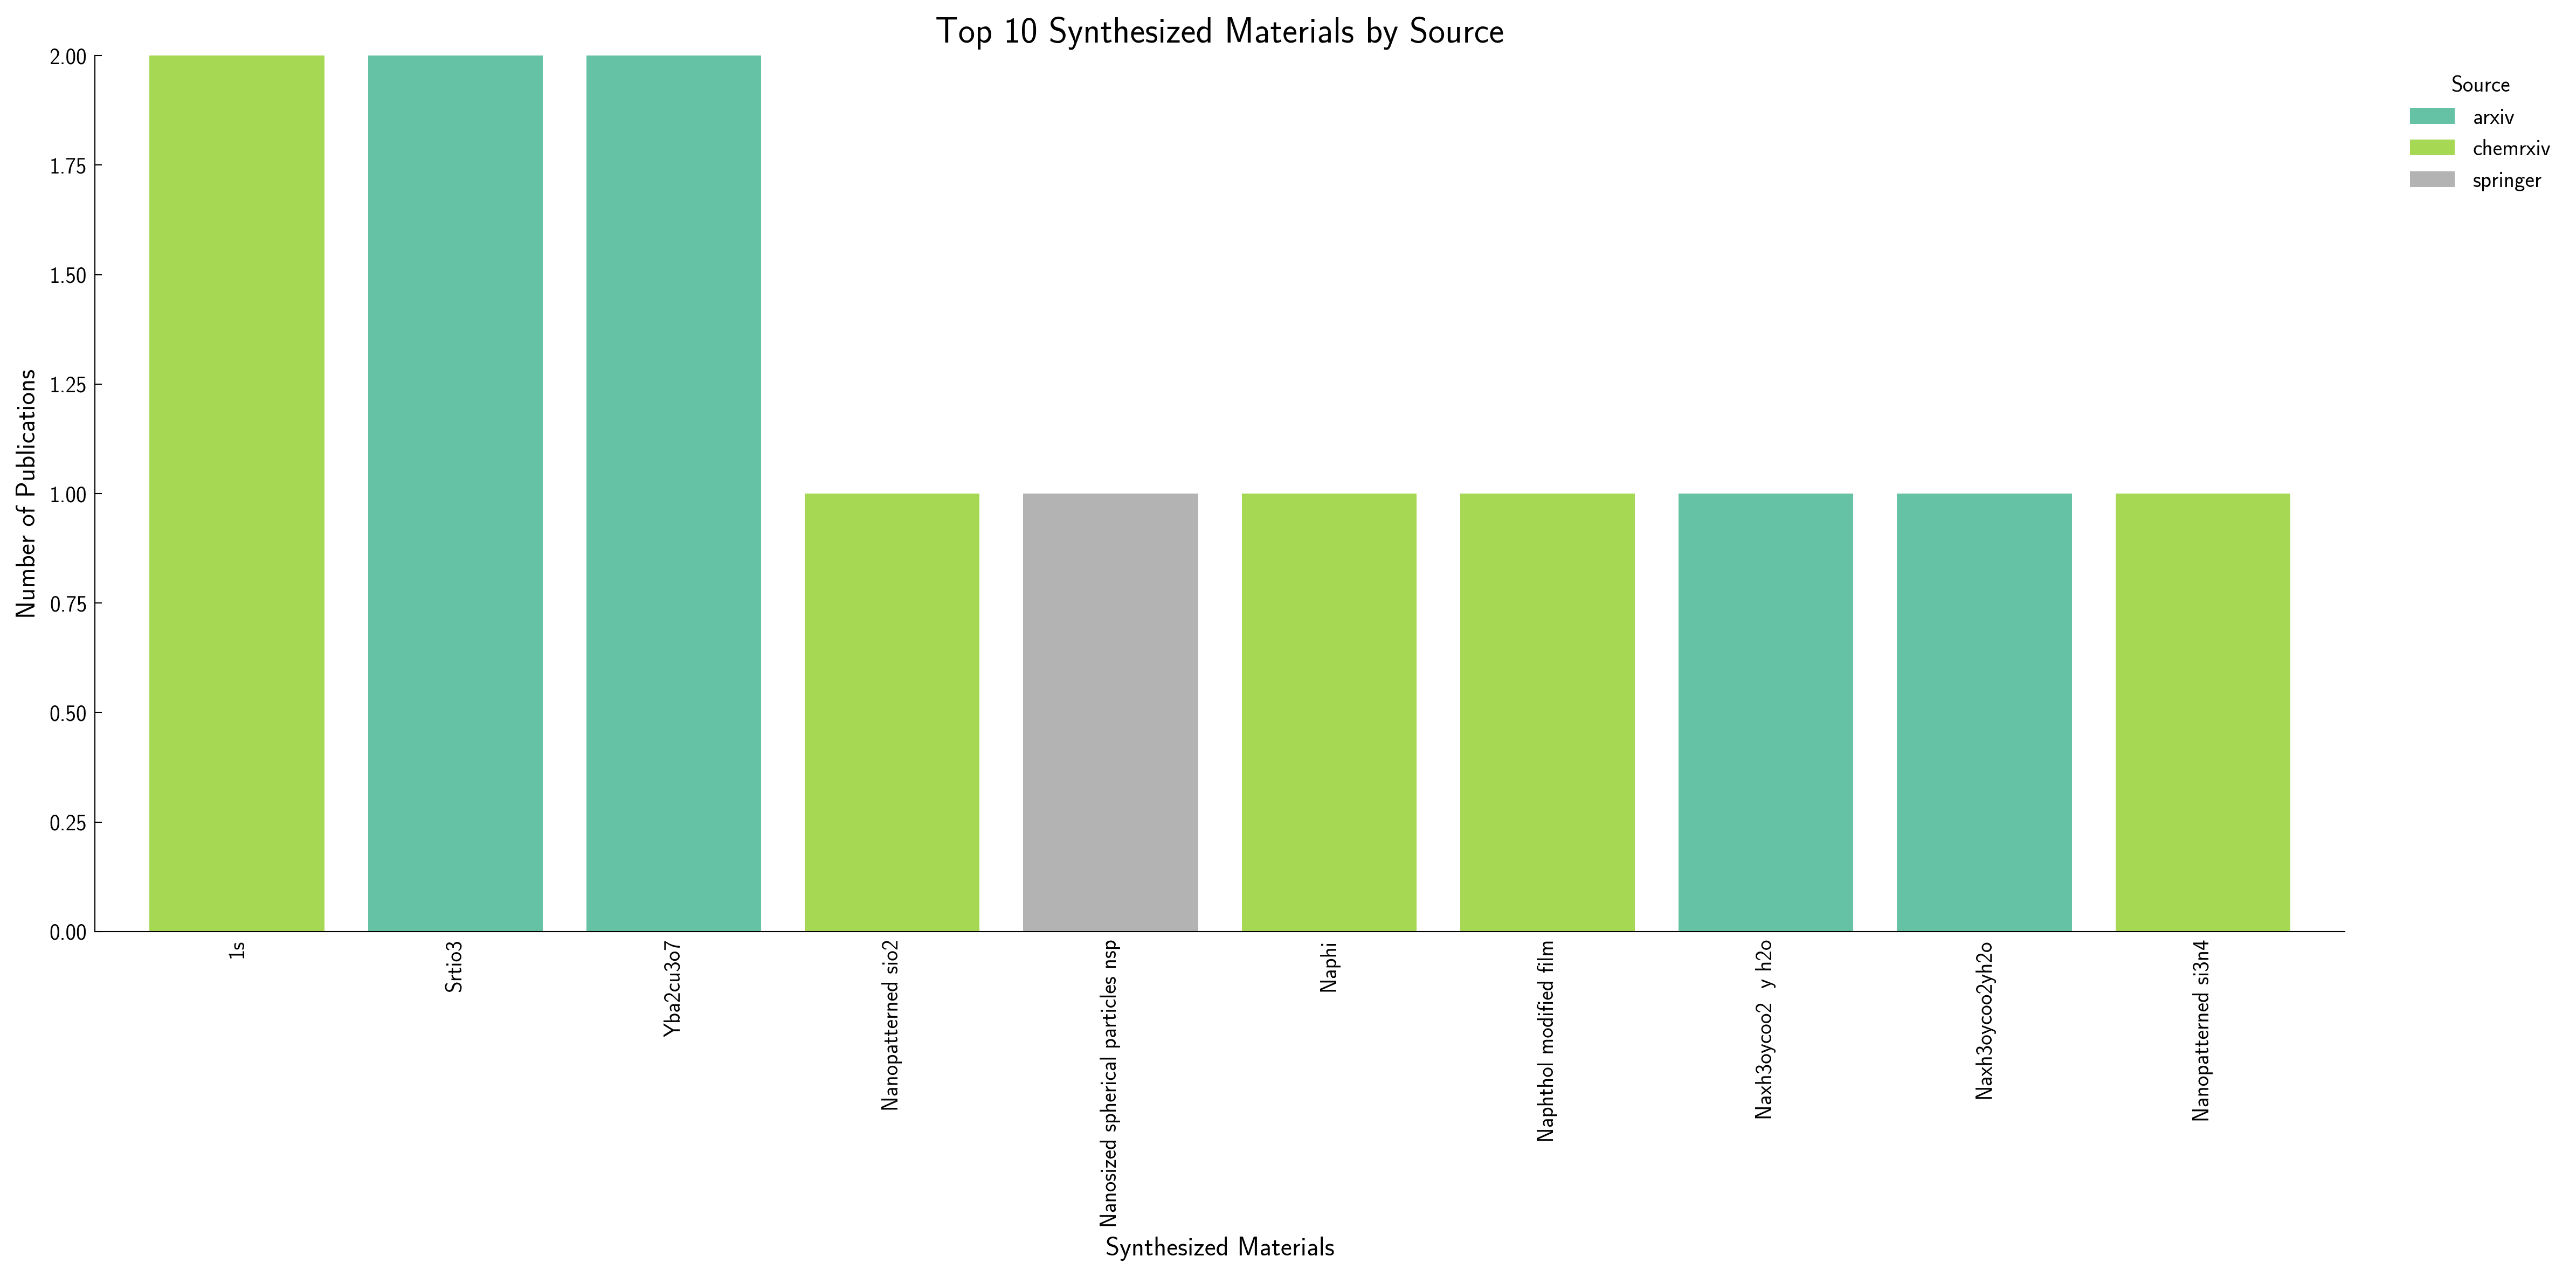

In [56]:
# Clean synthesis methods
def clean_synth(synth):
    if isinstance(synth, str):
        synth = re.sub(r"[^a-zA-Z0-9\s]", "", synth).strip().capitalize()
        if synth.lower() not in ["na", "n/a", "other", "others"]:
            return synth
    return None


# Clean source names
data["clean_synth"] = data["synthesized_material"].apply(clean_synth)
data["clean_source"] = (
    data["source"]
    .astype(str)
    .str.replace(
        r"^www\.|^onlinelibrary\.|\.(org|com|net|edu|info)$", "", regex=True
    )
)

# Drop rows with missing values
df = data.dropna(subset=["clean_synth", "clean_source"])

# Group and count occurrences
grouped = (
    df.groupby(["clean_synth", "clean_source"]).size().reset_index(name="count")
)

# --- FILTERING AND PIVOTING ---

# 1. Identify top 10 most common synthesized materials
top_synth_order = (
    grouped.groupby("clean_synth")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# 2. Filter to top synthesized materials only
filtered = grouped[grouped["clean_synth"].isin(top_synth_order)]

# 3. Pivot to wide format (synthesized materials as rows, sources as columns)
pivot_df = filtered.pivot_table(
    index="clean_synth", columns="clean_source", values="count", fill_value=0
)

# 4. Reorder synthesized materials in the DataFrame
pivot_df = pivot_df.reindex(top_synth_order)

# Create the stacked bar plot
ax = pivot_df.plot(
    kind="bar", stacked=True, figsize=(16, 8), width=0.8, colormap="Set2"
)

# Add labels and styling
plt.title("Top 10 Synthesized Materials by Source", fontsize=16)
plt.xlabel("Synthesized Materials", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.xticks(rotation=90, ha="center")
plt.legend(title="Source", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

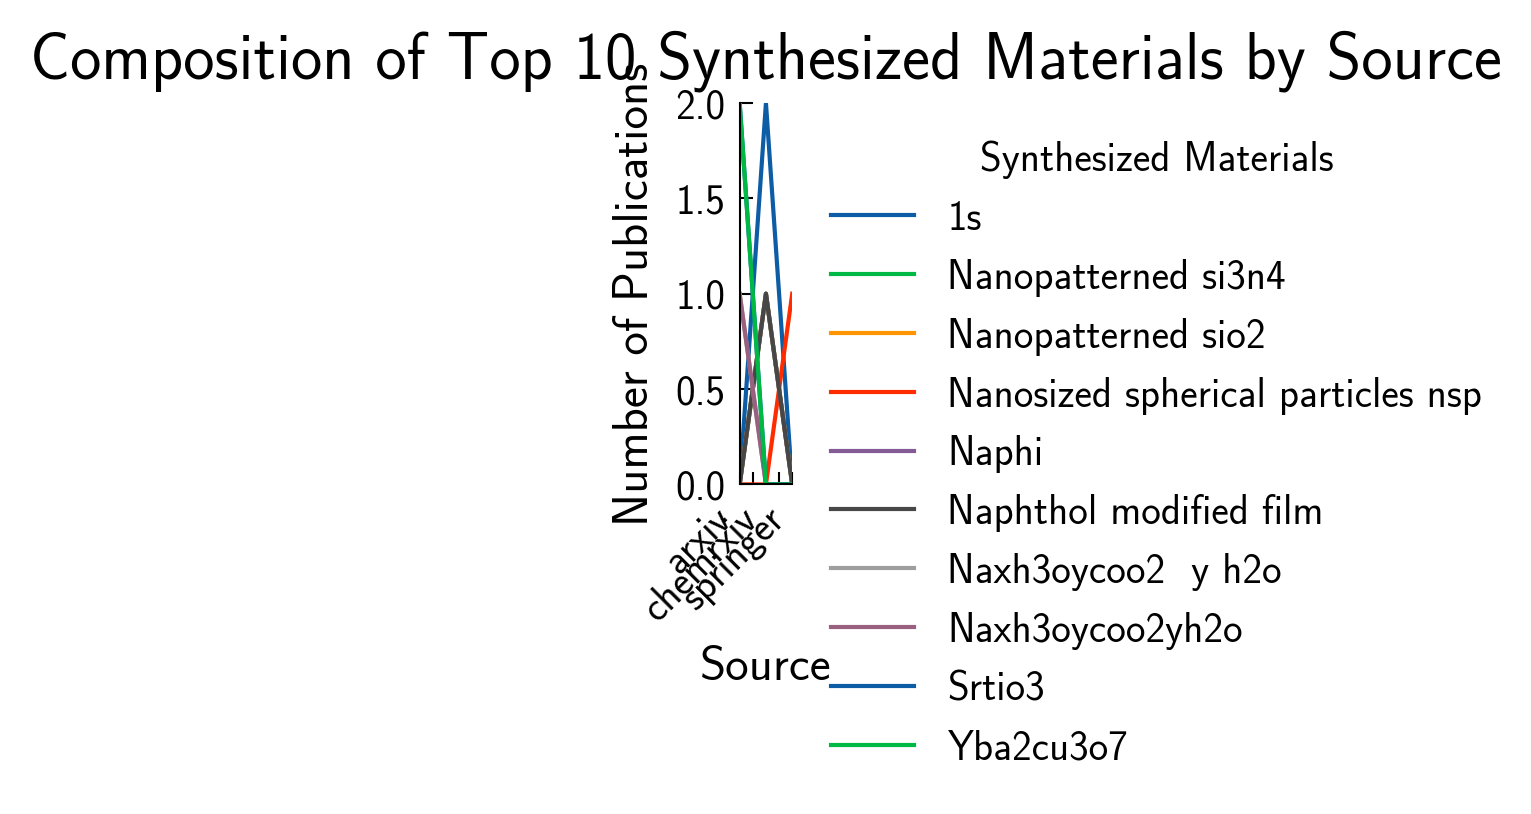

In [57]:
data["clean_synth"] = data["synthesized_material"].apply(clean_synth)
data["clean_source"] = (
    data["source"]
    .astype(str)
    .str.replace(
        r"^www\.|^onlinelibrary\.|\.(org|com|net|edu|info)$", "", regex=True
    )
)

df = data.dropna(subset=["clean_synth", "clean_source"])
grouped = (
    df.groupby(["clean_synth", "clean_source"]).size().reset_index(name="count")
)

# 1. We still identify the top 10 overall methods to keep the chart focused
top_synth_order = (
    grouped.groupby("clean_synth")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# 2. Filter data to include only publications using one of these top 10 methods
filtered = grouped[grouped["clean_synth"].isin(top_synth_order)]

# 3. Invert the pivot table 🔄
# Now, the sources are the rows (index) and the synthesized materials are the columns.
pivot_df_swapped = filtered.pivot_table(
    index="clean_source", columns="clean_synth", values="count", fill_value=0
)

# 4. Optional but recommended: Sort the sources by total number of publications
source_order = pivot_df_swapped.sum(axis=1).sort_values(ascending=False).index
pivot_df_swapped = pivot_df_swapped.reindex(source_order)


# 5. Plot the inverted data as a stacked bar chart
ax = pivot_df_swapped.plot()
kind = ("bar",)
stacked = (True,)
figsize = ((16, 8),)
width = (0.8,)
colormap = "tab20"

# Styling the plot with labels
plt.title("Composition of Top 10 Synthesized Materials by Source", fontsize=16)
plt.xlabel("Source", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(
    title="Synthesized Materials", bbox_to_anchor=(1.02, 1), loc="upper left"
)
plt.tight_layout()
plt.show()

### **Average Number of Procedure Steps**

Total synthesis procedures: 569
Valid procedures (with steps > 0): 514
Average number of steps (all procedures): 3.25
Average number of steps (valid procedures only): 3.60
Minimum steps: 0
Maximum steps: 24


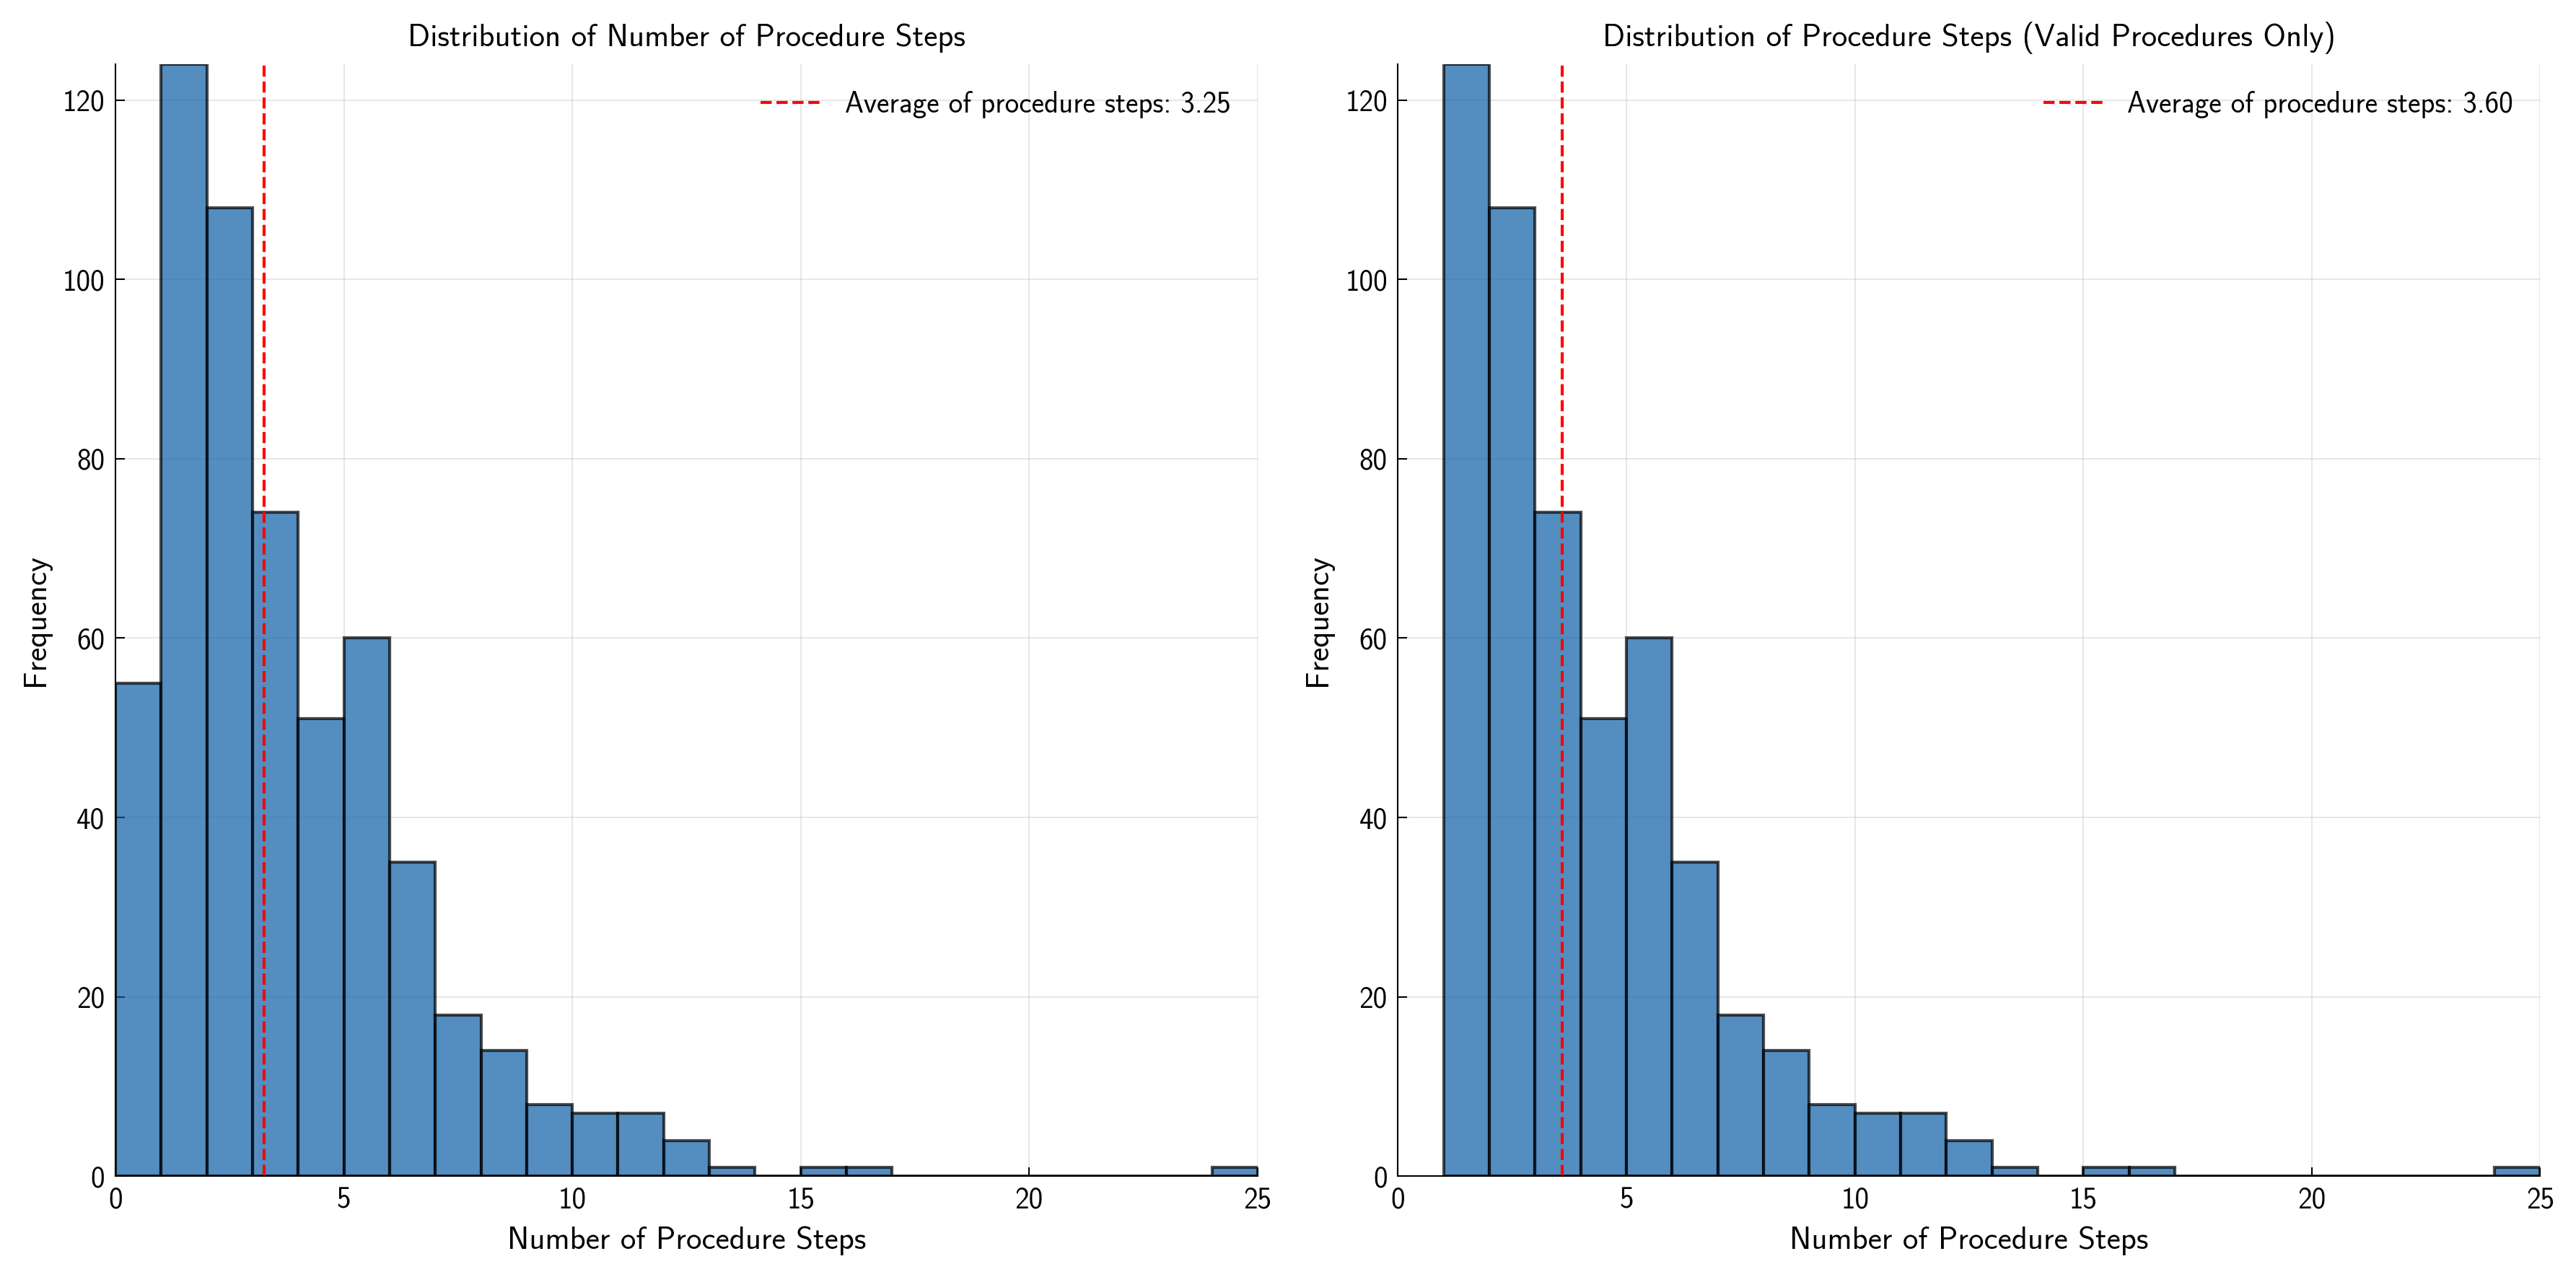

In [58]:
# Calculate the number of steps for each synthesis procedure
step_counts = []

for idx, raw in enumerate(data["structured_synthesis"]):
    try:
        # Parse the JSON data
        record = json.loads(raw) if isinstance(raw, str) else raw

        # Count the number of steps
        num_steps = len(record.get("steps", []))
        step_counts.append(num_steps)

    except (json.JSONDecodeError, TypeError, AttributeError):
        # If parsing fails, append 0 or skip
        step_counts.append(0)

# Add the step counts as a new column to the dataframe
data["num_steps"] = step_counts

# Calculate statistics
total_procedures = len(step_counts)
valid_procedures = sum(1 for count in step_counts if count > 0)
average_steps = sum(step_counts) / len(step_counts) if step_counts else 0
average_steps_valid = sum(step_counts) / valid_procedures if valid_procedures > 0 else 0

print(f"Total synthesis procedures: {total_procedures}")
print(f"Valid procedures (with steps > 0): {valid_procedures}")
print(f"Average number of steps (all procedures): {average_steps:.2f}")
print(f"Average number of steps (valid procedures only): {average_steps_valid:.2f}")
print(f"Minimum steps: {min(step_counts)}")
print(f"Maximum steps: {max(step_counts)}")

# Determine the maximum number of steps for setting consistent x-limits
max_steps = max(step_counts) if step_counts else 0
x_limit = max_steps + 1 # Add a small buffer

# Display distribution of step counts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(step_counts, bins=range(0, max_steps+2), alpha=0.7, edgecolor='black')
plt.title("Distribution of Number of Procedure Steps")
plt.xlabel("Number of Procedure Steps")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.axvline(average_steps, color='red', linestyle='dashed', linewidth=1, label=f'Average of procedure steps: {average_steps:.2f}')
plt.legend()
plt.xlim(0, x_limit) # Set consistent x-limits

plt.subplot(1, 2, 2)
# Filter out procedures with 0 steps for better visualization
valid_steps = [count for count in step_counts if count > 0]
if valid_steps:
    plt.hist(valid_steps, bins=range(1, max_steps+2), alpha=0.7, edgecolor='black')
    plt.title("Distribution of Procedure Steps (Valid Procedures Only)")
    plt.xlabel("Number of Procedure Steps")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.axvline(average_steps_valid, color='red', linestyle='dashed', linewidth=1, label=f'Average of procedure steps: {average_steps_valid:.2f}')
    plt.legend()
    plt.xlim(0, x_limit) # Set consistent x-limits
else:
     plt.text(0.5, 0.5, "No valid data to plot", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes) # Handle case with no valid data
     plt.xlim(0, x_limit)


plt.tight_layout()
plt.show()

### **Starting Materials Analysis**

In [59]:
# Analyze starting materials
import numpy as np

starting_materials_counts = []
all_starting_materials = []

def safe_len(obj):
    """Safely get length of object, handling numpy arrays"""
    if obj is None:
        return 0
    try:
        if isinstance(obj, np.ndarray):
            return obj.size
        elif hasattr(obj, '__len__'):
            return len(obj)
        else:
            return 0
    except:
        return 0

def safe_iterate(obj):
    """Safely iterate over object, handling numpy arrays"""
    if obj is None:
        return []
    try:
        if isinstance(obj, np.ndarray):
            return obj.tolist() if obj.size > 0 else []
        elif hasattr(obj, '__iter__') and not isinstance(obj, str):
            return list(obj)
        else:
            return []
    except:
        return []

for idx, raw in enumerate(data["structured_synthesis"]):
    try:
        # Parse the JSON data
        record = json.loads(raw) if isinstance(raw, str) else raw

        # Extract starting materials from the top level
        starting_materials = record.get("starting_materials", [])

        # If starting_materials is empty, collect materials from all steps
        all_materials_in_procedure = set()  # Use set to avoid duplicates

        # Check top-level starting_materials first
        for material in safe_iterate(starting_materials):
            if isinstance(material, dict) and 'name' in material:
                all_materials_in_procedure.add(material['name'])
            elif isinstance(material, str) and material.strip():
                all_materials_in_procedure.add(material.strip())

        # Extract materials from steps
        steps = record.get("steps", [])
        for step in safe_iterate(steps):
            if isinstance(step, dict) and 'materials' in step:
                step_materials = step['materials']
                for material in safe_iterate(step_materials):
                    if isinstance(material, dict) and 'name' in material:
                        material_name = material['name']
                        if material_name and isinstance(material_name, str):
                            all_materials_in_procedure.add(material_name.strip())

        # Count the number of unique materials
        num_starting_materials = len(all_materials_in_procedure)
        starting_materials_counts.append(num_starting_materials)

        # Collect all materials for frequency analysis
        for material_name in all_materials_in_procedure:
            # Clean the material name
            if isinstance(material_name, str):
                cleaned_material = re.sub(r'[^\w\s\-\(\)]', '', material_name)
                if cleaned_material and cleaned_material.lower() not in ['n/a', 'na', 'none', '']:
                    all_starting_materials.append(cleaned_material)

    except (json.JSONDecodeError, TypeError, AttributeError) as e:
        # If parsing fails, append 0
        starting_materials_counts.append(0)

# Add the starting materials counts as a new column to the dataframe
data["num_starting_materials"] = starting_materials_counts

# Calculate statistics for starting materials
total_procedures_sm = len(starting_materials_counts)
valid_procedures_sm = sum(1 for count in starting_materials_counts if count > 0)
average_starting_materials = sum(starting_materials_counts) / len(starting_materials_counts) if starting_materials_counts else 0
average_starting_materials_valid = sum(starting_materials_counts) / valid_procedures_sm if valid_procedures_sm > 0 else 0

print("=== Starting Materials Statistics ===")
print(f"Total synthesis procedures: {total_procedures_sm}")
print(f"Valid procedures (with starting materials > 0): {valid_procedures_sm}")
print(f"Average number of starting materials (all procedures): {average_starting_materials:.2f}")
print(f"Average number of starting materials (valid procedures only): {average_starting_materials_valid:.2f}")
print(f"Minimum starting materials: {min(starting_materials_counts)}")
print(f"Maximum starting materials: {max(starting_materials_counts)}")

# Analyze most common starting materials
starting_materials_counter = Counter(all_starting_materials)
print(f"\nTotal unique starting materials found: {len(starting_materials_counter)}")
print(f"Total starting material instances: {len(all_starting_materials)}")

print("\n=== Top 20 Most Common Starting Materials ===")
for material, count in starting_materials_counter.most_common(20):
    print(f"{material}: {count}")

=== Starting Materials Statistics ===
Total synthesis procedures: 569
Valid procedures (with starting materials > 0): 492
Average number of starting materials (all procedures): 4.04
Average number of starting materials (valid procedures only): 4.67
Minimum starting materials: 0
Maximum starting materials: 25

Total unique starting materials found: 1210
Total starting material instances: 2300

=== Top 20 Most Common Starting Materials ===
acetone: 29
ethanol: 25
water: 23
MeOH: 17
Methanol: 17
DMF: 15
CH2Cl2: 13
deionized water: 11
3: 11
Ru: 10
Ta: 10
methanol: 10
THF: 10
NaOH: 9
toluene: 9
NaCl: 9
TFA: 9
CD3CN: 9
Water: 9
Isopropanol: 9


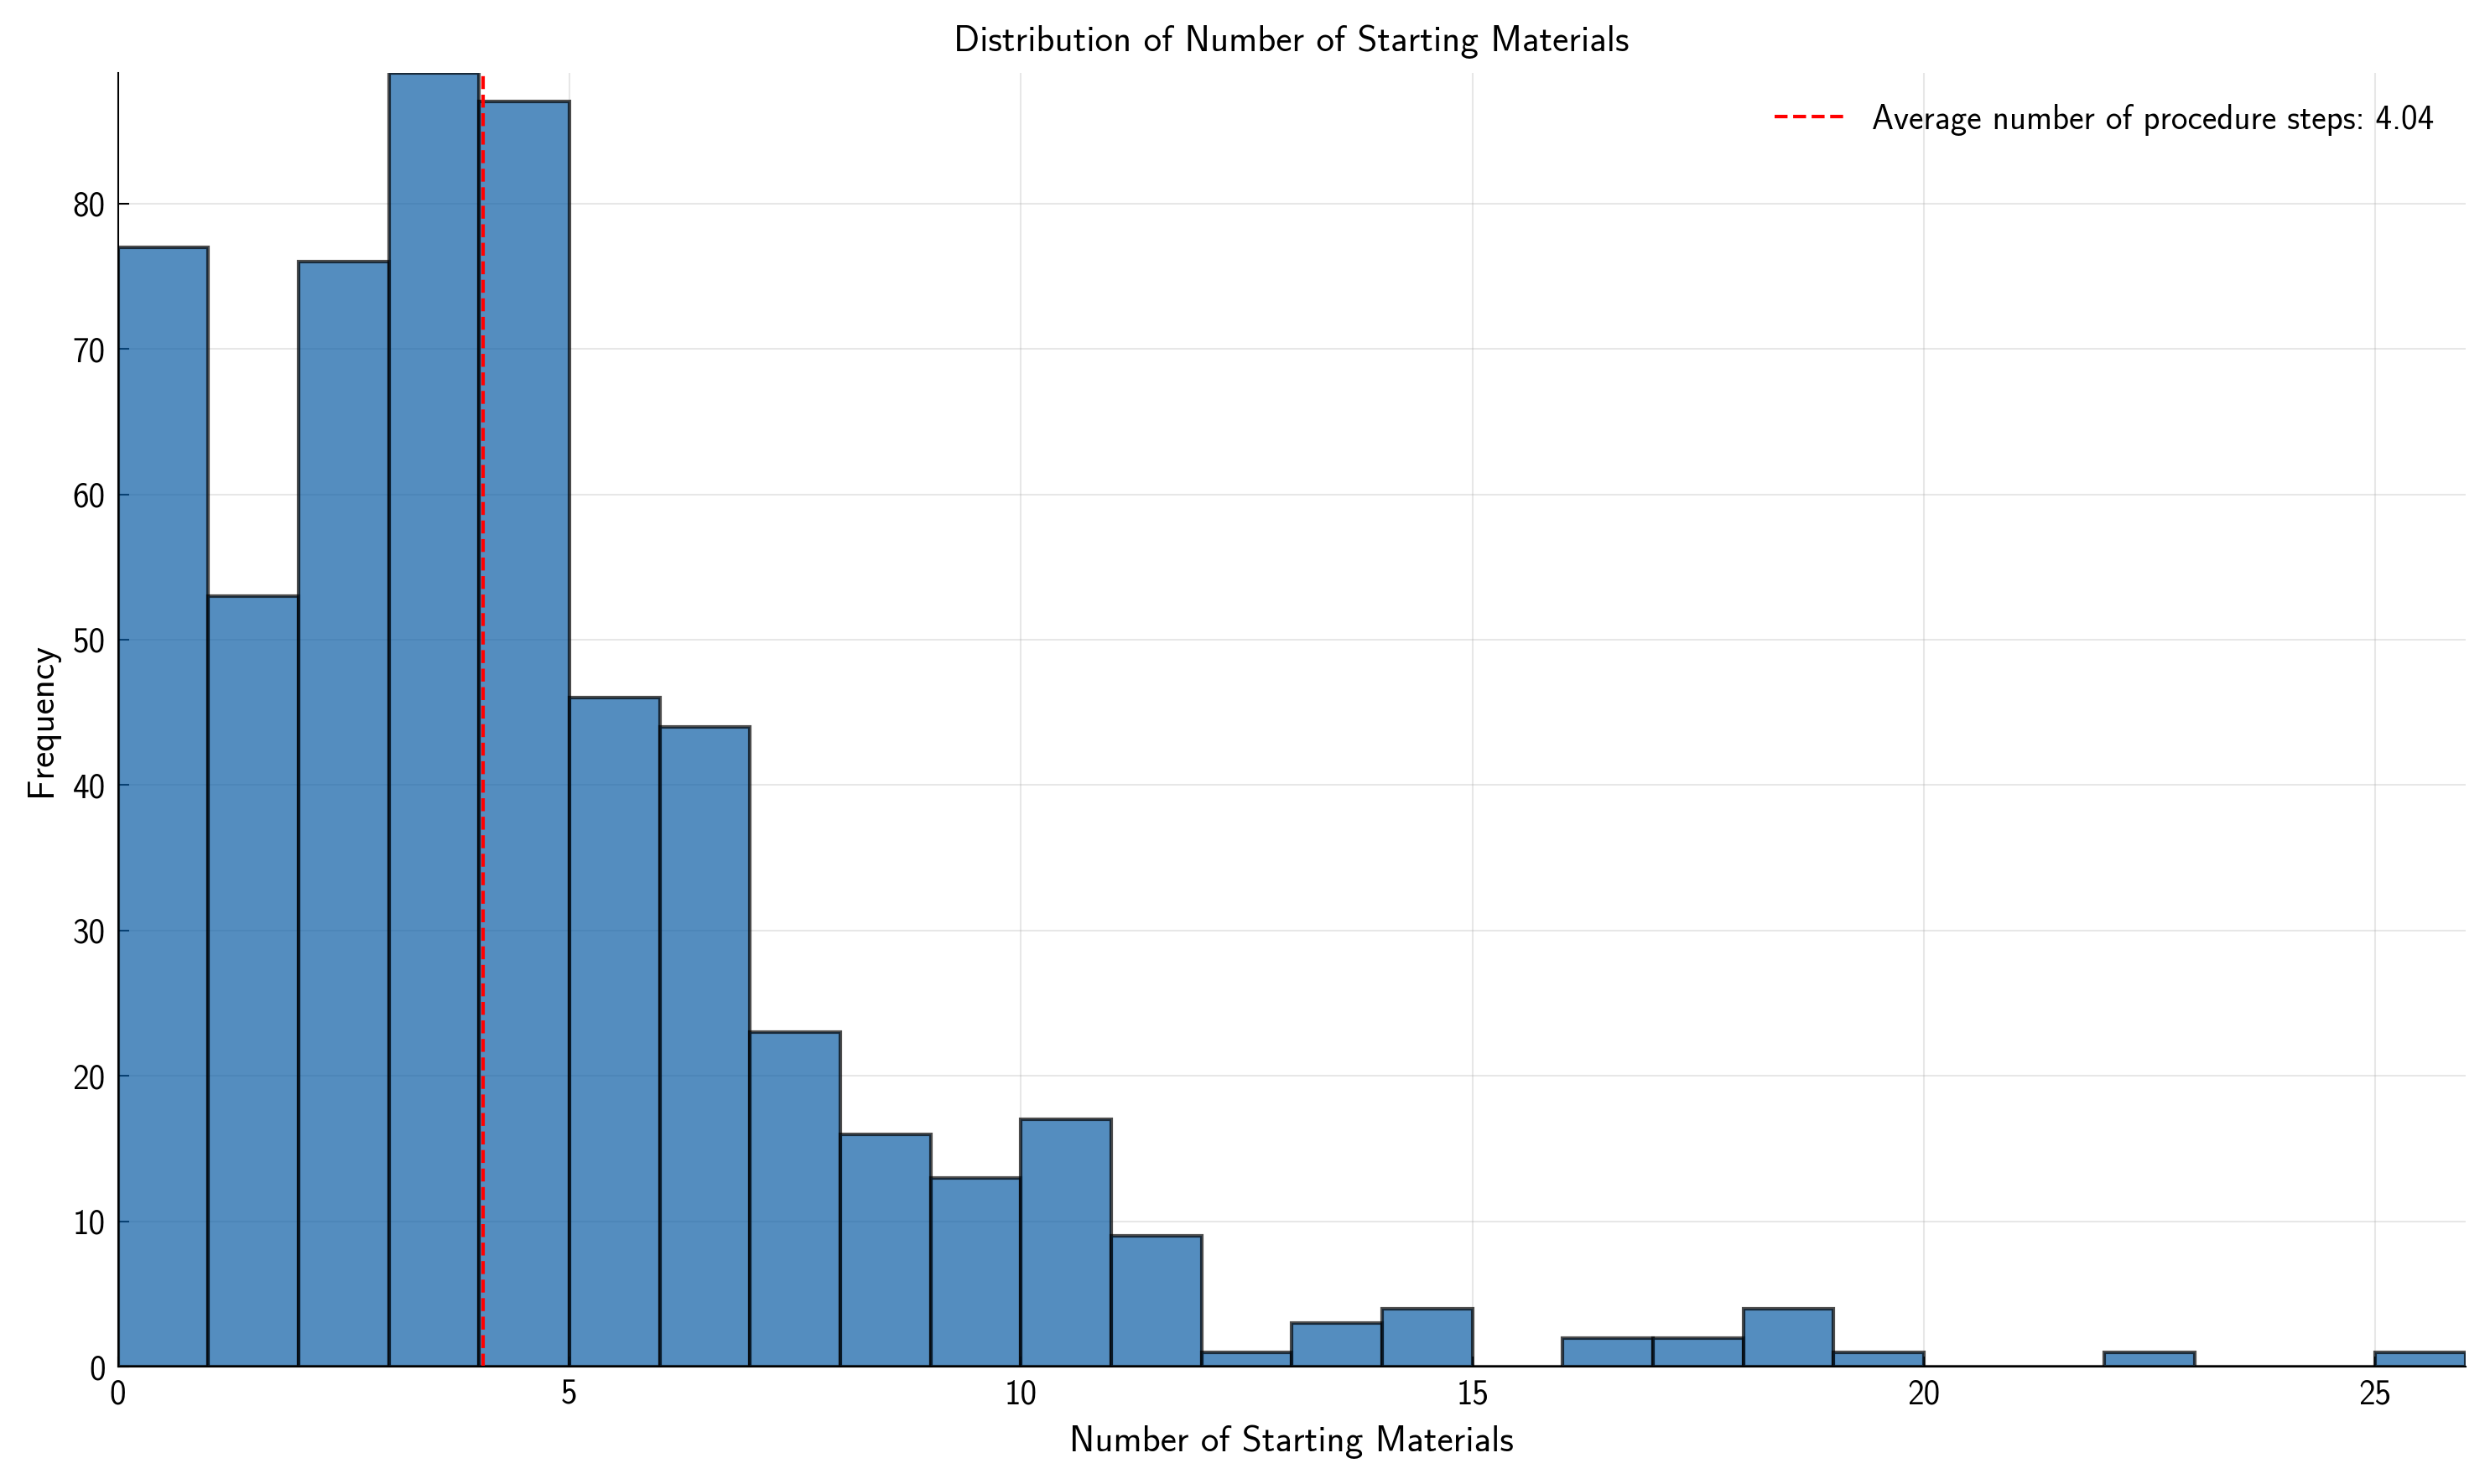

In [60]:
# Plot 1: Distribution of number of starting materials
plt.figure(figsize=(10, 6))
plt.hist(starting_materials_counts, bins=range(0, max(starting_materials_counts)+2), alpha=0.7, edgecolor='black')
plt.title("Distribution of Number of Starting Materials")
plt.xlabel("Number of Starting Materials")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.axvline(average_starting_materials, color='red', linestyle='dashed', linewidth=1, label=f'Average number of procedure steps: {average_starting_materials:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

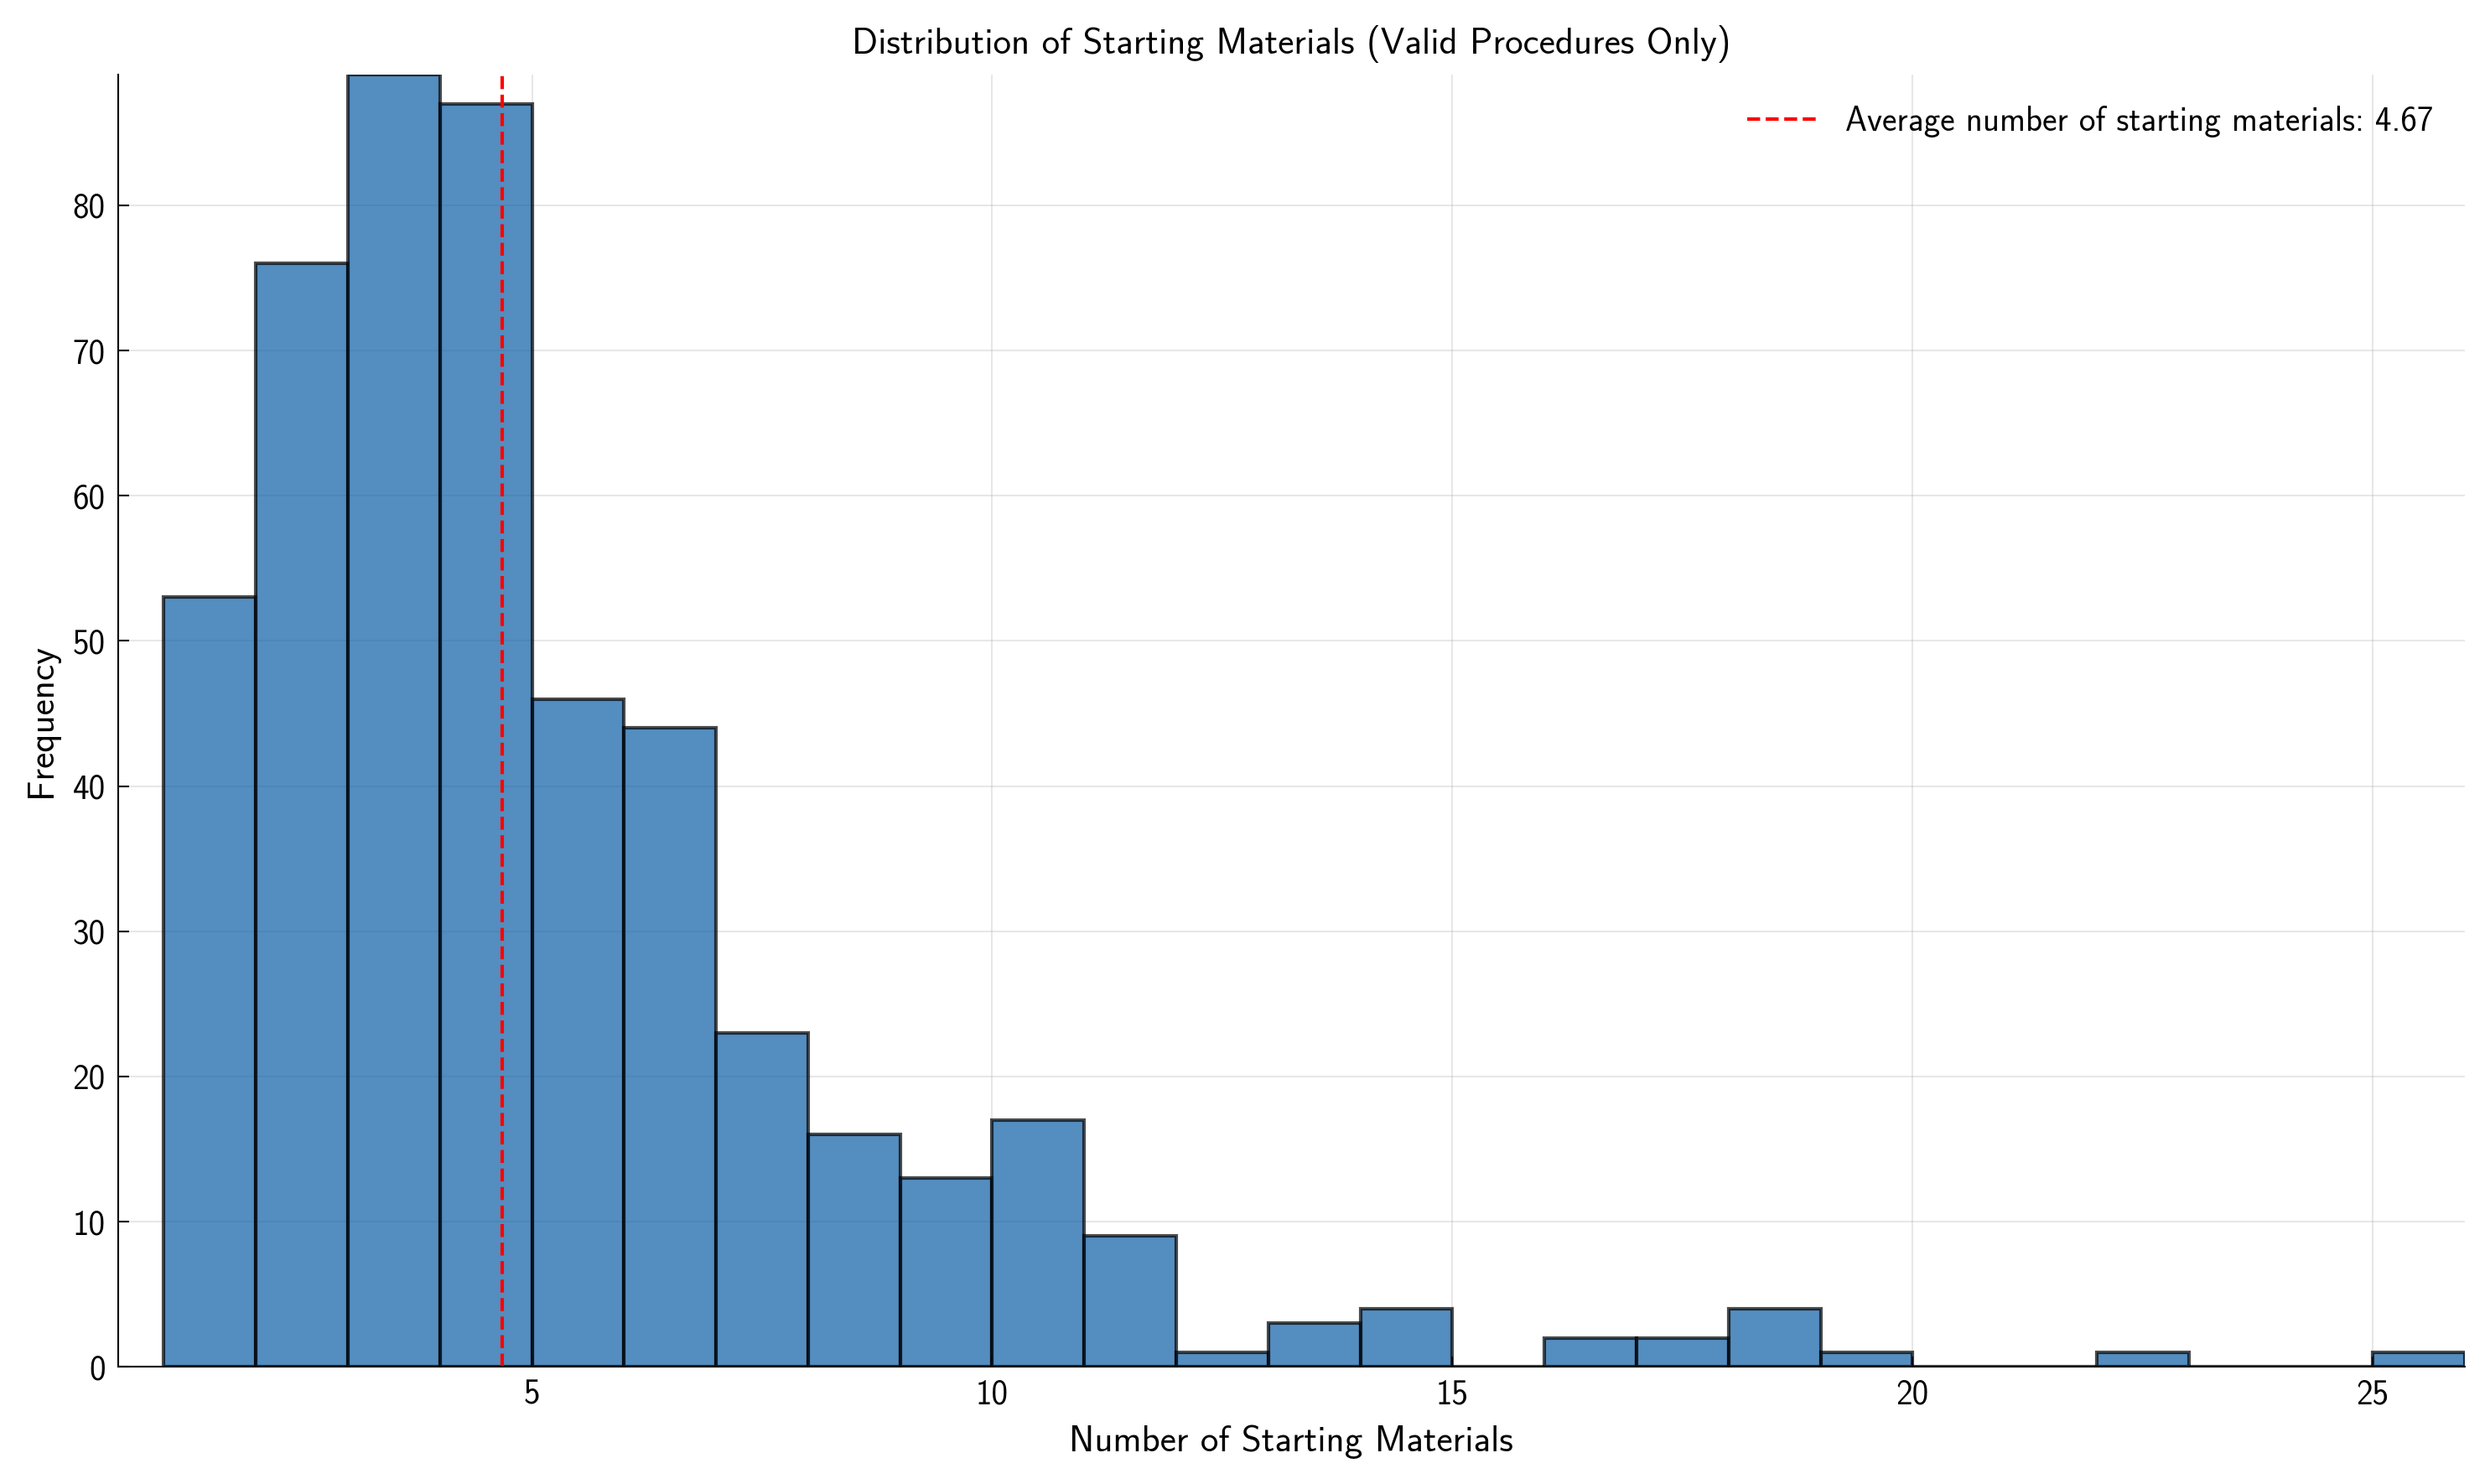

In [61]:
# Plot 2: Distribution excluding zero starting materials
plt.figure(figsize=(10, 6))
valid_sm_counts = [count for count in starting_materials_counts if count > 0]
if valid_sm_counts:
    # Create bins that start from the minimum valid value
    min_materials = min(valid_sm_counts)
    max_materials = max(valid_sm_counts)
    bins = range(min_materials, max_materials + 2)  # +2 because range is exclusive of end
    
    plt.hist(valid_sm_counts, bins=bins, alpha=0.7, edgecolor='black')
    plt.title("Distribution of Starting Materials (Valid Procedures Only)")
    plt.xlabel("Number of Starting Materials")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.axvline(average_starting_materials_valid, color='red', linestyle='dashed', linewidth=1, label=f'Average number of starting materials: {average_starting_materials_valid:.2f}')
    plt.legend()
    
    # Set x-axis to start from the minimum valid value
    plt.xlim(left=min_materials-0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No valid starting materials data to plot")

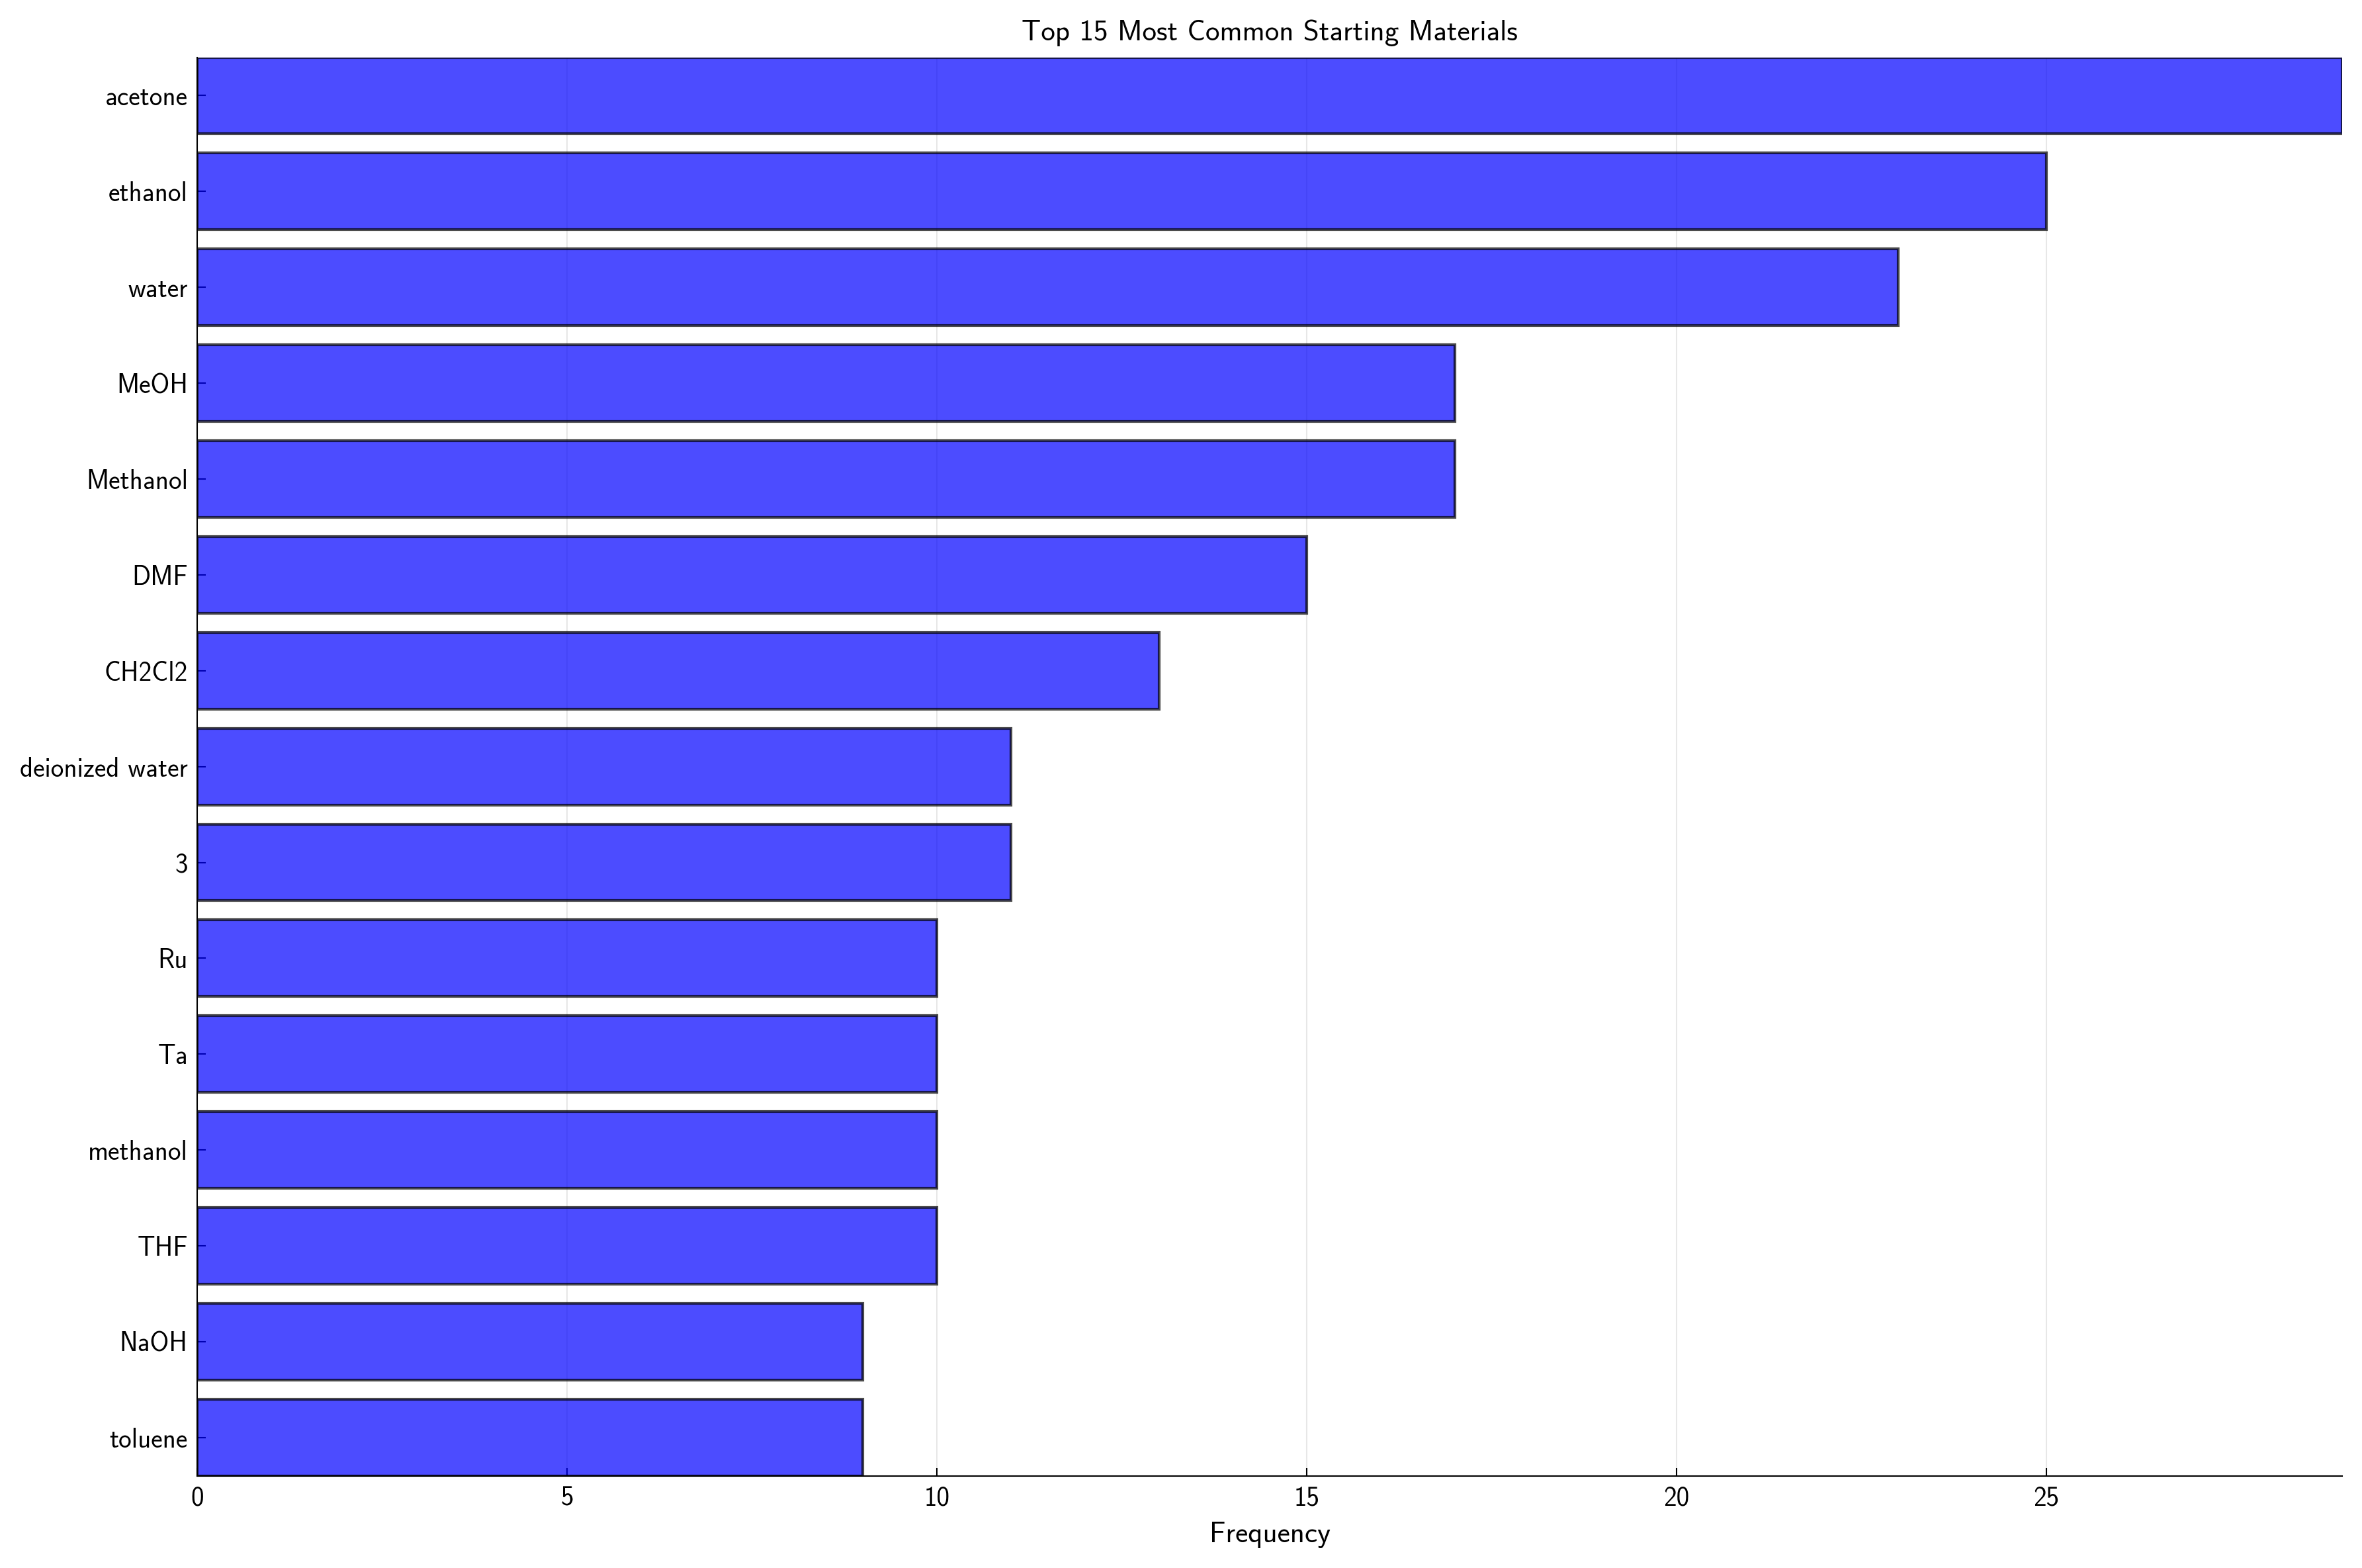

In [62]:
# Plot 3: Top N most common starting materials

# Define the number of top materials to display
N = 15  # You can change this number

plt.figure(figsize=(12, 8))

# Get the top N most common starting materials
top_N_materials = starting_materials_counter.most_common(N)

if top_N_materials:
    materials, counts = zip(*top_N_materials)
    y_pos = range(len(materials))
    plt.barh(y_pos, counts, alpha=0.7, color='blue', edgecolor='black')
    plt.yticks(y_pos, materials)
    plt.xlabel("Frequency")
    plt.title(f"Top {N} Most Common Starting Materials")  # Update title with N
    plt.gca().invert_yaxis()  # Highest at top
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("No starting materials data available for plotting")